# Correct the sophronia hits of interest based on selection
selection found from DSTs in `files/15107_energy_split/*.h5`

### Uncorrected energy
- **Photopeak** > 1.6 'MeV'

### Corrected energy
- **DES** 1.4-1.8 MeV 
- **Low E stuff (x-rays?)** 0-1 MeV
- **Post compton edge** > 2.4 MeV

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

import sys,os,os.path
sys.path.append("/gluster/data/next/software/IC_311024/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
#sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/gluster/data/next/software/IC_311024/'

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from IC.invisible_cities.cities.components import track_blob_info_creator_extractor
from IC.invisible_cities.io.hits_io        import load_hits
from IC.invisible_cities.io.hits_io        import hits_from_df
from IC.invisible_cities.core              import system_of_units as units
from IC.invisible_cities.types.symbols     import HitEnergy
from IC.invisible_cities.evm.event_model   import HitCollection
from IC.invisible_cities.evm.event_model   import Cluster
from IC.invisible_cities.evm.event_model   import Hit
from IC.invisible_cities.types.ic_types    import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from tqdm import tqdm

## load in the beersheba nonsense

In [8]:
def plotter(df, evt):
    evt_interest = df[df.event == evt]
    
    print('======================')
    print(f'EVENT {evt}')
    print(f'Total energy {evt_interest.Ec.sum():.2f} MeV')
    print('======================\n')
    hits_cut = coref.timefunc(cut_sensors)(evt_interest.copy())
    hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
    pitch = 15.55
    # then applying transformations to convert to 'SiPM outputs'
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))


    xx = np.arange(hits_drop.X.min(), hits_drop.X.max() + pitch, pitch)
    yy = np.arange(hits_drop.Y.min(), hits_drop.Y.max() + pitch, pitch)
    zz = hits_cut.Z.unique()

    axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');

    fig.suptitle('Processed Sensors Signal_' + str(evt) + ' - rebin = 4', fontsize=30)
    #plt.savefig(f'plots/hits_{evt}.pdf')
    plt.show(fig)


In [6]:
PSF_PATH = '/gluster/data/next/files/TOPOLOGY_John/N100_data/14914/prod_psf/eutropia/merged_psfs/final_psf.psf'
datatype = 'data'
detector_db = '/gluster/data/next/software/IC_311024/IC/invisible_cities/database/localdb.NEXT100DB.sqlite3'
run_number = 15107

deconv_params = dict(
  q_cut           = 10, #5 for 6mm  - 5 for 6mm
  drop_dist       = [16, 16],
  psf_fname       = PSF_PATH,     
  e_cut           = 0.3, #15 for 6mm  - 15 for 6mm
  n_iterations    = 30, #150 for 6mm  - 150 for 6mm
  iteration_tol   = 1e-9,
  sample_width    = [15.55, 15.55],
  bin_size        = [ 5,  5],
  diffusion       = (1., 0.2),
  n_dim           = 2,
  deconv_mode     = DeconvolutionMode.joint,
  satellite_params = dict(satellite_start_iter = 100,
                          satellite_max_size   = 25,
                          e_cut                = 0.9,
                          cut_type             = CutType.rel),
  energy_type     = HitEnergy.Ec,
  cut_type        = CutType.rel)
 # inter_method    = InterpolationMethod.cubic)
#satellite_params = dict(satellite_start_iter = 75,
#                        satellite_max_size   = 3,
#                        e_cut                = 0.2,
#                        cut_type             = CutType.rel)
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.

cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])


# Select and look at events for:
## uncorrected high energy

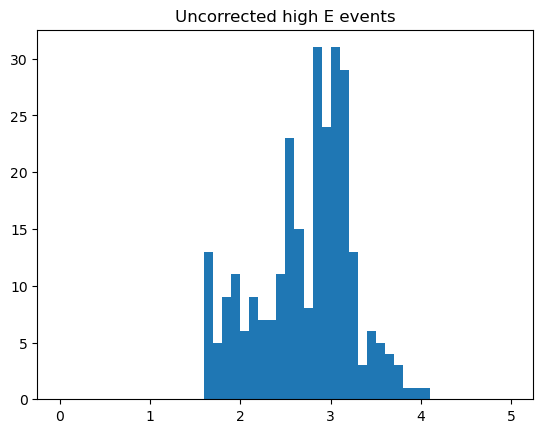

In [3]:
folder_path = 'files/15107_energy_split/'
uncorr_high_E = pd.read_hdf(folder_path + 'uncorr_gt1.6.h5', 'RECO/Events')

plt.hist(uncorr_high_E.groupby('event').Ec.sum(), bins = 50, range = [0, 5])
plt.title('Uncorrected high E events')
plt.show()

In [6]:
evts = uncorr_high_E.event.unique()

EVENT 795874
Total energy 2.09 MeV

Time spent in cut_over_Q: 0.04646182060241699 s
Time spent in drop_isolated: 0.0700995922088623 s


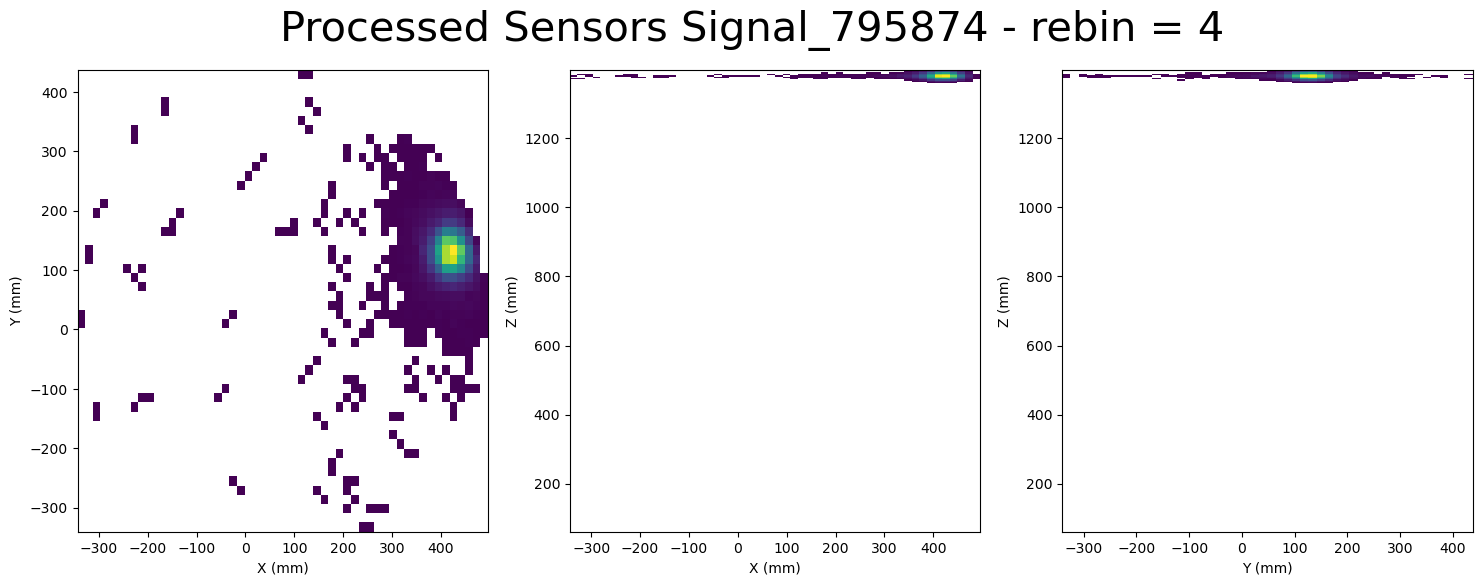

EVENT 907384
Total energy 1.85 MeV

Time spent in cut_over_Q: 0.03253340721130371 s
Time spent in drop_isolated: 0.03634071350097656 s


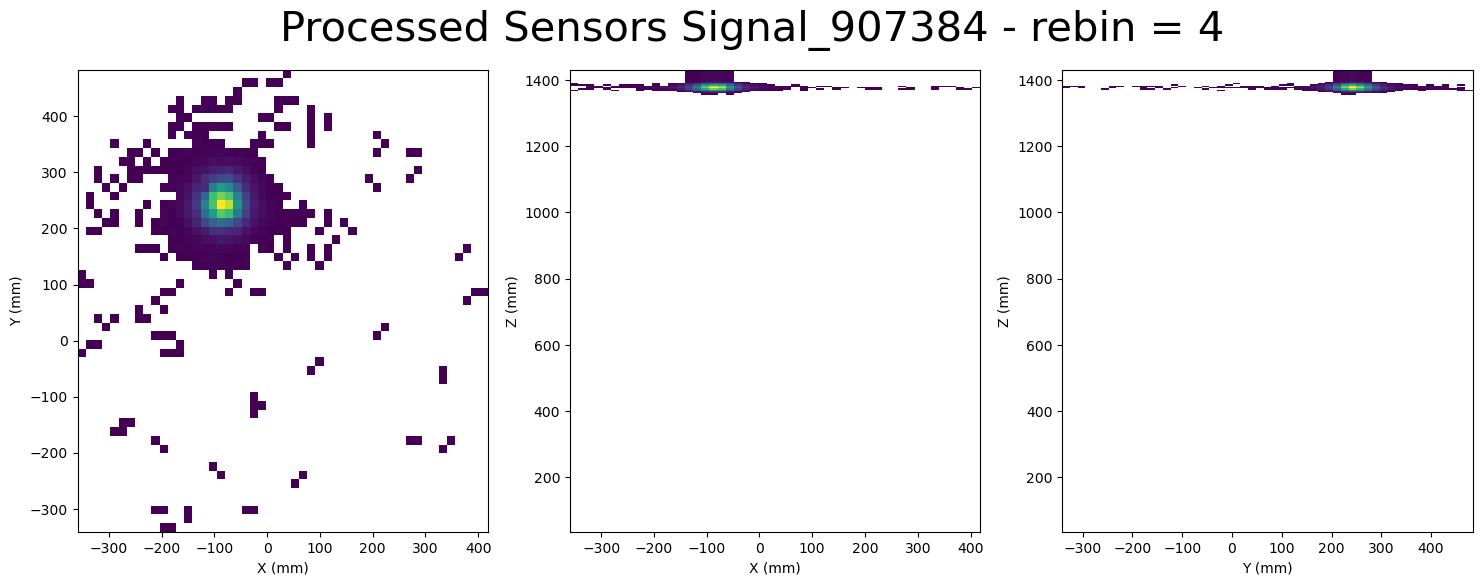

EVENT 648419
Total energy 2.99 MeV

Time spent in cut_over_Q: 0.015062332153320312 s
Time spent in drop_isolated: 0.11201310157775879 s


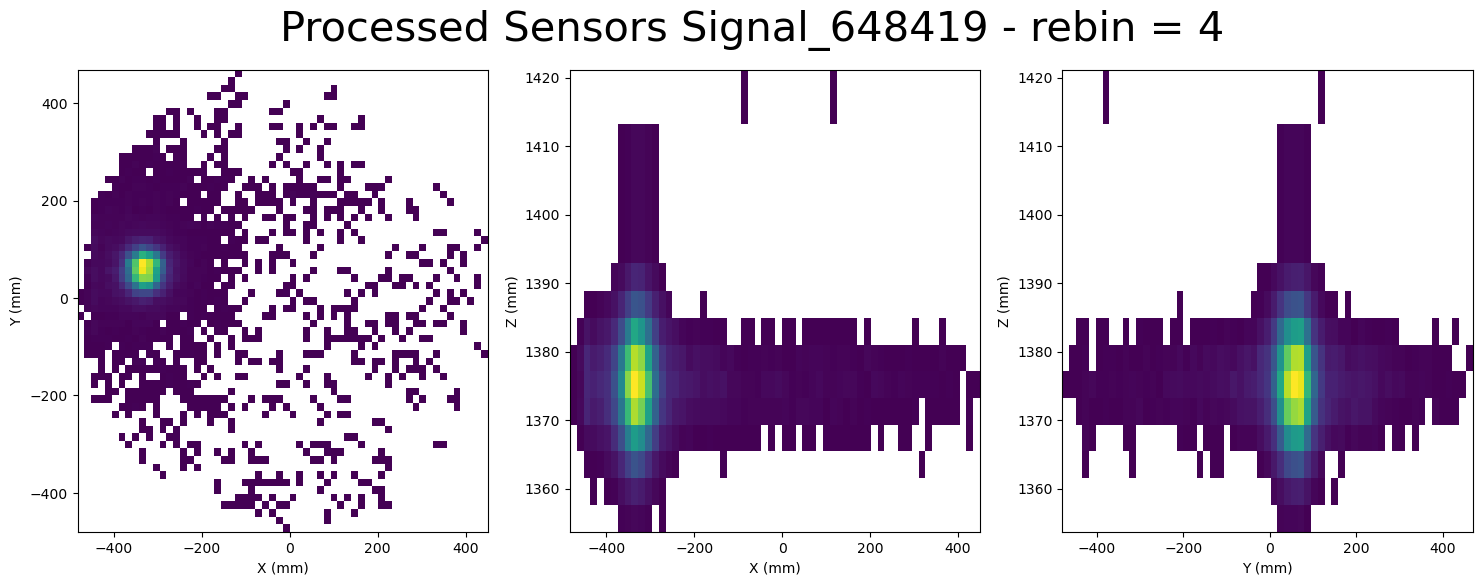

EVENT 835137
Total energy 2.20 MeV

Time spent in cut_over_Q: 0.015210390090942383 s
Time spent in drop_isolated: 0.03963756561279297 s


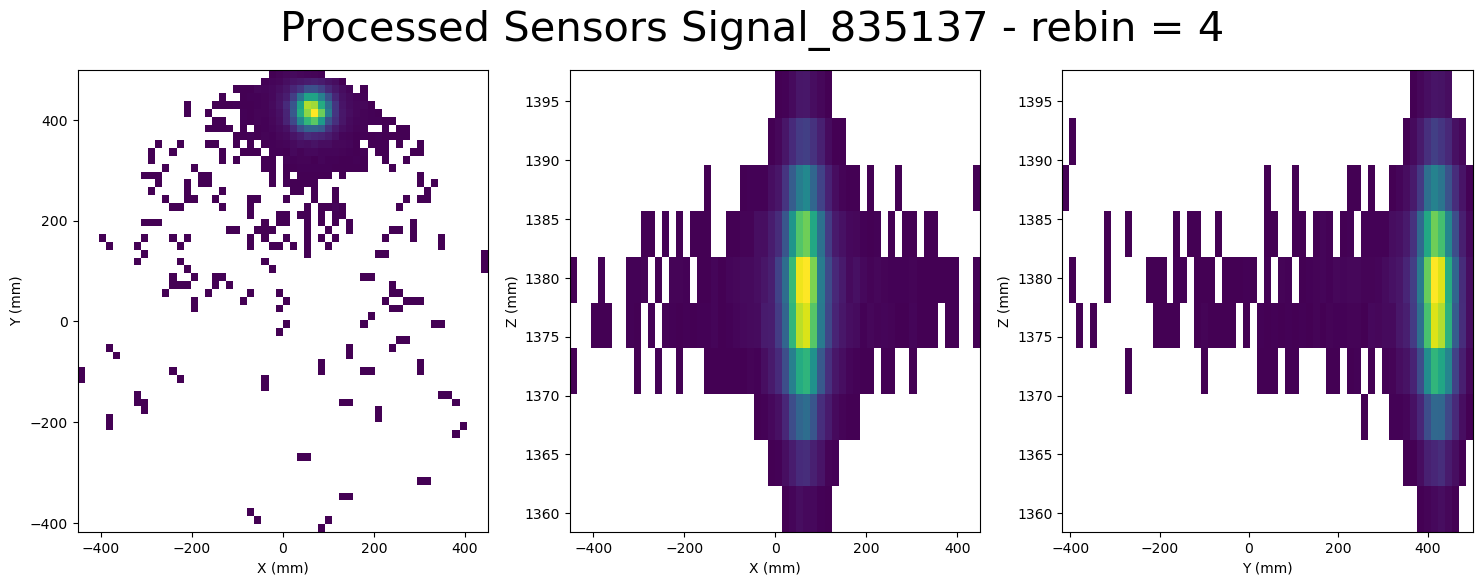

EVENT 411161
Total energy 2.63 MeV

Time spent in cut_over_Q: 0.012381792068481445 s
Time spent in drop_isolated: 0.06604719161987305 s


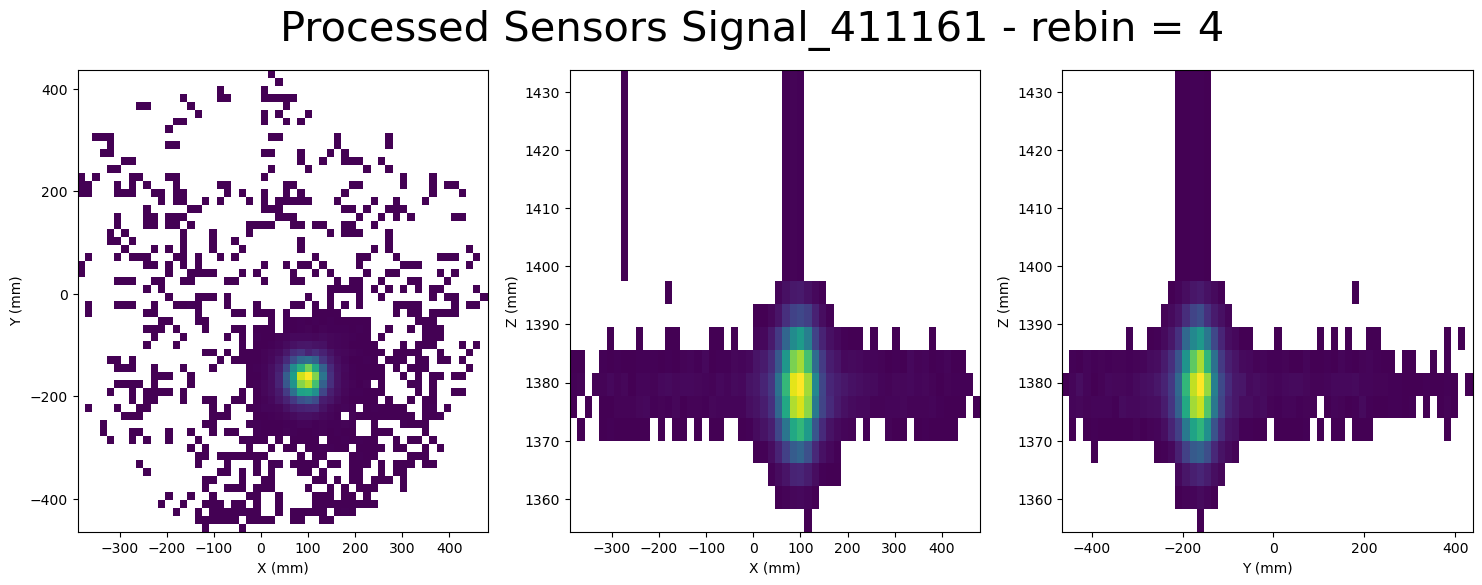

EVENT 1106989
Total energy 1.68 MeV

Time spent in cut_over_Q: 0.018599271774291992 s
Time spent in drop_isolated: 0.02092599868774414 s


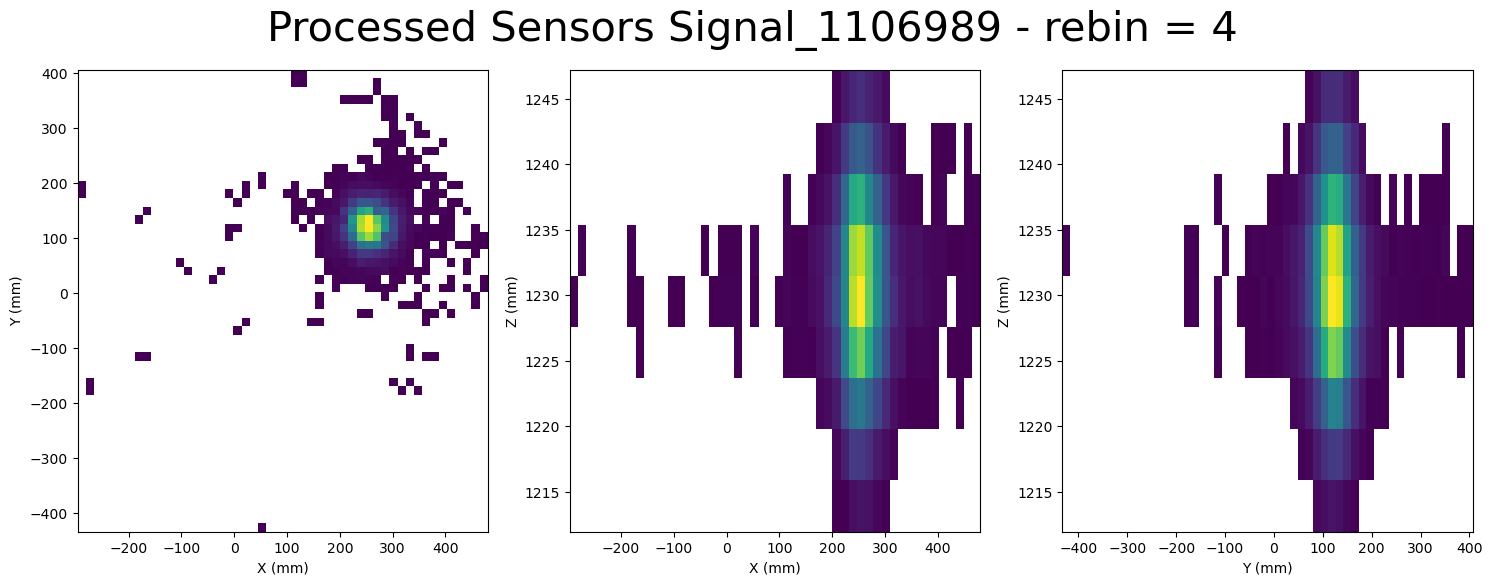

EVENT 1333404
Total energy 1.65 MeV

Time spent in cut_over_Q: 0.02153158187866211 s
Time spent in drop_isolated: 0.02706432342529297 s


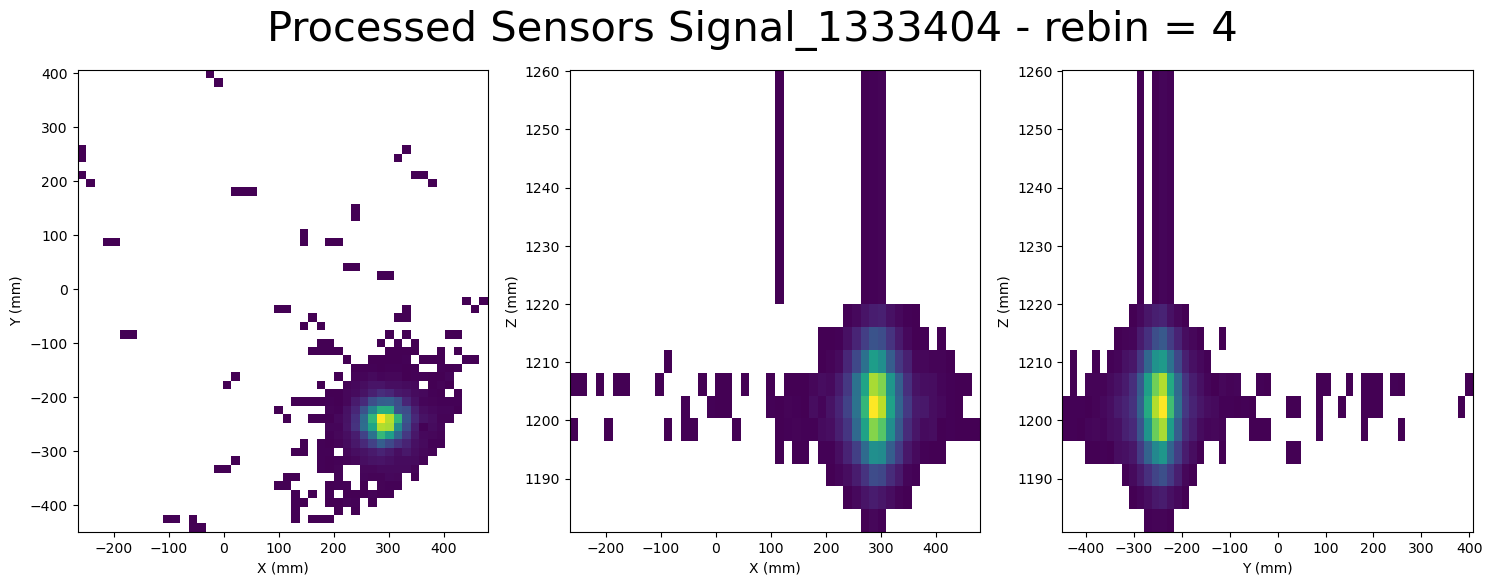

EVENT 1269186
Total energy 3.13 MeV

Time spent in cut_over_Q: 0.0214846134185791 s
Time spent in drop_isolated: 0.17218255996704102 s


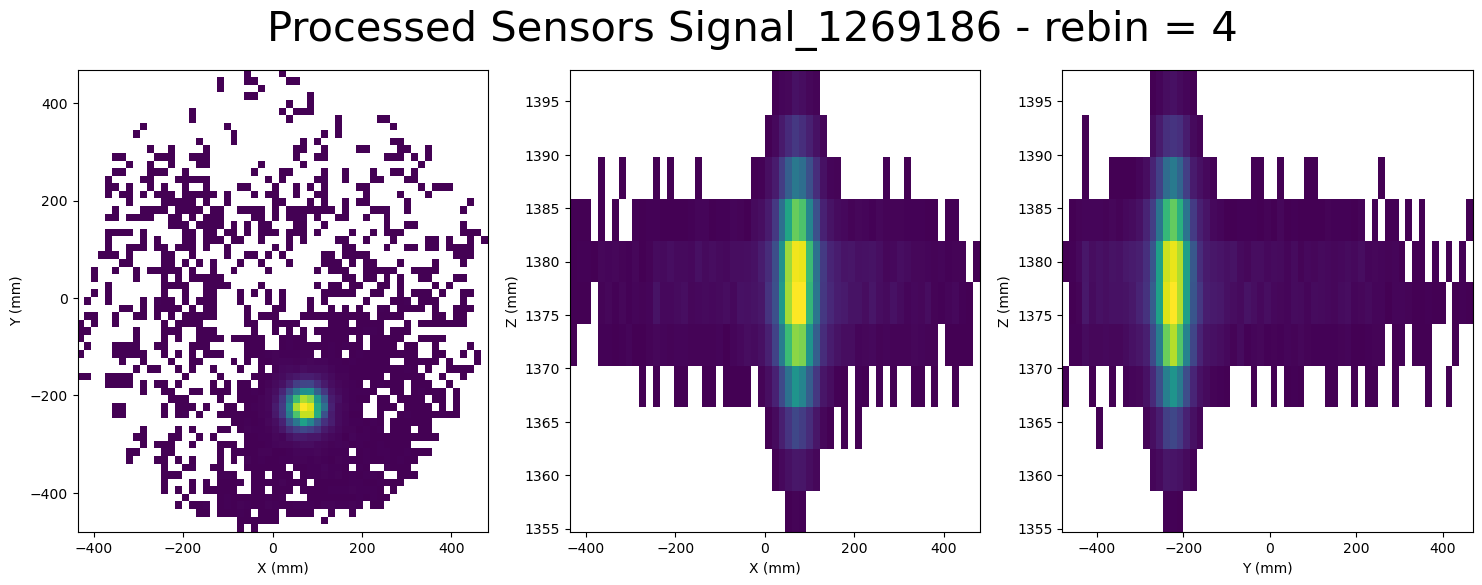

EVENT 1536439
Total energy 2.33 MeV

Time spent in cut_over_Q: 0.014678239822387695 s
Time spent in drop_isolated: 0.0651693344116211 s


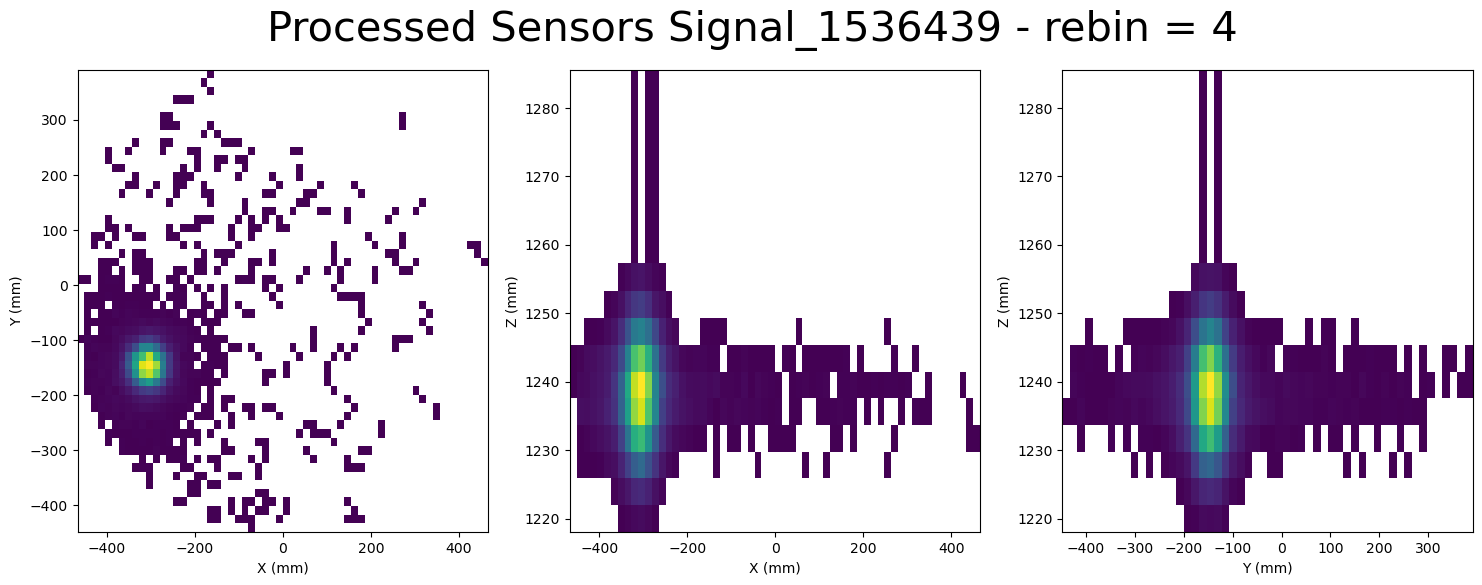

EVENT 151468
Total energy 1.83 MeV

Time spent in cut_over_Q: 0.018456220626831055 s
Time spent in drop_isolated: 0.03747153282165527 s


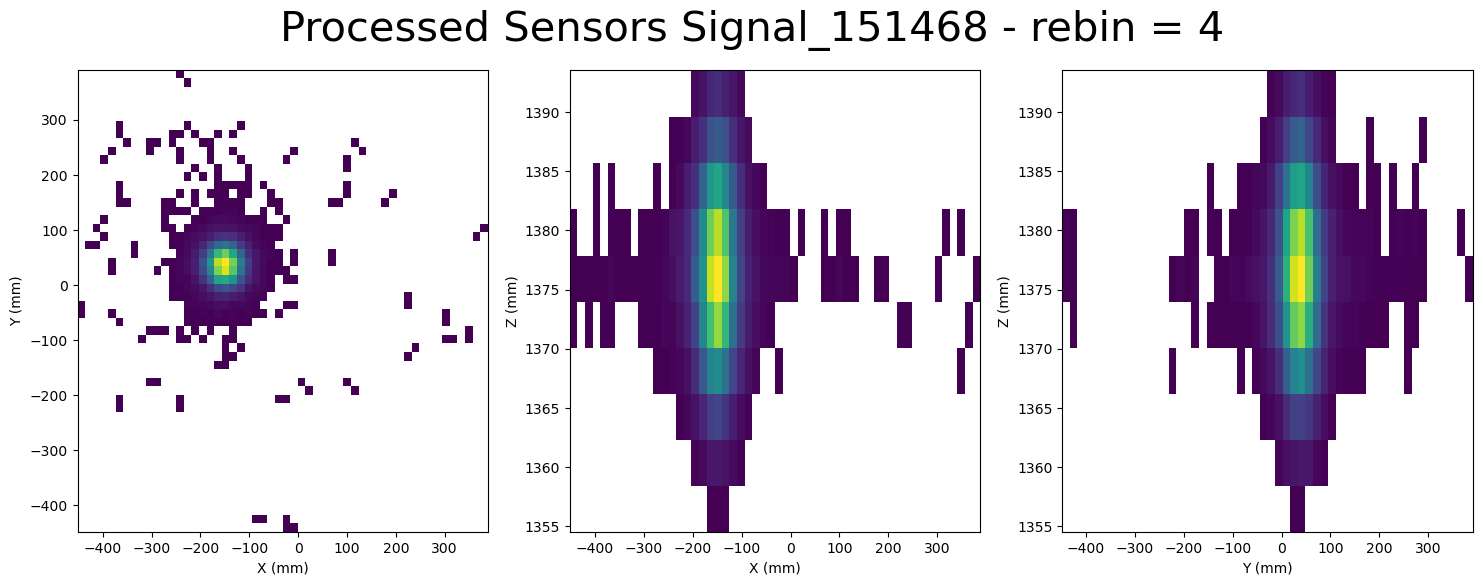

EVENT 1344716
Total energy 2.64 MeV

Time spent in cut_over_Q: 0.012596607208251953 s
Time spent in drop_isolated: 0.12183713912963867 s


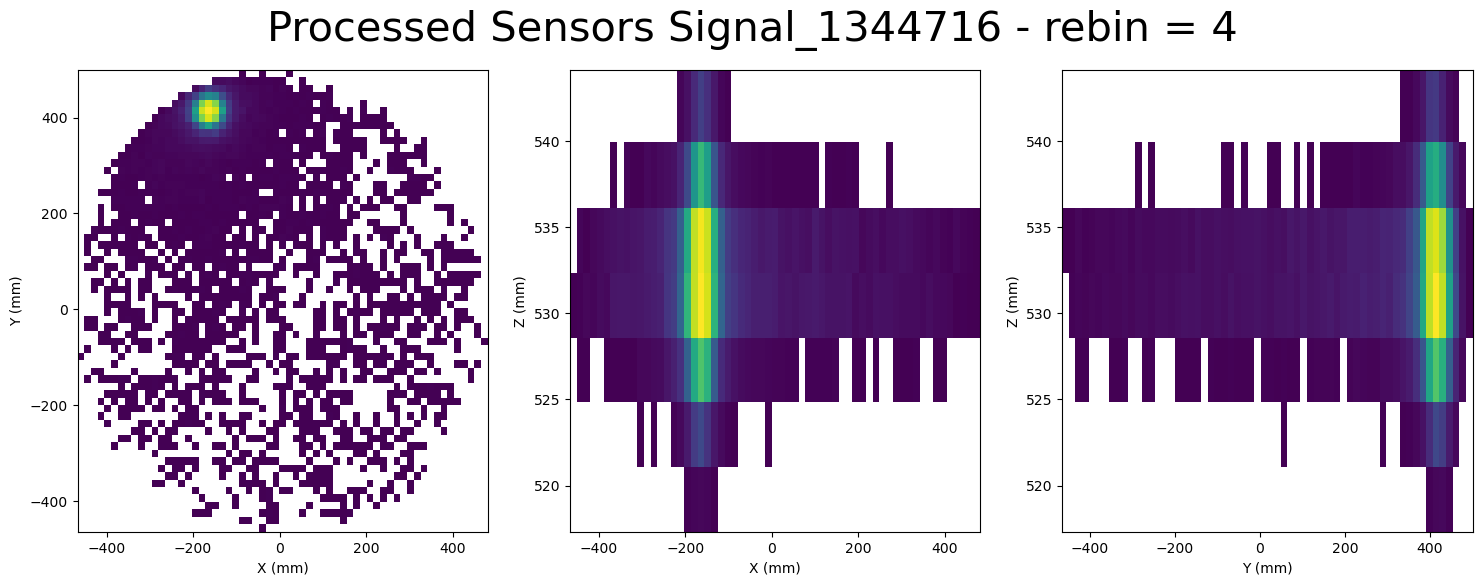

EVENT 686702
Total energy 2.63 MeV

Time spent in cut_over_Q: 0.012899160385131836 s
Time spent in drop_isolated: 0.06455349922180176 s


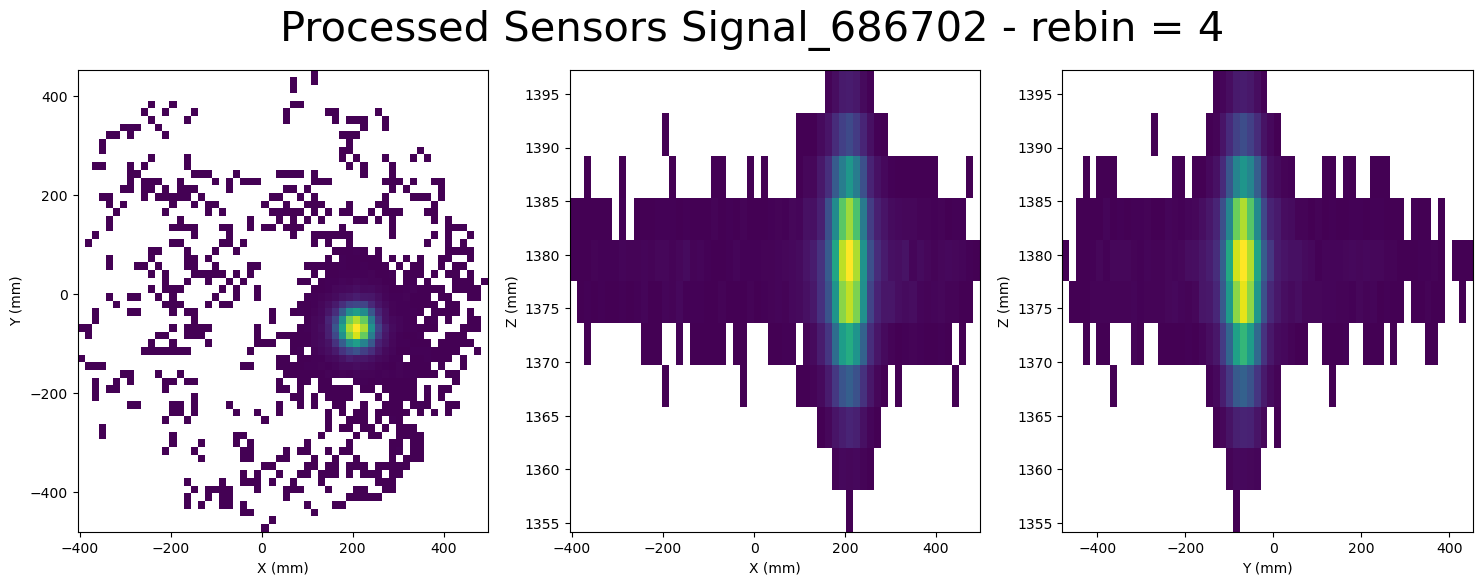

EVENT 436746
Total energy 2.37 MeV

Time spent in cut_over_Q: 0.010956287384033203 s
Time spent in drop_isolated: 0.03197002410888672 s


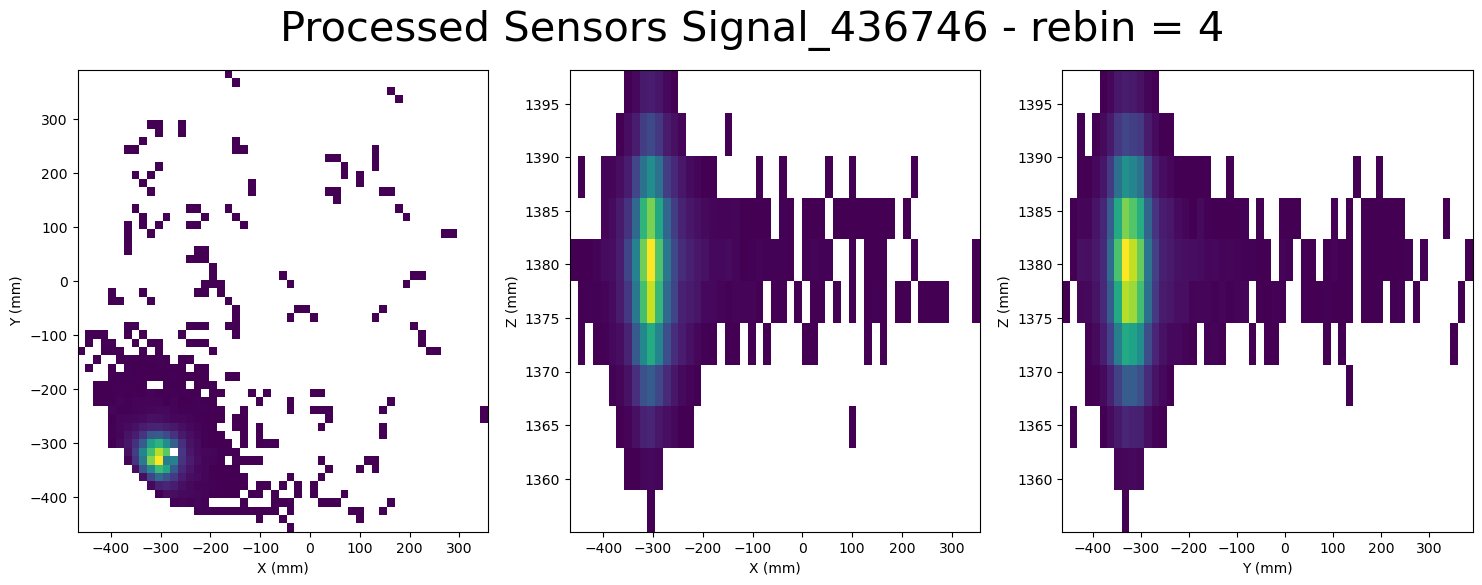

EVENT 223834
Total energy 3.11 MeV

Time spent in cut_over_Q: 0.018287181854248047 s
Time spent in drop_isolated: 0.23999547958374023 s


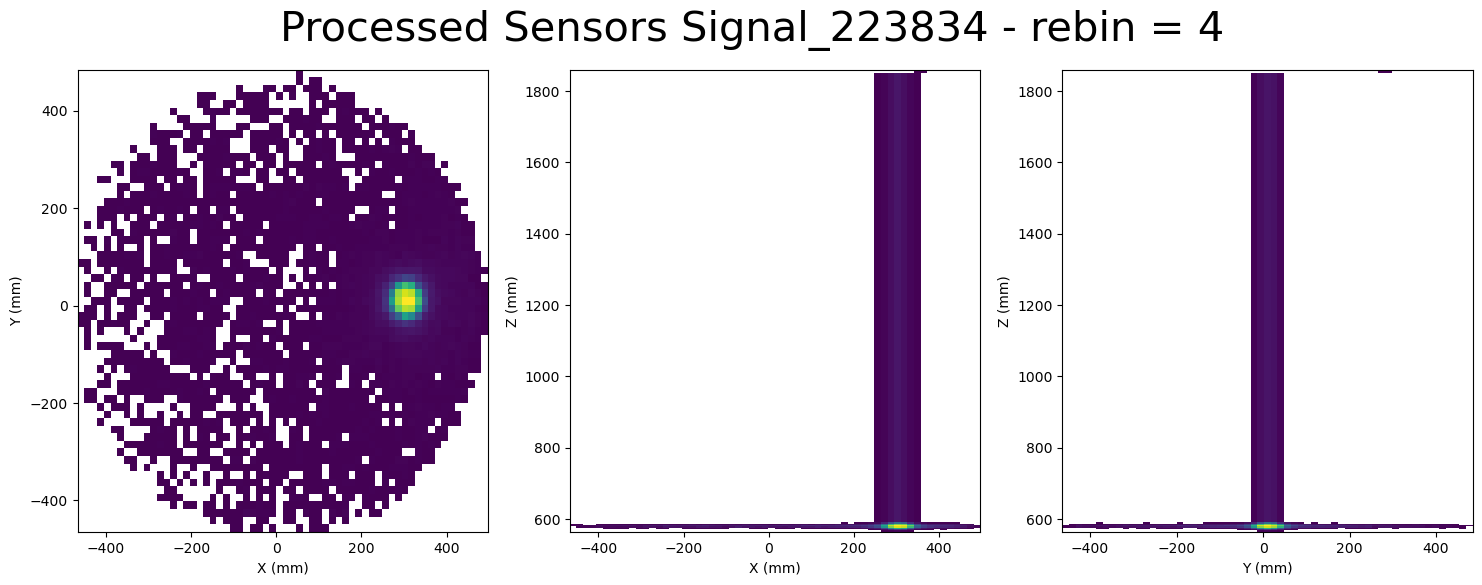

EVENT 961158
Total energy 3.63 MeV

Time spent in cut_over_Q: 0.012684106826782227 s
Time spent in drop_isolated: 0.202714204788208 s


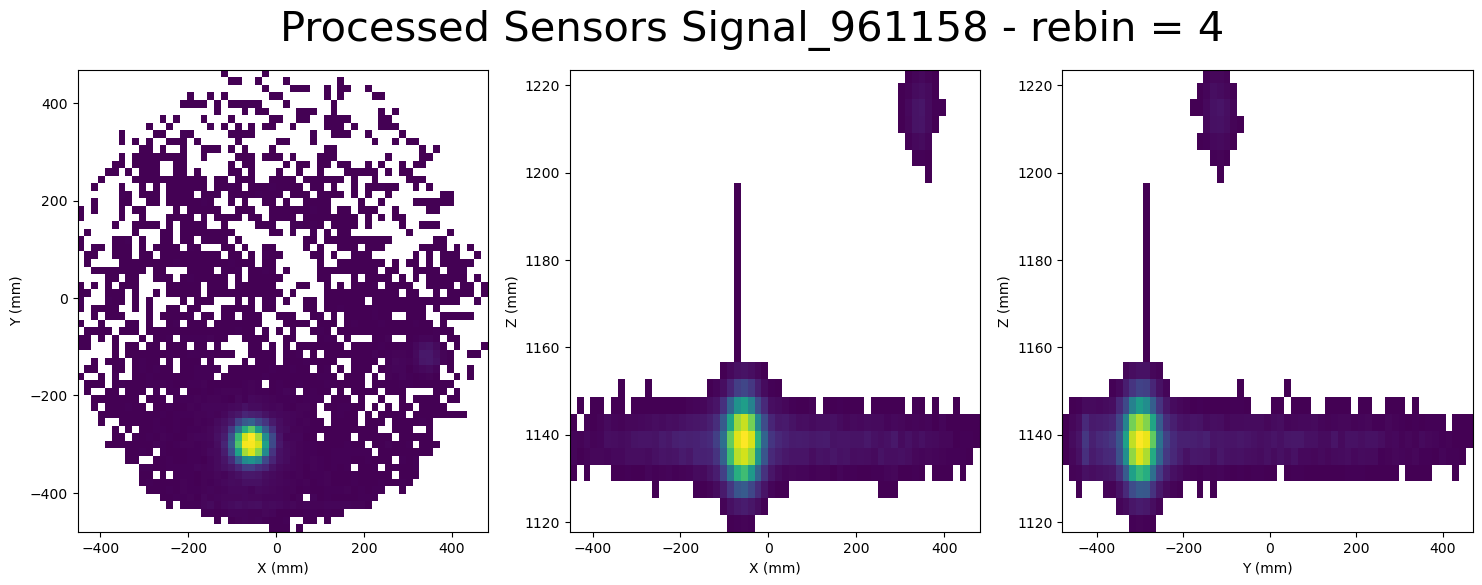

EVENT 281241
Total energy 2.88 MeV

Time spent in cut_over_Q: 0.01108241081237793 s
Time spent in drop_isolated: 0.07316970825195312 s


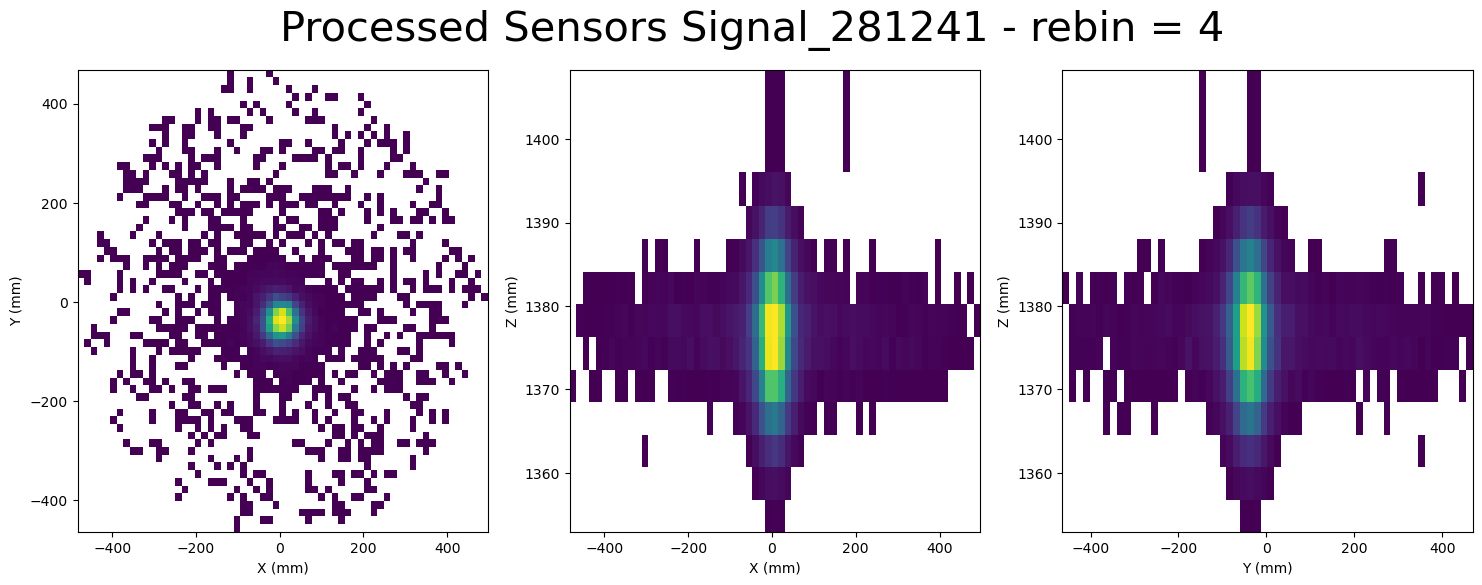

EVENT 643512
Total energy 3.57 MeV

Time spent in cut_over_Q: 0.011713743209838867 s
Time spent in drop_isolated: 0.1749286651611328 s


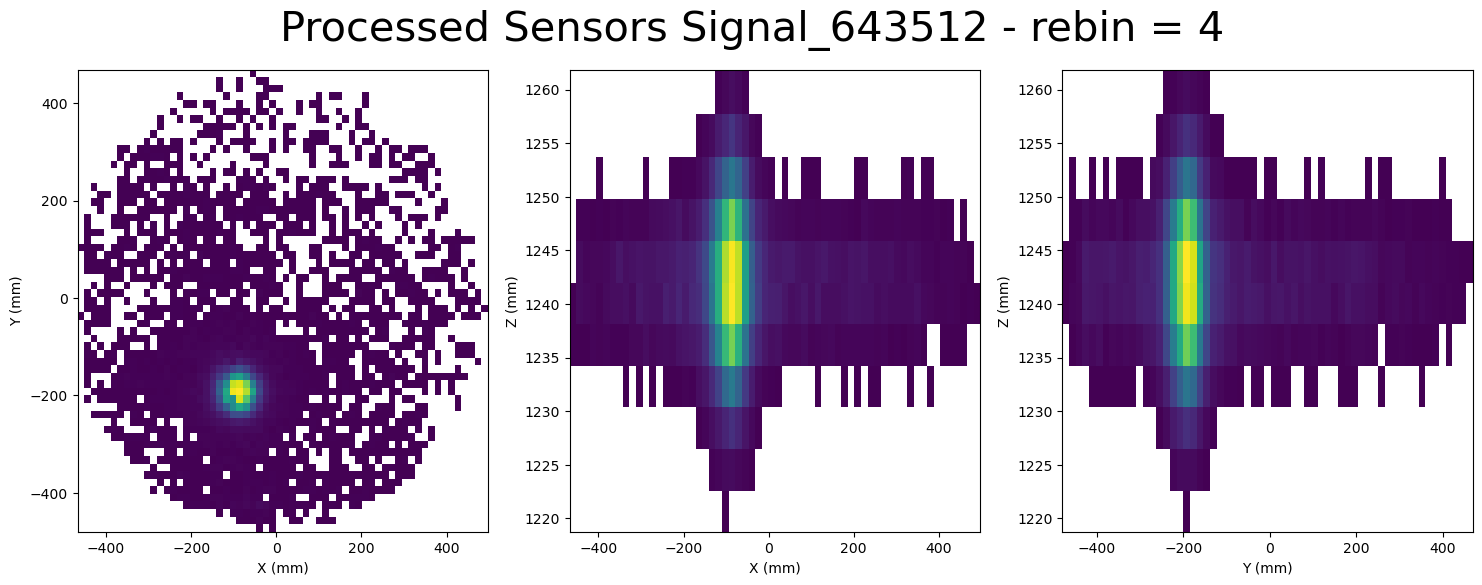

EVENT 1165670
Total energy 3.38 MeV

Time spent in cut_over_Q: 0.011387109756469727 s
Time spent in drop_isolated: 0.11671733856201172 s


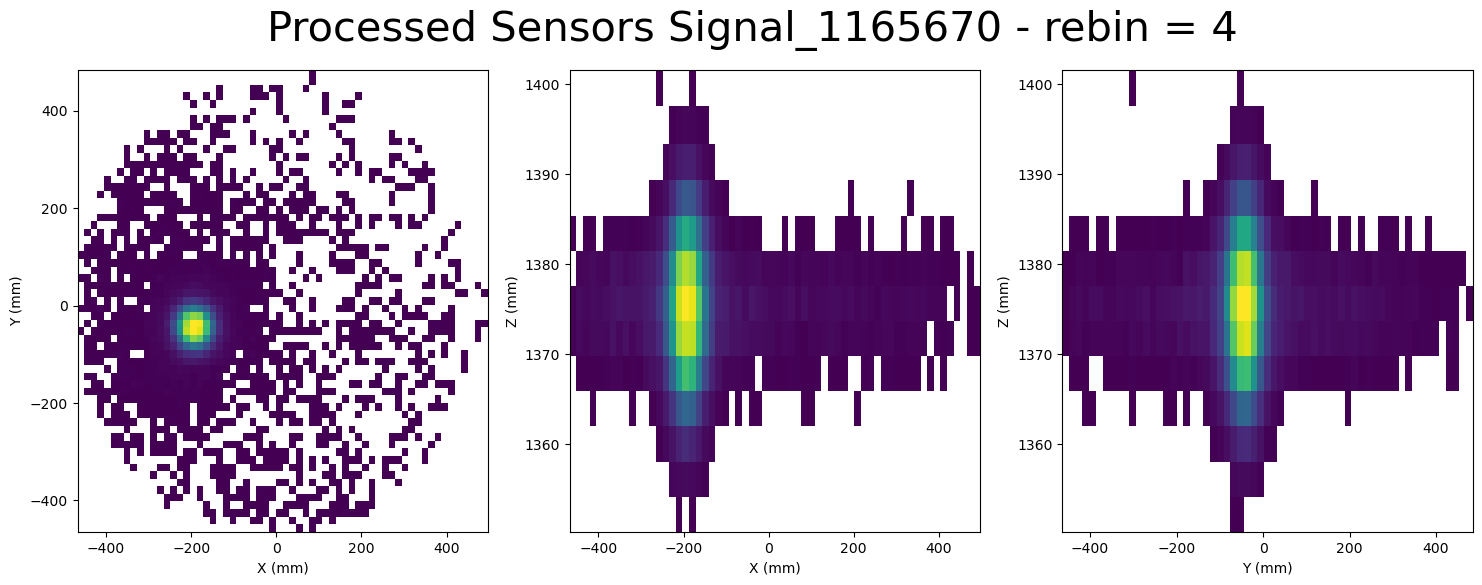

EVENT 1107913
Total energy 1.65 MeV

Time spent in cut_over_Q: 0.016835927963256836 s
Time spent in drop_isolated: 0.021596431732177734 s


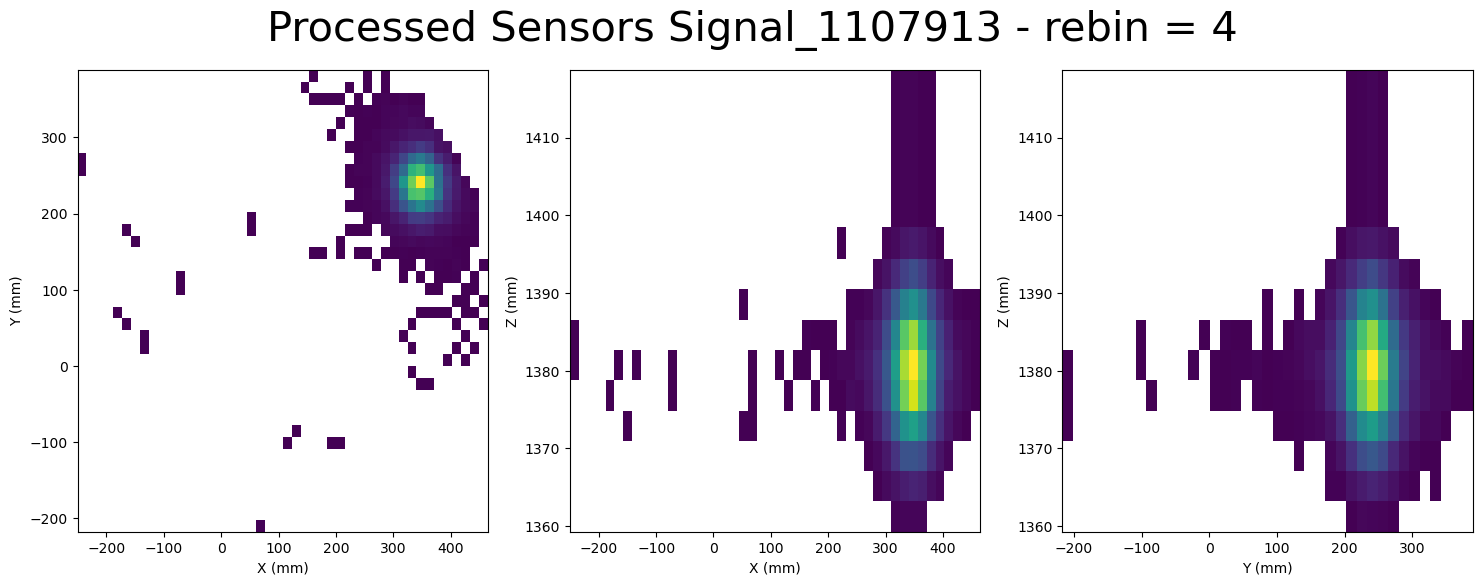

EVENT 1343106
Total energy 1.83 MeV

Time spent in cut_over_Q: 0.014078378677368164 s
Time spent in drop_isolated: 0.08908915519714355 s


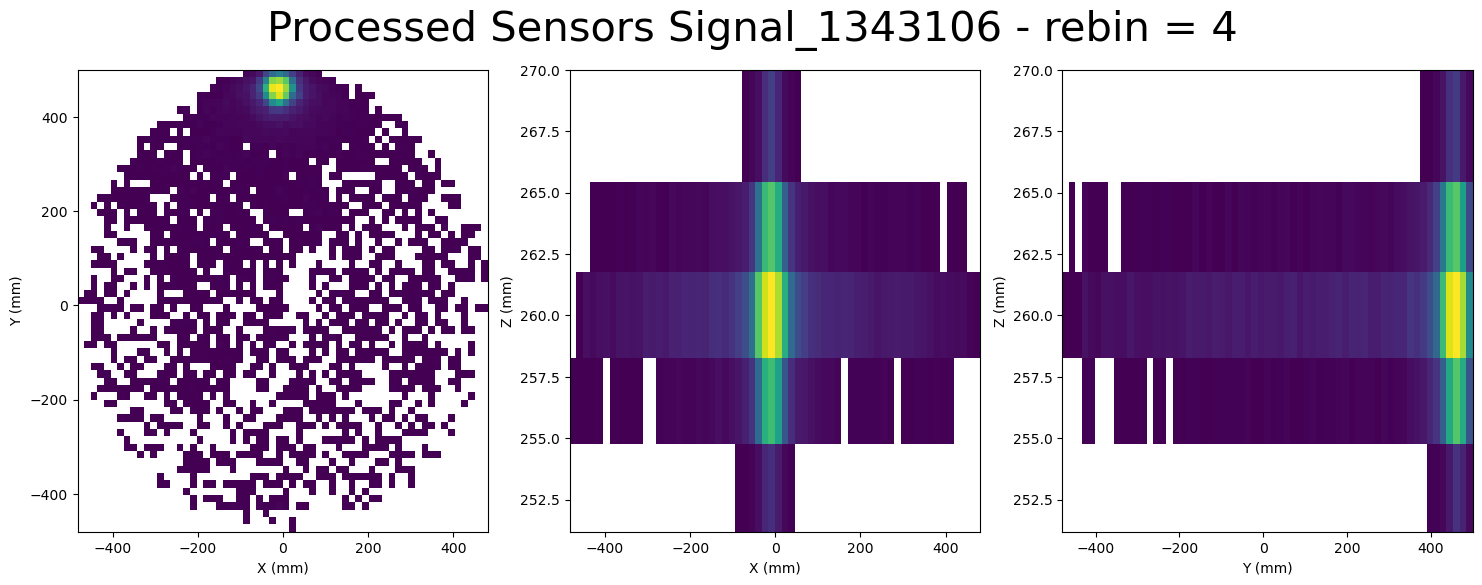

EVENT 1541248
Total energy 2.45 MeV

Time spent in cut_over_Q: 0.011094808578491211 s
Time spent in drop_isolated: 0.07149529457092285 s


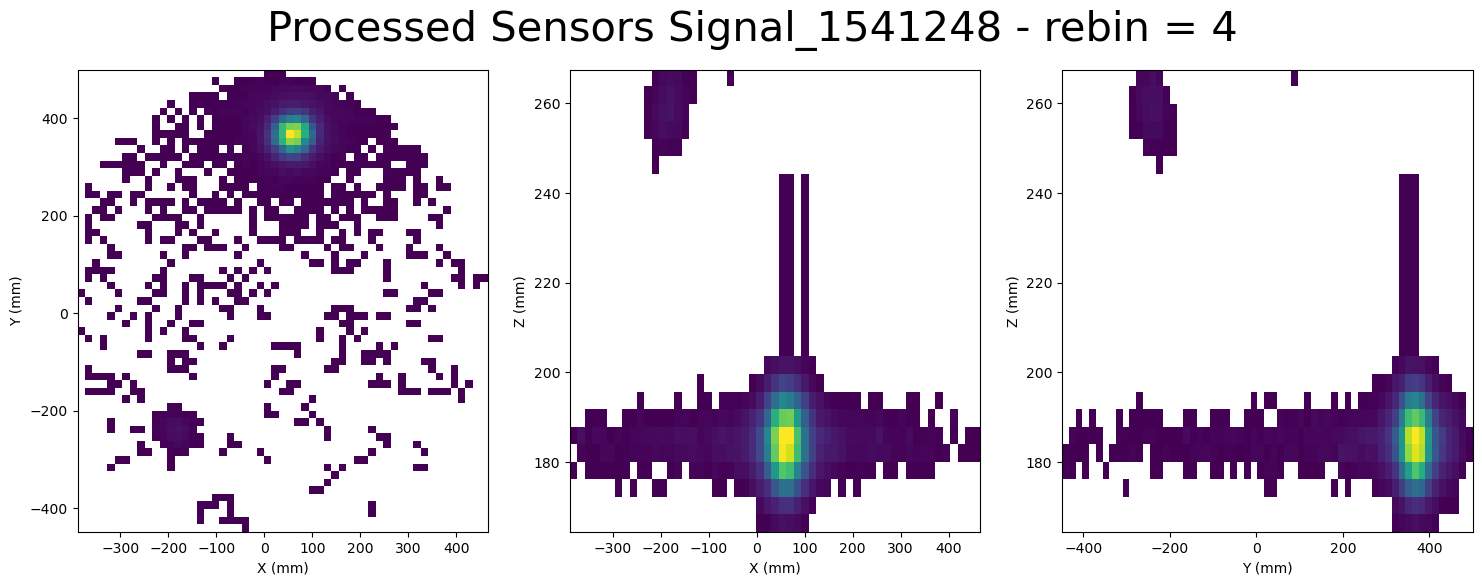

EVENT 267444
Total energy 3.52 MeV

Time spent in cut_over_Q: 0.011530637741088867 s
Time spent in drop_isolated: 0.16745543479919434 s


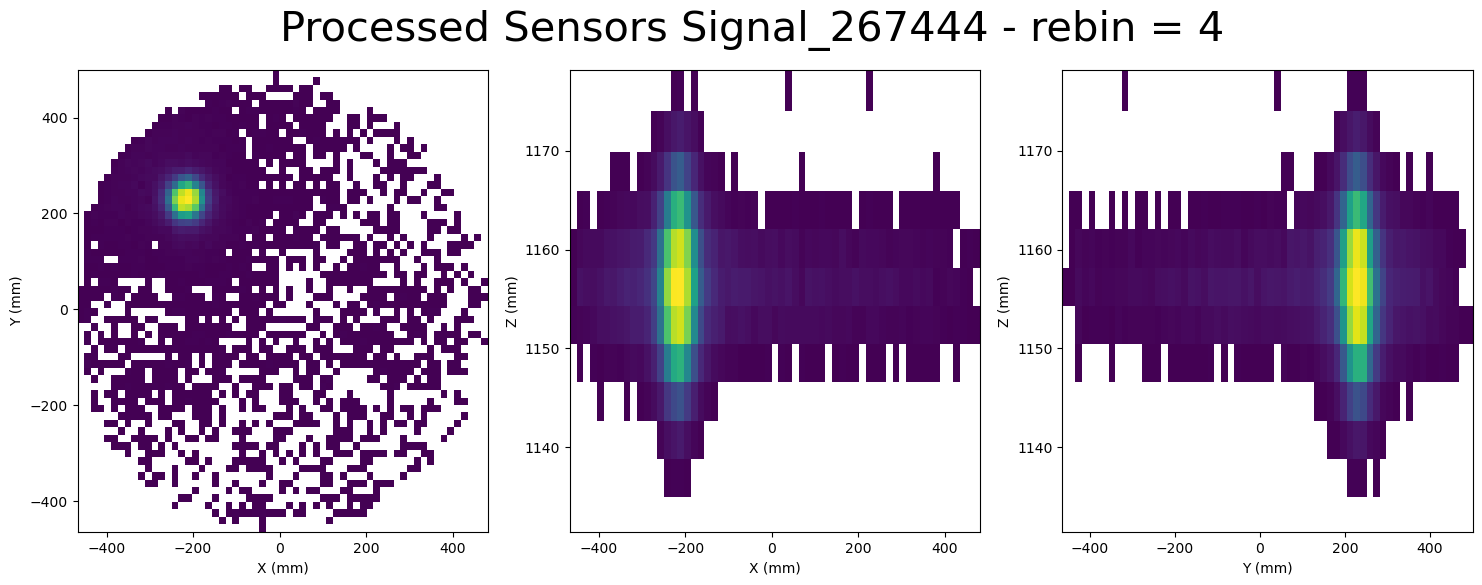

In [10]:
stopper = 20
for i, ev in enumerate(evts):
    plotter(uncorr_high_E, ev)
    if i > stopper:
        break

event          time  npeak       Xpeak      Ypeak  nsipm        X  \
597805    795874  1.742945e+09      0    0.333168 -28.804034      1 -373.775   
597806    795874  1.742945e+09      0    0.333168 -28.804034      1 -281.475   
597807    795874  1.742945e+09      0    0.333168 -28.804034      1 -343.675   
597808    795874  1.742945e+09      0    0.333168 -28.804034      1 -158.075   
597809    795874  1.742945e+09      0    0.333168 -28.804034      1   73.175   
...          ...           ...    ...         ...        ...    ...      ...   
30581150  378440  1.742940e+09      5 -133.875266  45.339055      1 -112.425   
30581151  378440  1.742940e+09      5 -133.875266  45.339055      1   42.075   
30581152  378440  1.742940e+09      5 -133.875266  45.339055      1  335.525   
30581153  378440  1.742940e+09      5 -133.875266  45.339055      1  474.475   
30581154  378440  1.742940e+09      5 -133.875266  45.339055      1  119.825   

                Y  Xrms  Yrms            Z         Q         E   Qc        Ec  \
597805    229.875   0.0   0.0    10.675418  5.922611  2.788613 -1.0  0.000008   
597806   -201.525   0.0   0.0    10.675418  5.151953  2.425755 -1.0  0.000007   
597807    260.975   0.0   0.0    10.675418  5.264871  2.478921 -1.0  0.000007   
597808    414.975   0.0   0.0    10.675418  8.009684  3.771294 -1.0  0.000012   
597809   -479.925   0.0   0.0    10.675418  6.136306  2.889230 -1.0       NaN   
...           ...   ...   ...          ...       ...       ...  ...       ...   
30581150 -109.725   0.0   0.0  1300.347375  5.605568  7.969570 -1.0  0.000024   
30581151  477.175   0.0   0.0  1300.347375  5.486984  7.800976 -1.0       NaN   
30581152  184.225   0.0   0.0  1300.347375  5.116071  7.273640 -1.0  0.000023   
30581153 -140.325   0.0   0.0  1300.347375  6.349767  9.027615 -1.0       NaN   
30581154  461.625   0.0   0.0  1303.164250  7.301188  8.325317 -1.0  0.000027   

          track_id   Ep  
597805          -1 -1.0  
597806          -1 -1.0  
597807          -1 -1.0  
597808          -1 -1.0  
597809          -1 -1.0  
...            ...  ...  
30581150        -1 -1.0  
30581151        -1 -1.0  
30581152        -1 -1.0  
30581153        -1 -1.0  
30581154        -1 -1.0  

[2002688 rows x 17 columns]

Index(['event', 'time', 'npeak', 'Xpeak', 'Ypeak', 'nsipm', 'X', 'Y', 'Xrms',
       'Yrms', 'Z', 'Q', 'E', 'Qc', 'Ec', 'track_id', 'Ep'],
      dtype='object')


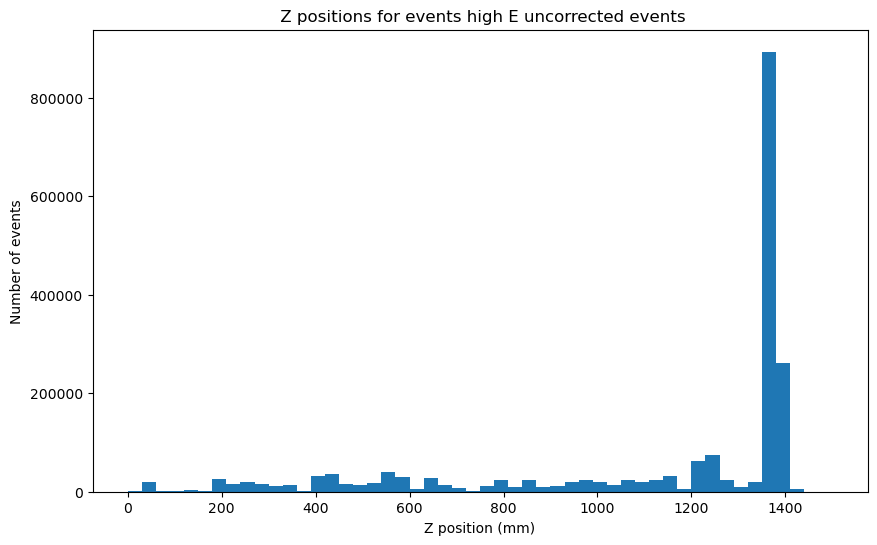

In [26]:
display(uncorr_high_E)
print(uncorr_high_E.columns)
# plot histogram of average Z position grouped by event
plt.figure(figsize=(10, 6))
plt.hist(uncorr_high_E.Z.values, bins=50, range = [0, 1500])
plt.title(' Z positions for events high E uncorrected events')
plt.xlabel('Z position (mm)')
plt.ylabel('Number of events')
plt.show()

# Post "compton edge"
are these the same events?

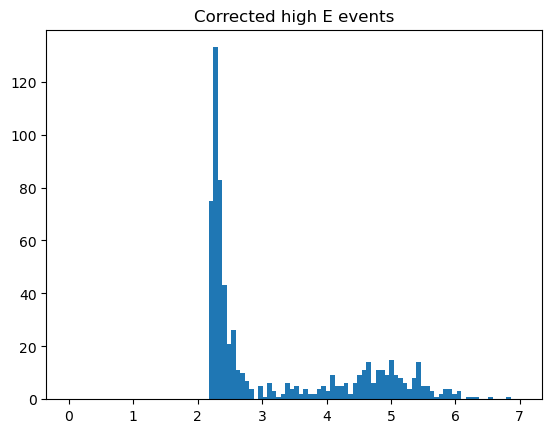

In [3]:
folder_path = 'files/15107_energy_split/'
corr_post_CE = pd.read_hdf(folder_path + 'corr_post_CE.h5', 'RECO/Events')

plt.hist(corr_post_CE.groupby('event').Ec.sum(), bins = 100, range = [0, 7])
plt.title('Corrected high E events')
plt.show()

In [4]:
CE_evts = corr_post_CE.event.unique()

stopper = 20
for i, ev in enumerate(CE_evts):
    plotter(corr_post_CE, ev)
    if i > stopper:
        break

NameError: name 'plotter' is not defined

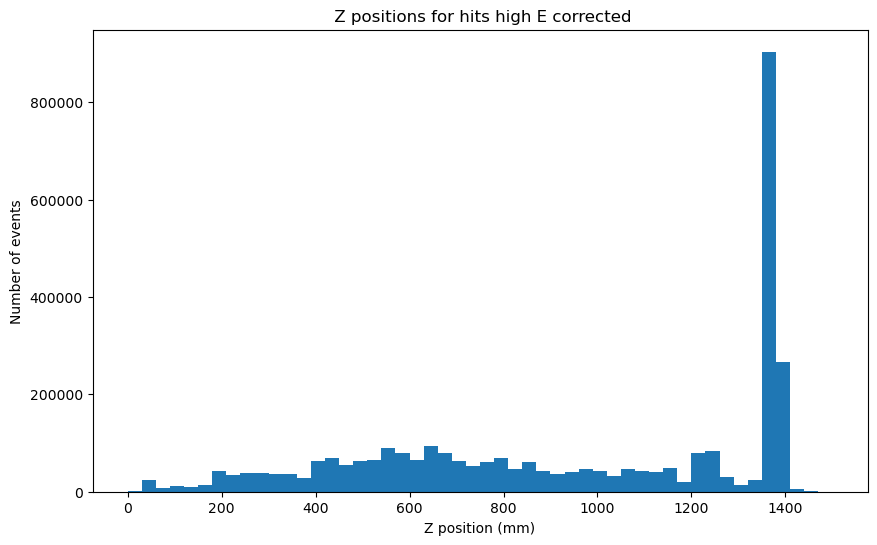

In [48]:

# plot histogram of average Z position grouped by event
plt.figure(figsize=(10, 6))
plt.hist(corr_post_CE.Z.values, bins=50, range = [0, 1500])
plt.title(' Z positions for hits high E corrected')
plt.xlabel('Z position (mm)')
plt.ylabel('Number of events')
plt.show()


Z        Ec
event                         
1886      769.671419  2.240791
2767      652.099980  2.284575
6599      933.171158  2.394683
6769     1373.900240  4.816332
8396      675.465423  2.281451
...              ...       ...
1531752   743.132124  2.459406
1532410   284.723084  5.216292
1535725   601.161551  2.221923
1536439  1236.630133  3.827846
1541248   185.182061  4.582260

[670 rows x 2 columns]

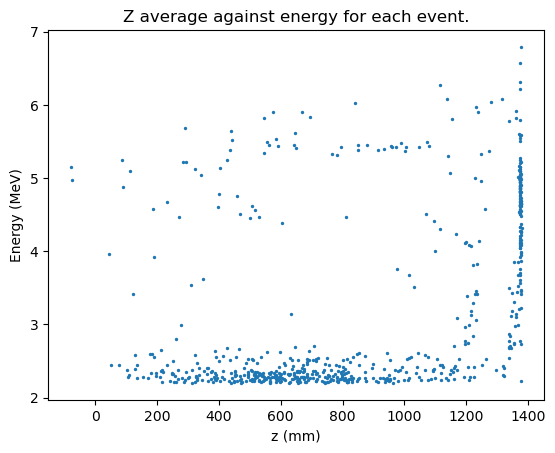

In [63]:
z_av_e_sum = corr_post_CE.groupby('event').agg({'Z':'mean', 'Ec': 'sum'})
display(z_av_e_sum)
plt.scatter(z_av_e_sum.Z.values, z_av_e_sum.Ec.values, s = 2)
plt.title('Z average against energy for each event.')
plt.xlabel('z (mm)')
plt.ylabel('Energy (MeV)')
plt.show()

### so lets force a restriction on events to be less than z < 1300

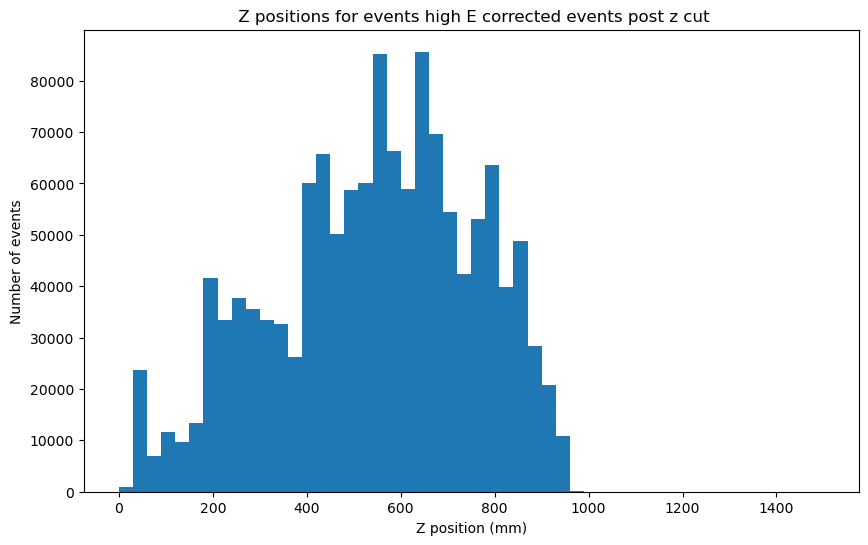

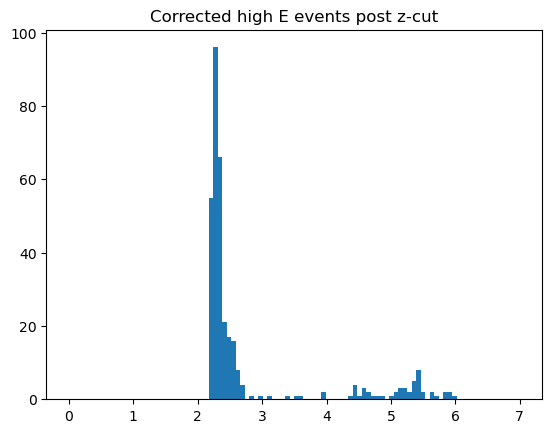

In [50]:
z_flag = corr_post_CE[corr_post_CE.Z > 1000].event.unique()
#display(z_flag)
low_z_events = corr_post_CE[~corr_post_CE.event.isin(z_flag)]

plt.figure(figsize=(10, 6))
plt.hist(low_z_events.Z.values, bins=50, range = [0, 1500])
plt.title(' Z positions for events high E corrected events post z cut')
plt.xlabel('Z position (mm)')
plt.ylabel('Number of events')
plt.show()


plt.hist(low_z_events.groupby('event').Ec.sum(), bins = 100, range = [0, 7])
plt.title('Corrected high E events post z-cut')
plt.show()

EVENT 1139700
Total energy 2.29 MeV

Time spent in cut_over_Q: 0.055675506591796875 s
Time spent in drop_isolated: 0.08957052230834961 s


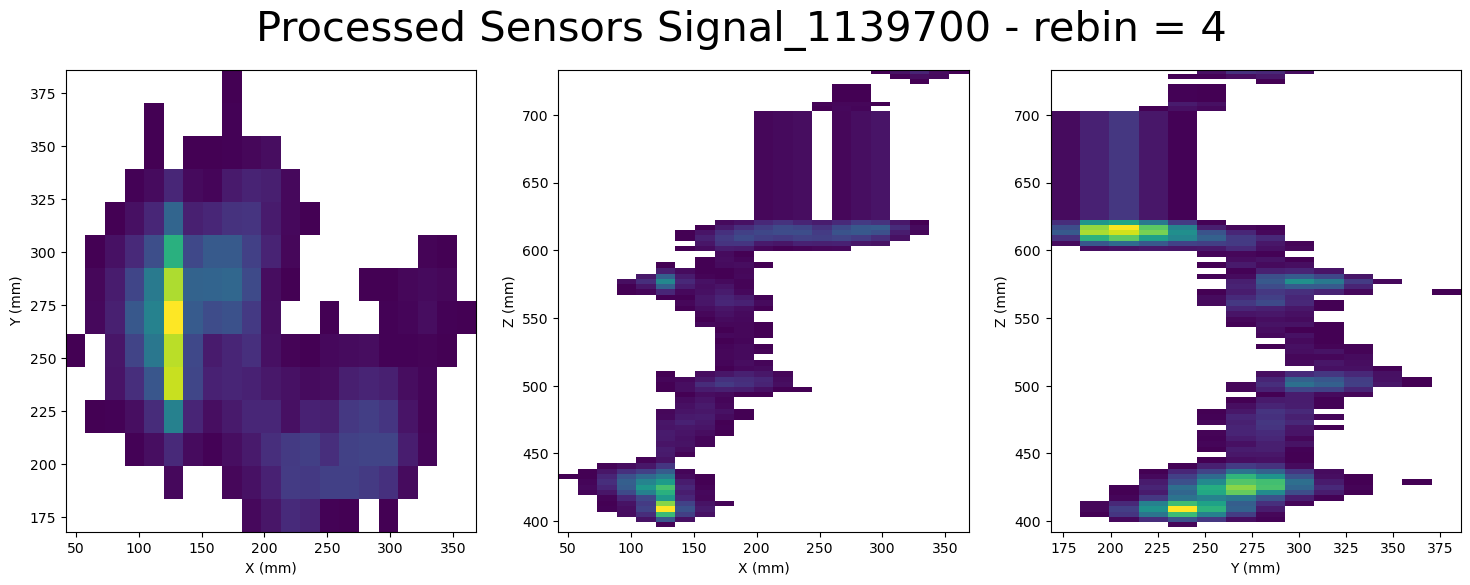

EVENT 654754
Total energy 2.40 MeV

Time spent in cut_over_Q: 0.018439054489135742 s
Time spent in drop_isolated: 0.06423640251159668 s


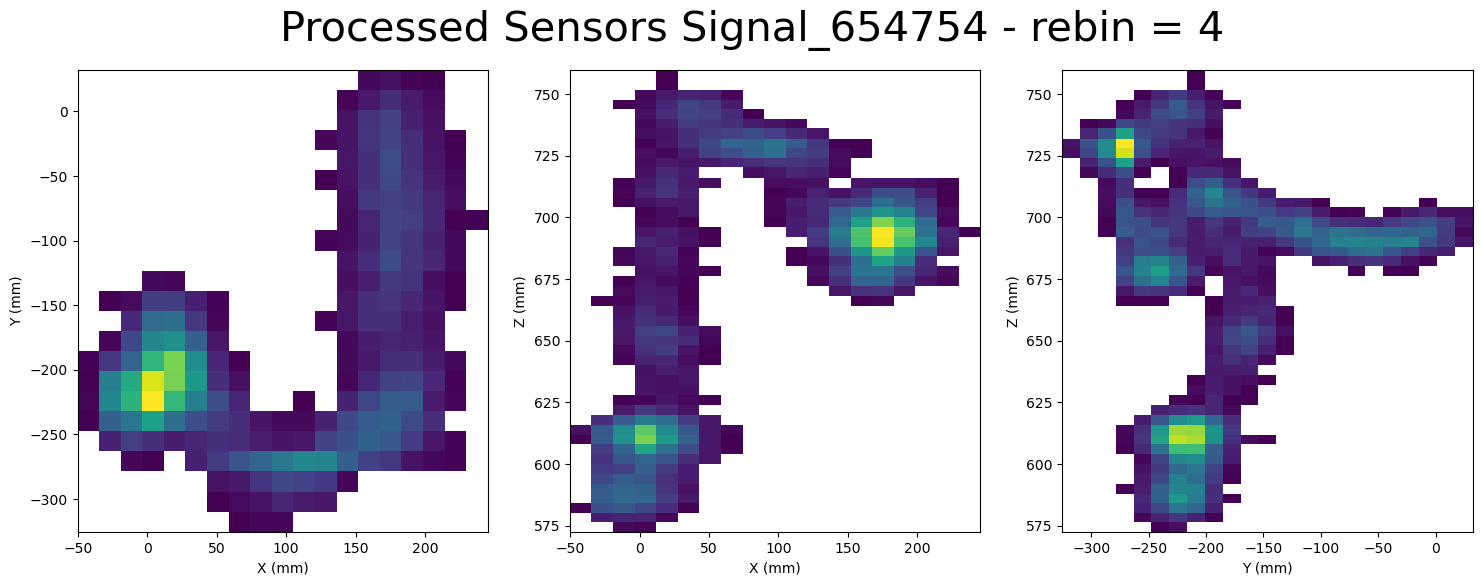

EVENT 1496623
Total energy 2.34 MeV

Time spent in cut_over_Q: 0.015939712524414062 s
Time spent in drop_isolated: 0.06139826774597168 s


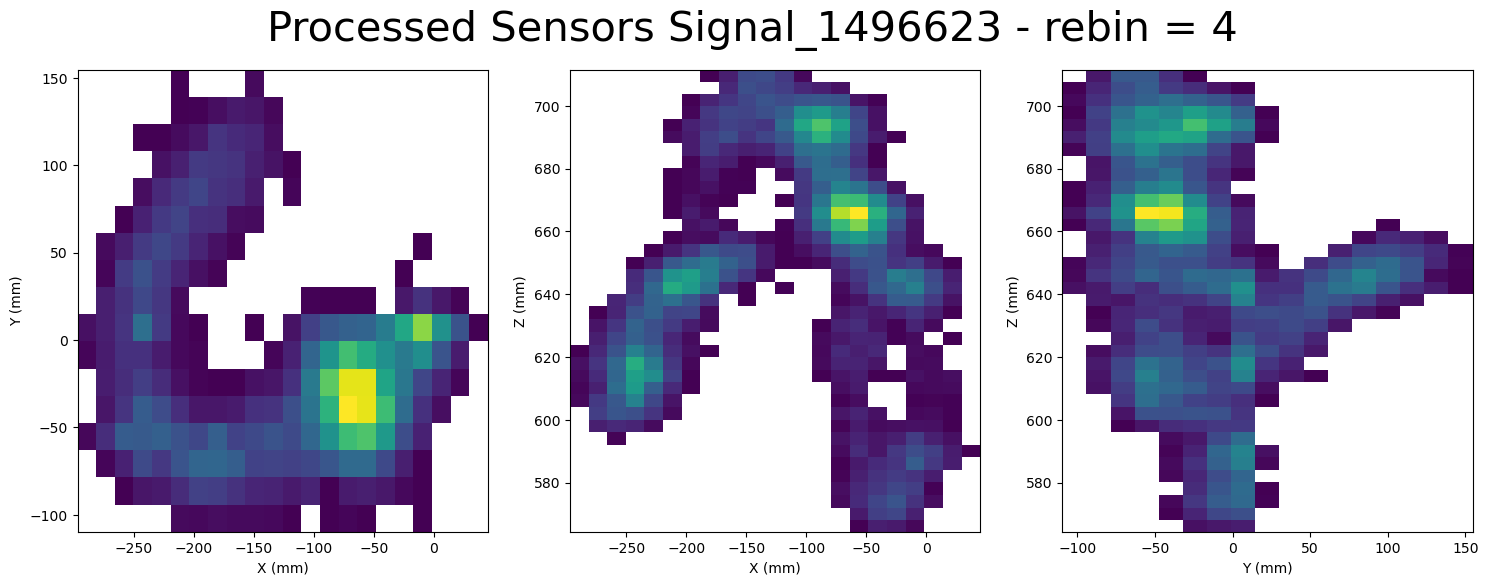

EVENT 521418
Total energy 2.24 MeV

Time spent in cut_over_Q: 0.014801263809204102 s
Time spent in drop_isolated: 0.05267739295959473 s


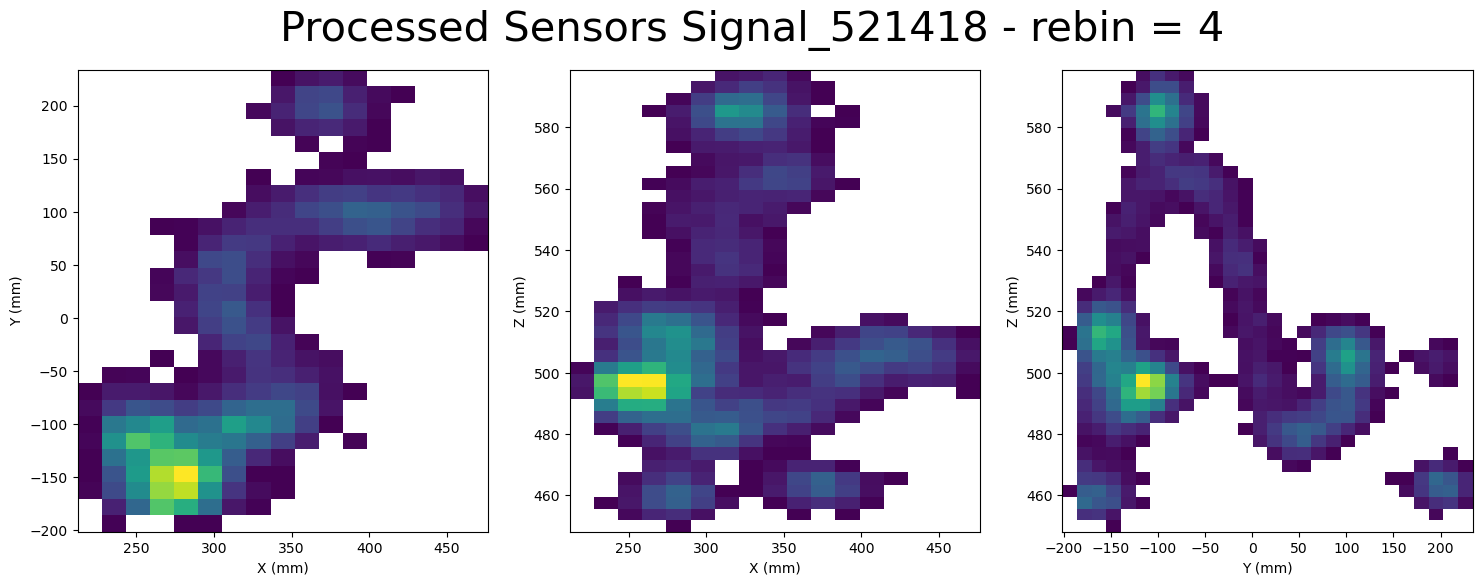

EVENT 388257
Total energy 2.36 MeV

Time spent in cut_over_Q: 0.013039112091064453 s
Time spent in drop_isolated: 0.03838539123535156 s


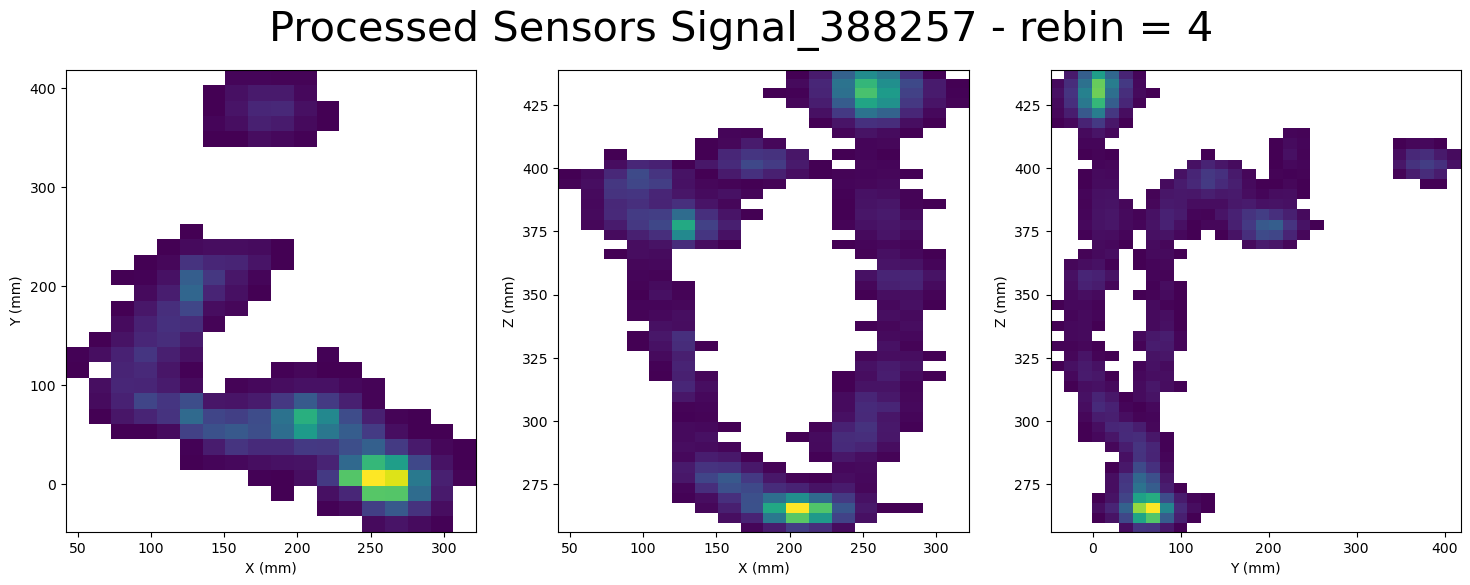

EVENT 2767
Total energy 2.28 MeV

Time spent in cut_over_Q: 0.011837482452392578 s
Time spent in drop_isolated: 0.034029245376586914 s


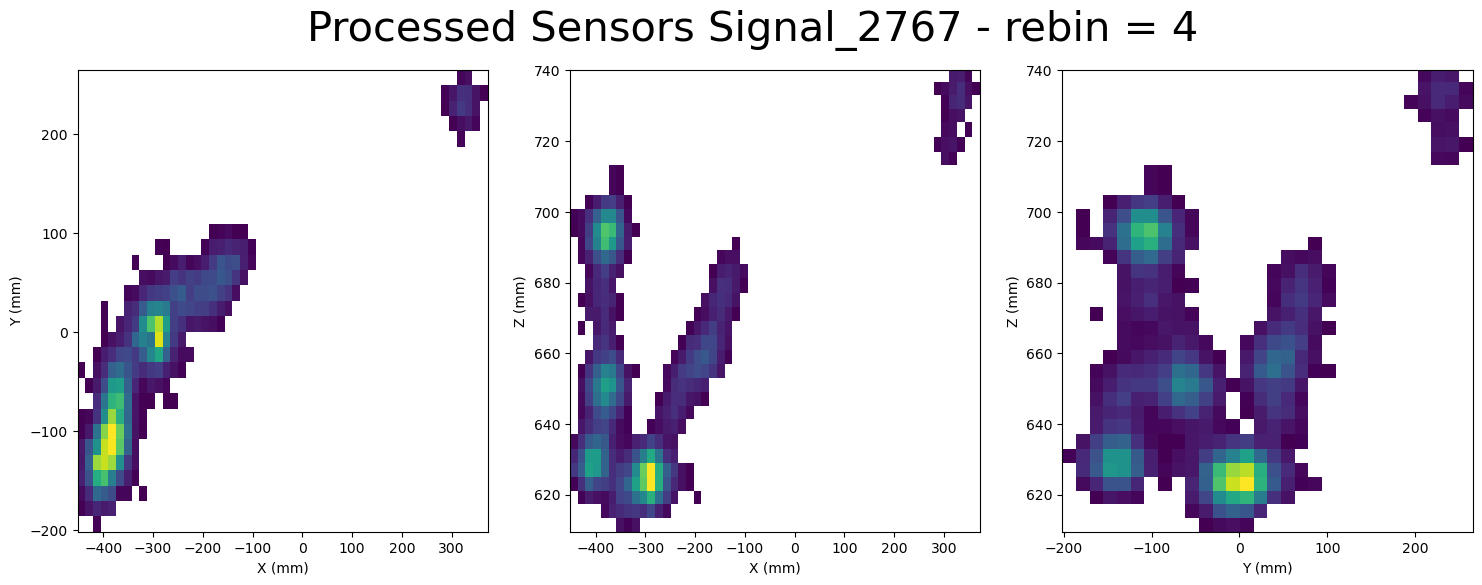

EVENT 641209
Total energy 2.37 MeV

Time spent in cut_over_Q: 0.010770082473754883 s
Time spent in drop_isolated: 0.04028820991516113 s


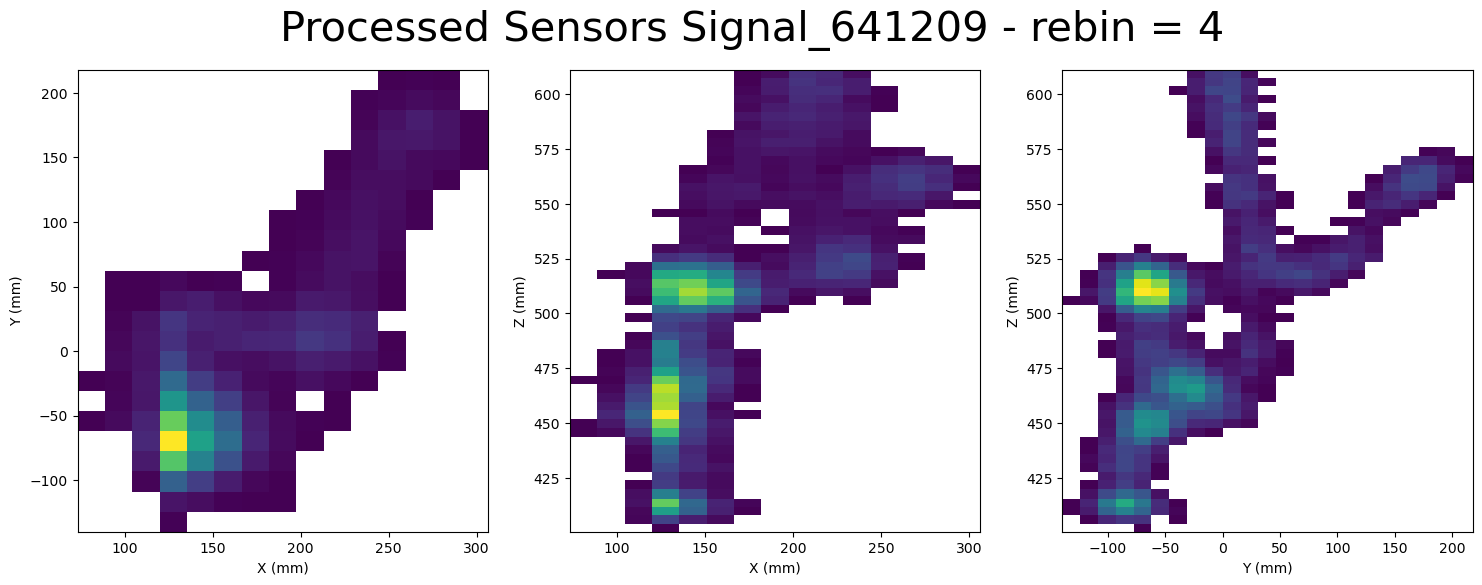

EVENT 632501
Total energy 2.20 MeV

Time spent in cut_over_Q: 0.01223134994506836 s
Time spent in drop_isolated: 0.04464578628540039 s


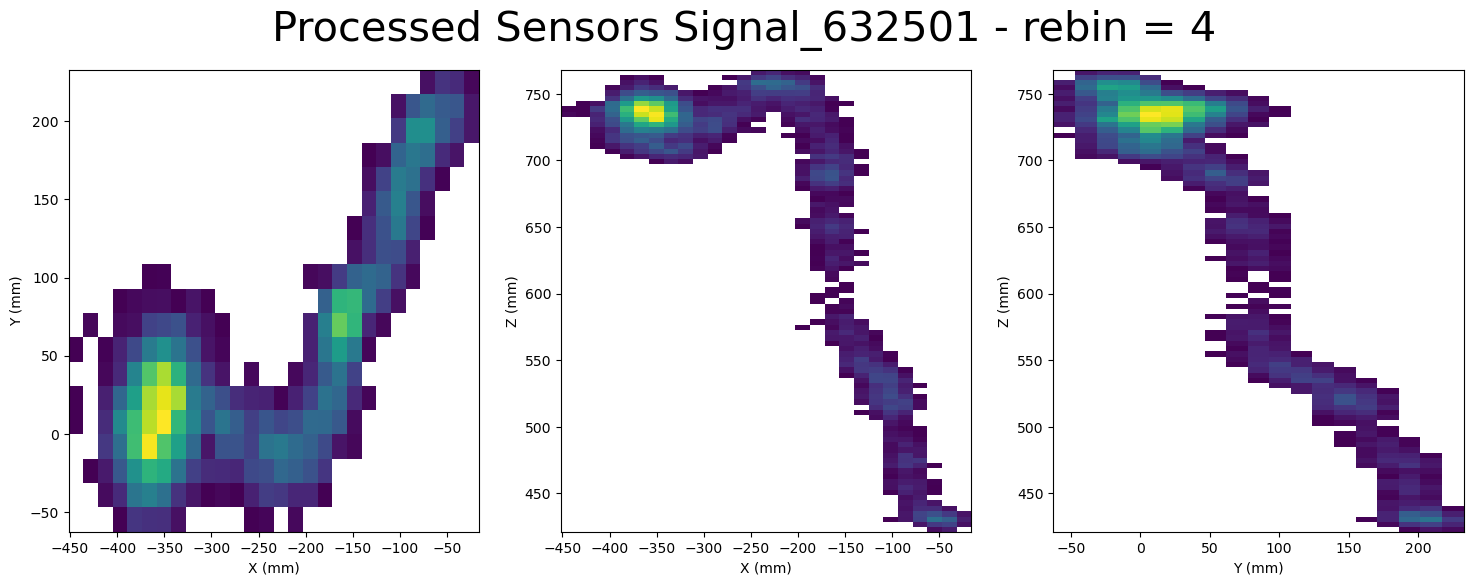

EVENT 191389
Total energy 2.21 MeV

Time spent in cut_over_Q: 0.024269580841064453 s
Time spent in drop_isolated: 0.07759618759155273 s


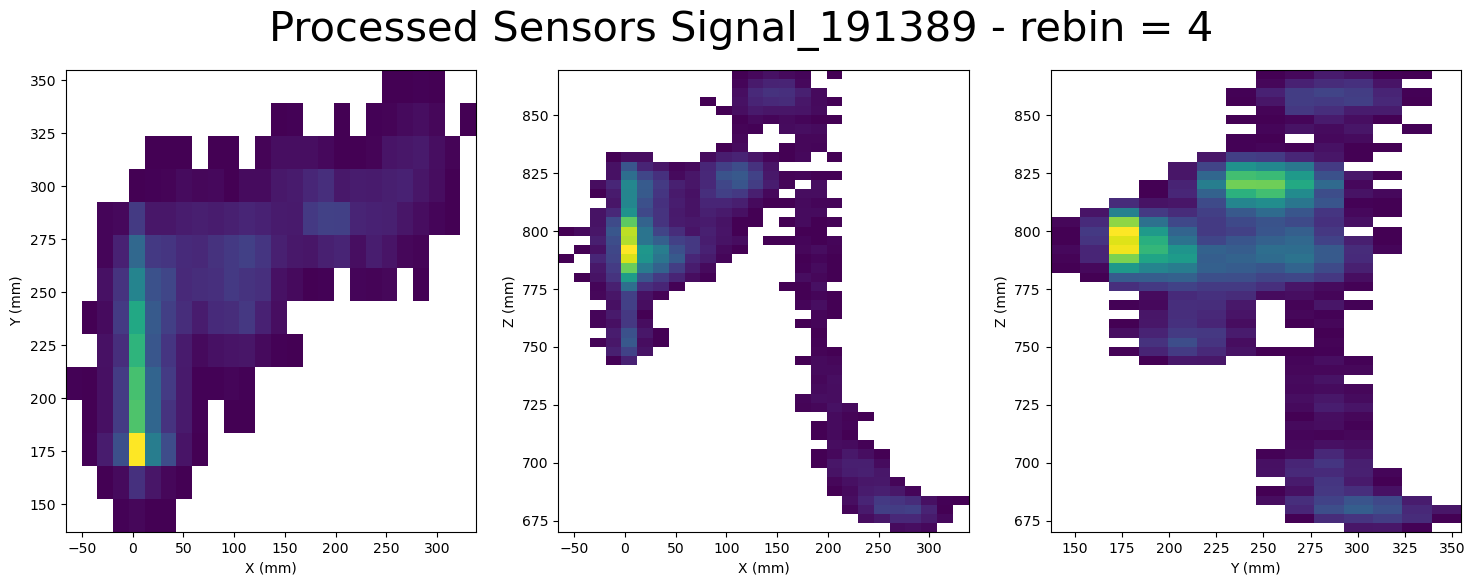

EVENT 1344716
Total energy 4.47 MeV

Time spent in cut_over_Q: 0.017825841903686523 s
Time spent in drop_isolated: 0.15528512001037598 s


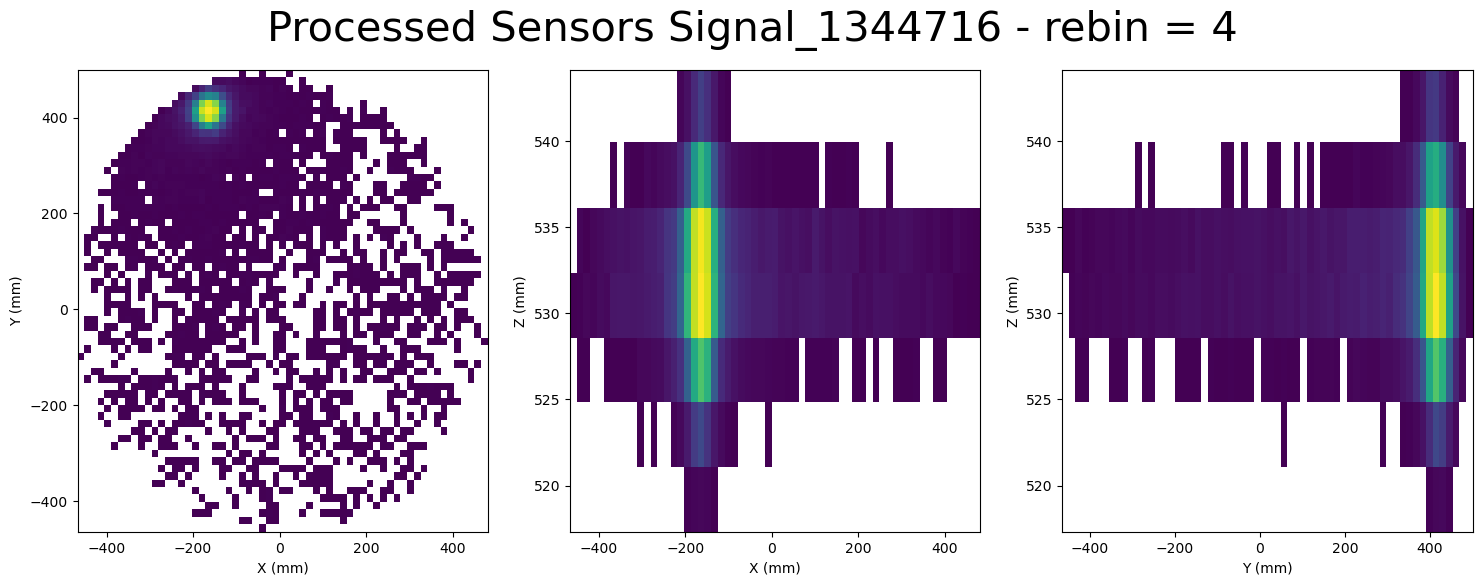

EVENT 117630
Total energy 2.28 MeV

Time spent in cut_over_Q: 0.014873266220092773 s
Time spent in drop_isolated: 0.05063319206237793 s


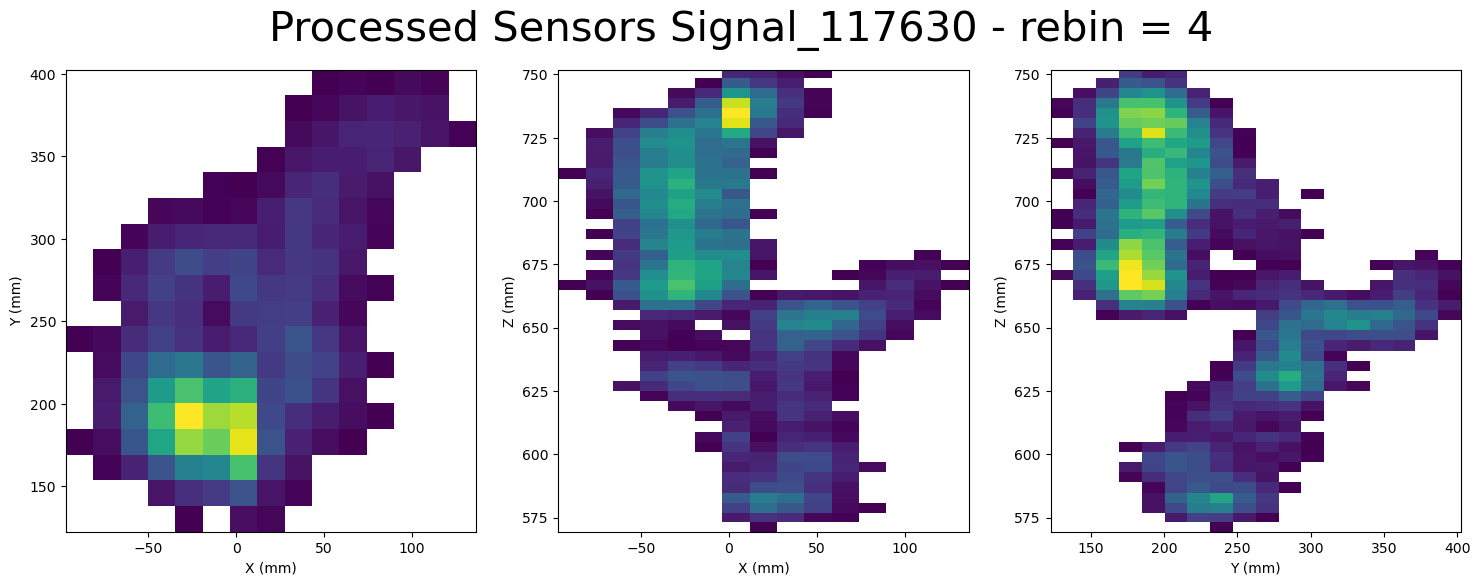

EVENT 295668
Total energy 2.58 MeV

Time spent in cut_over_Q: 0.013757467269897461 s
Time spent in drop_isolated: 0.03981494903564453 s


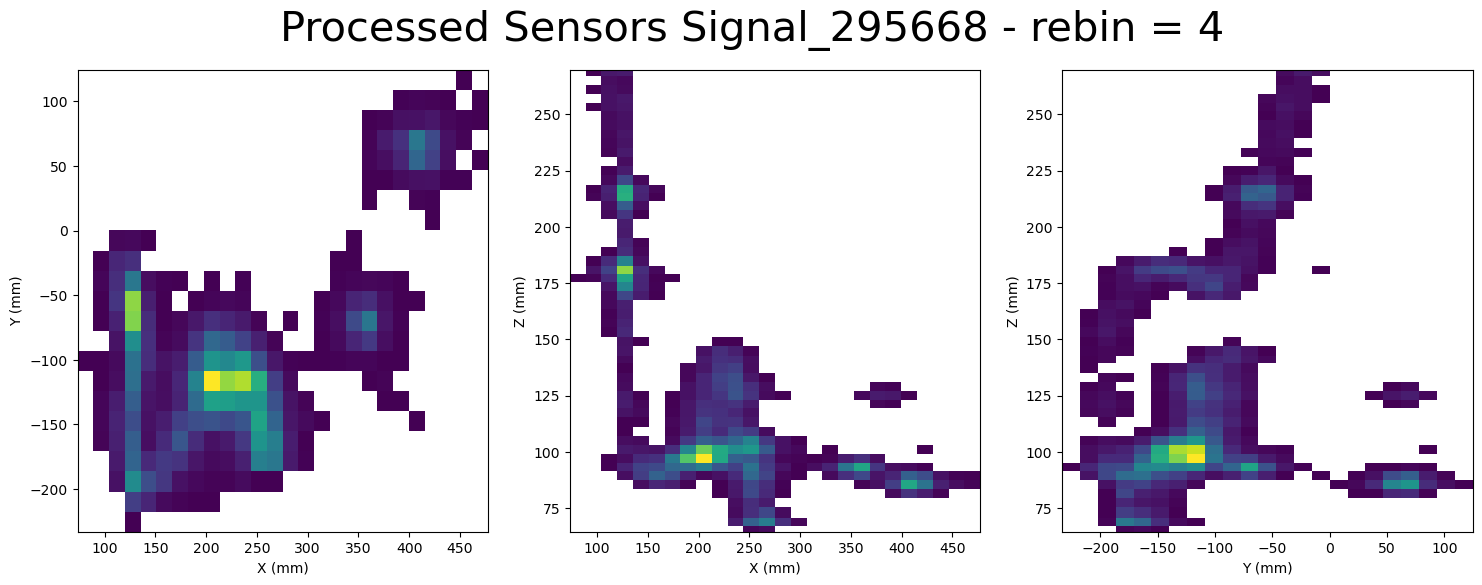

EVENT 358066
Total energy 2.26 MeV

Time spent in cut_over_Q: 0.01721477508544922 s
Time spent in drop_isolated: 0.06723237037658691 s


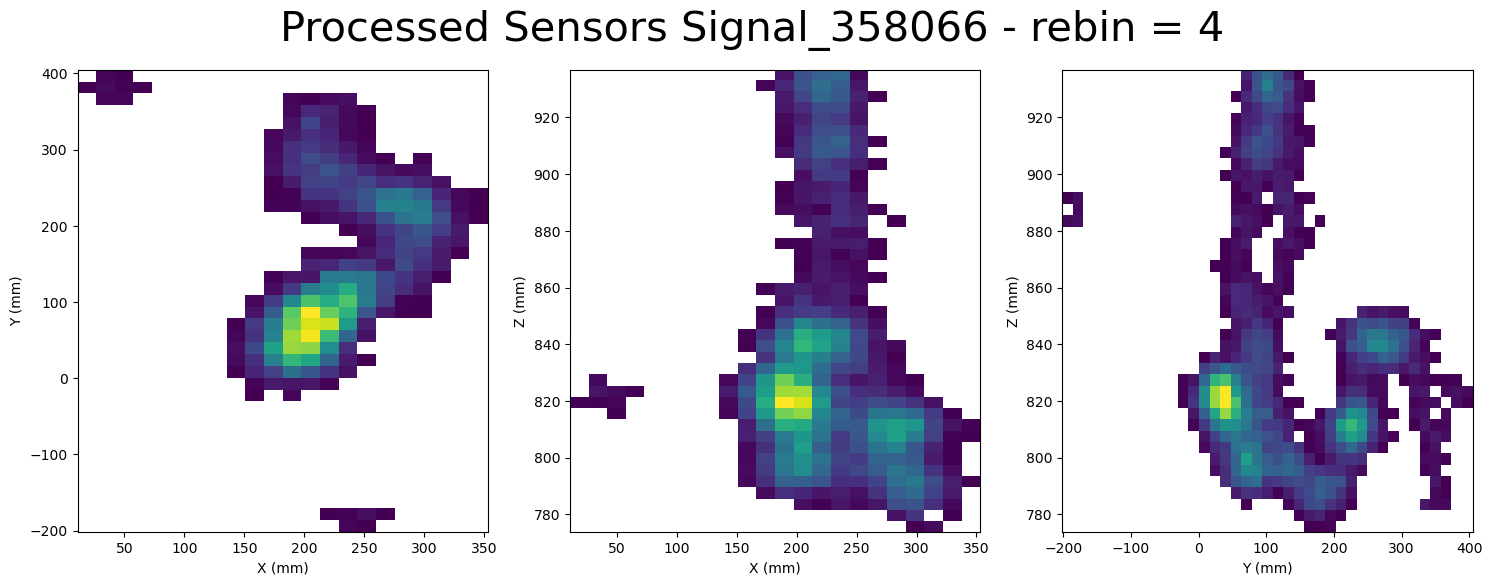

EVENT 646179
Total energy 2.34 MeV

Time spent in cut_over_Q: 0.014975309371948242 s
Time spent in drop_isolated: 0.05574989318847656 s


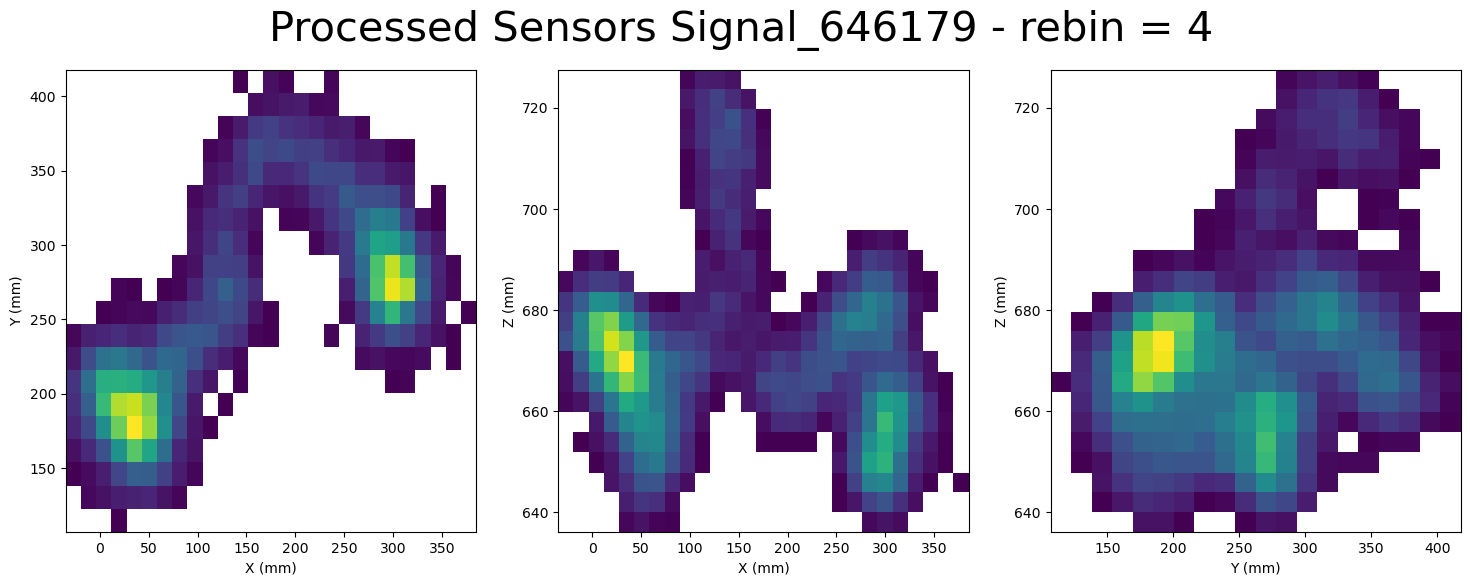

EVENT 453238
Total energy 2.27 MeV

Time spent in cut_over_Q: 0.013712406158447266 s
Time spent in drop_isolated: 0.04278206825256348 s


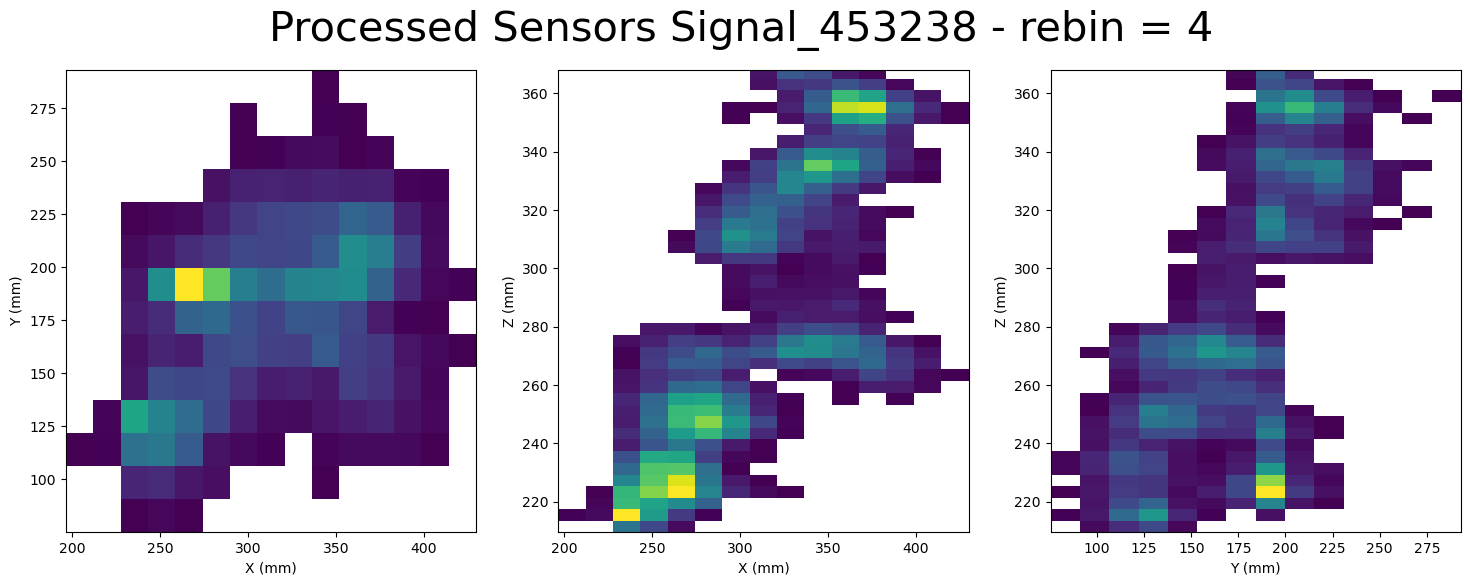

EVENT 1433700
Total energy 2.34 MeV

Time spent in cut_over_Q: 0.012944936752319336 s
Time spent in drop_isolated: 0.05051302909851074 s


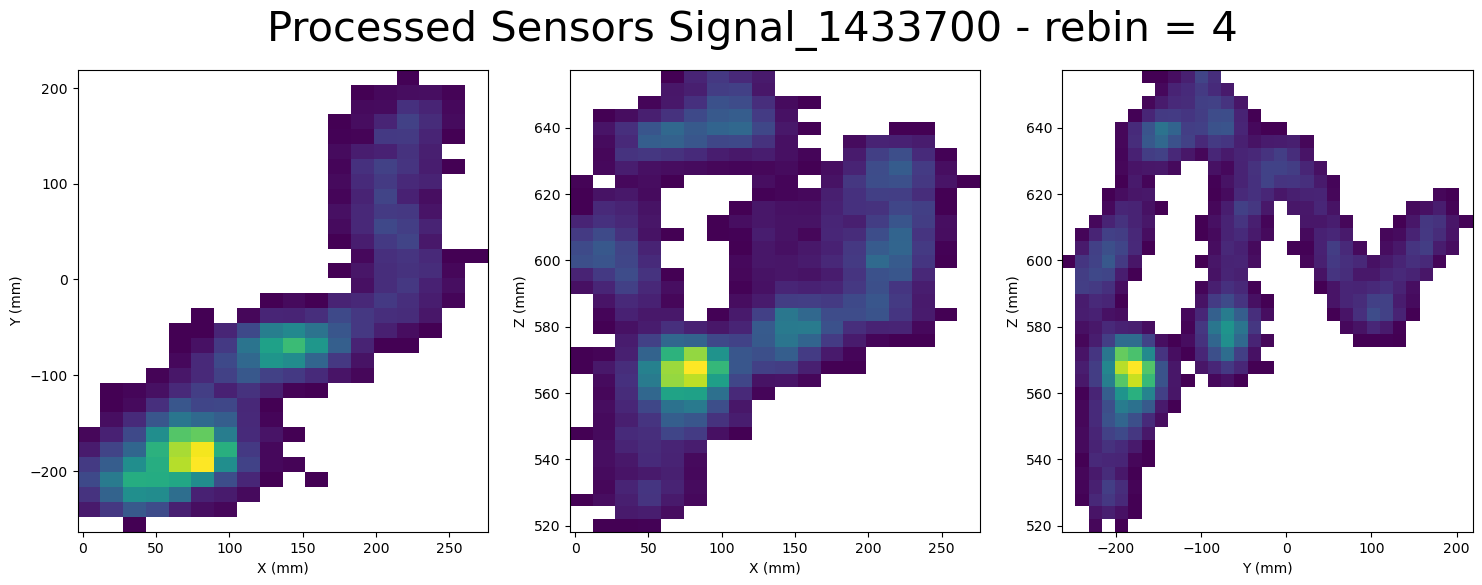

EVENT 150880
Total energy 2.40 MeV

Time spent in cut_over_Q: 0.012137174606323242 s
Time spent in drop_isolated: 0.03804826736450195 s


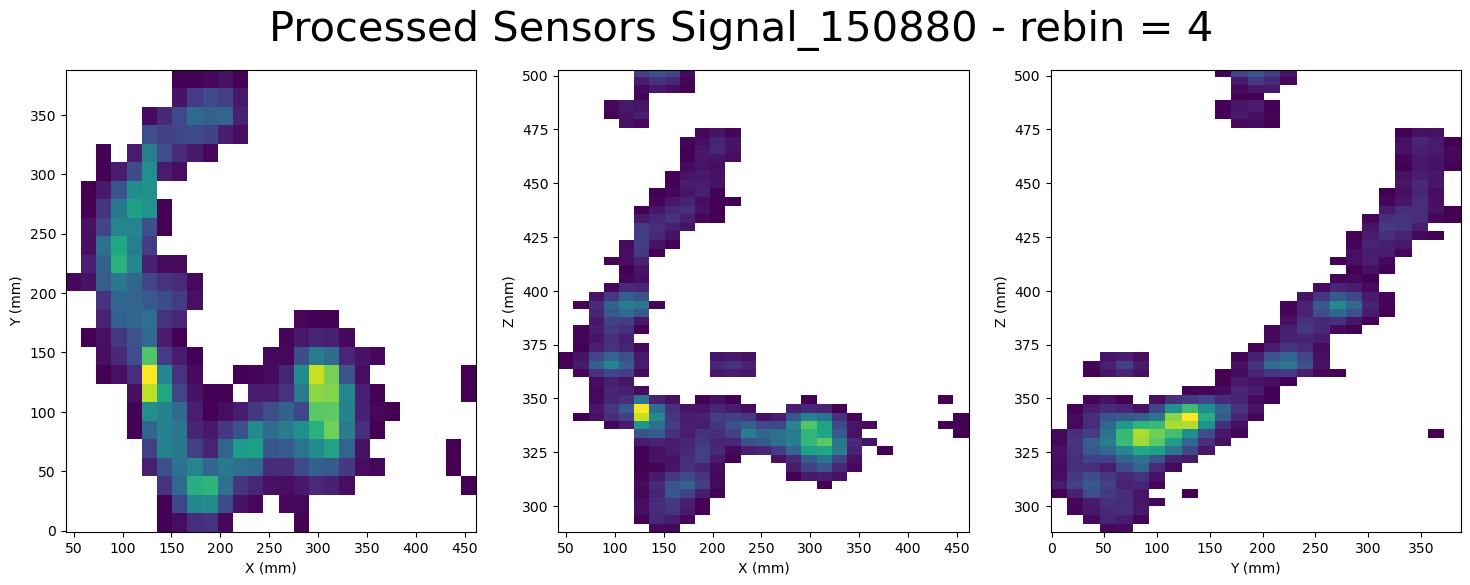

EVENT 281150
Total energy 2.28 MeV

Time spent in cut_over_Q: 0.011723995208740234 s
Time spent in drop_isolated: 0.04783344268798828 s


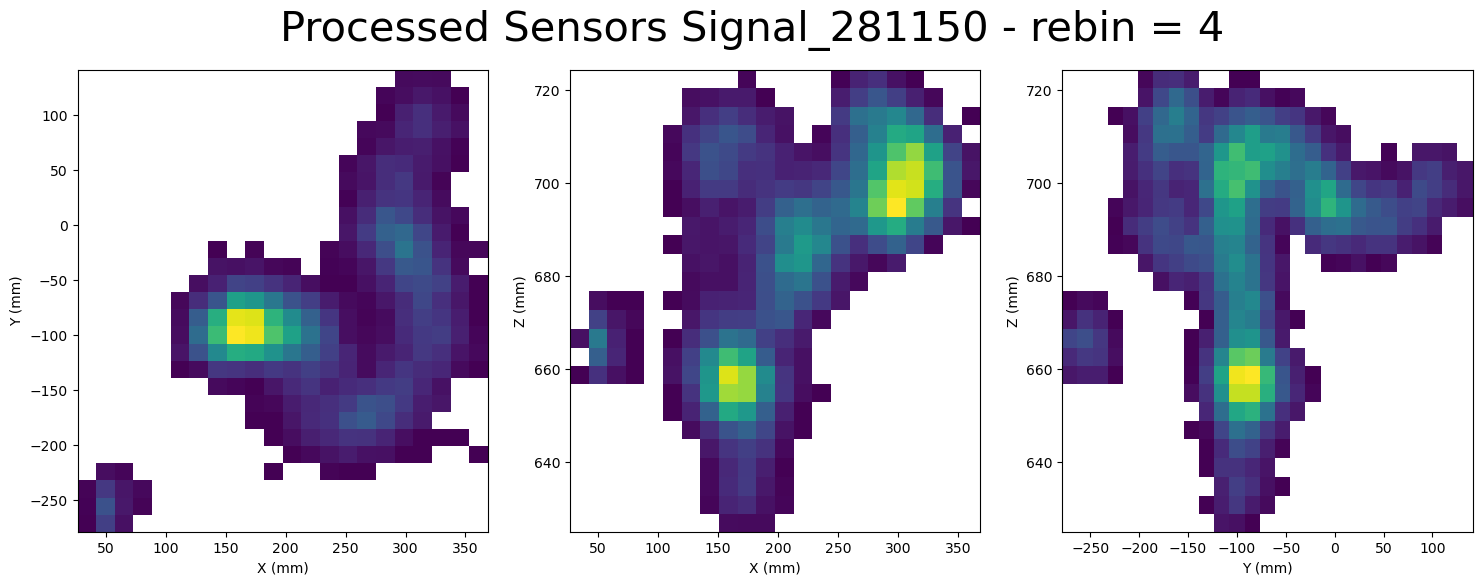

EVENT 837650
Total energy 2.26 MeV

Time spent in cut_over_Q: 0.011108160018920898 s
Time spent in drop_isolated: 0.04666447639465332 s


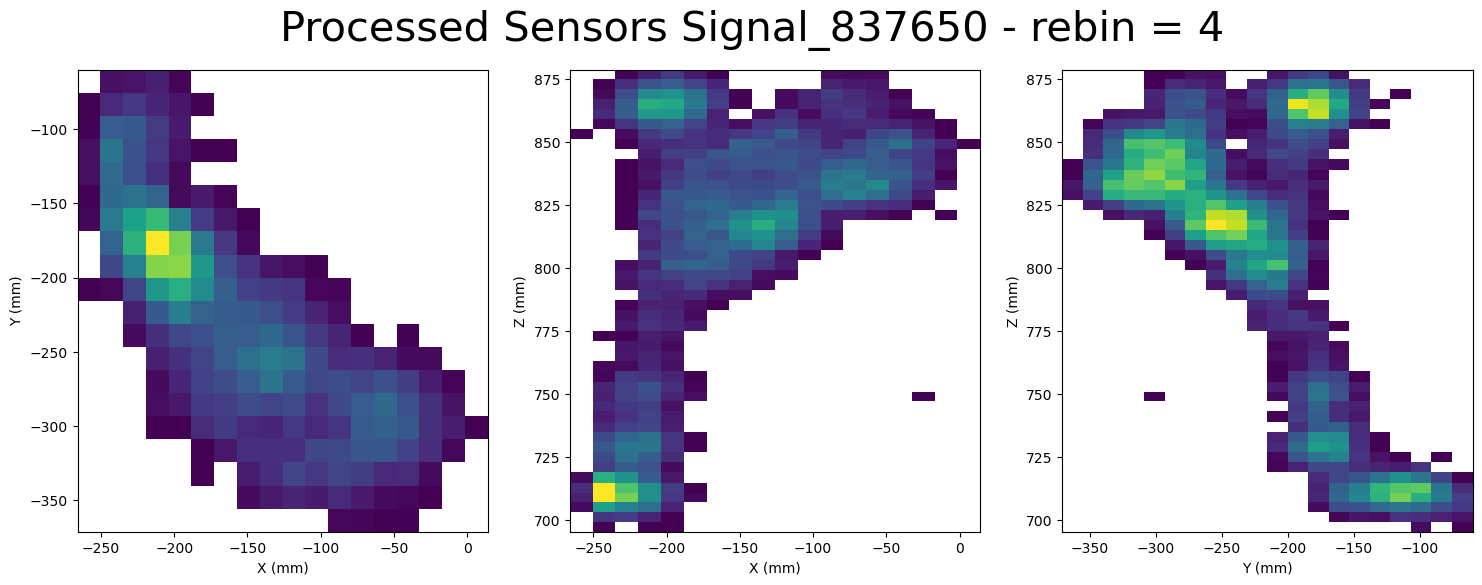

EVENT 852028
Total energy 2.32 MeV

Time spent in cut_over_Q: 0.012090921401977539 s
Time spent in drop_isolated: 0.048429012298583984 s


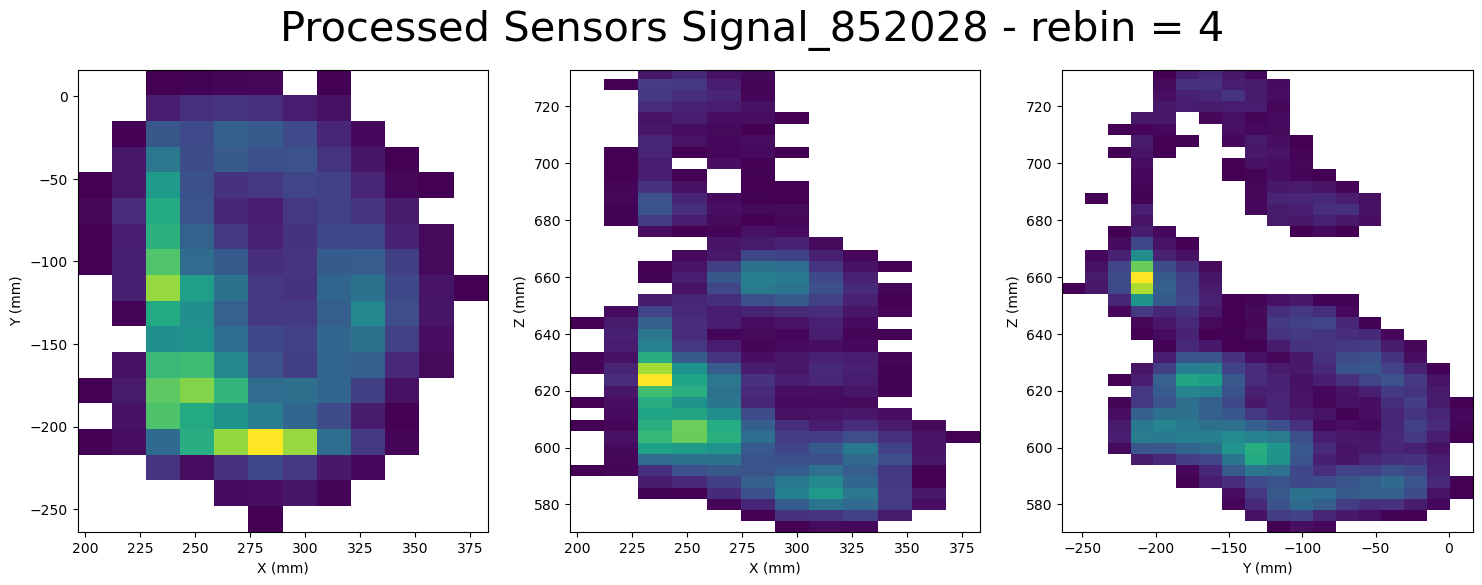

EVENT 611991
Total energy 2.39 MeV

Time spent in cut_over_Q: 0.011934280395507812 s
Time spent in drop_isolated: 0.05425882339477539 s


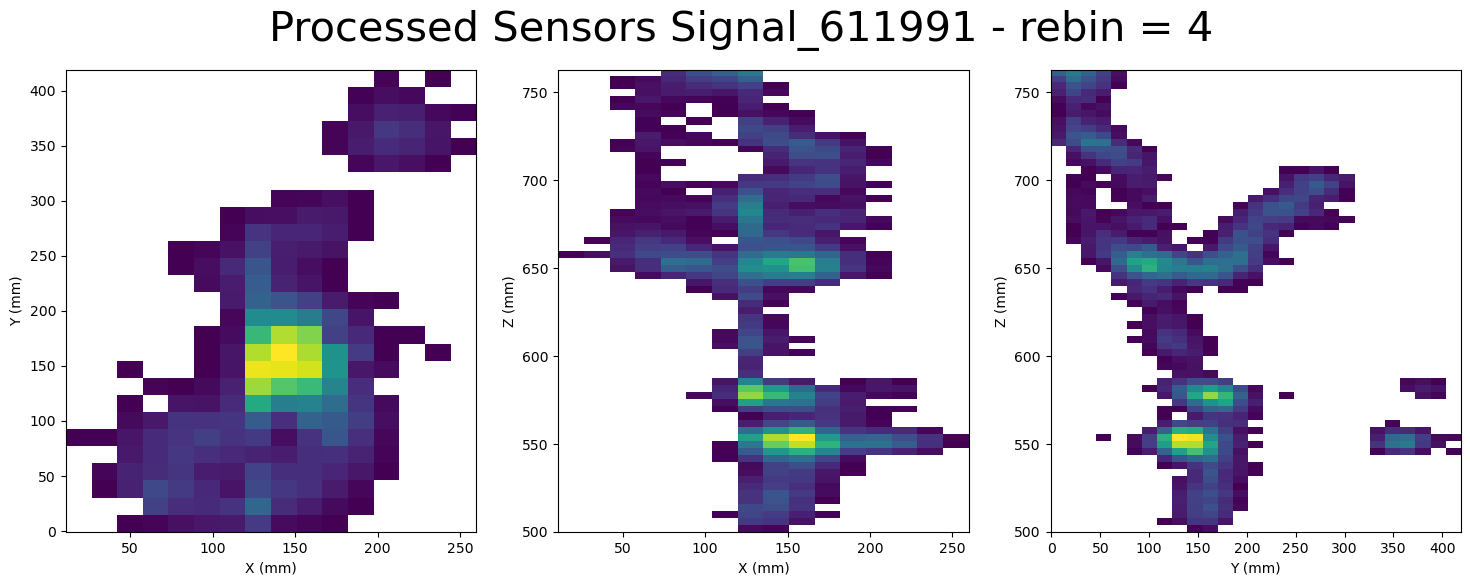

EVENT 631724
Total energy 2.33 MeV

Time spent in cut_over_Q: 0.018843889236450195 s
Time spent in drop_isolated: 0.03806042671203613 s


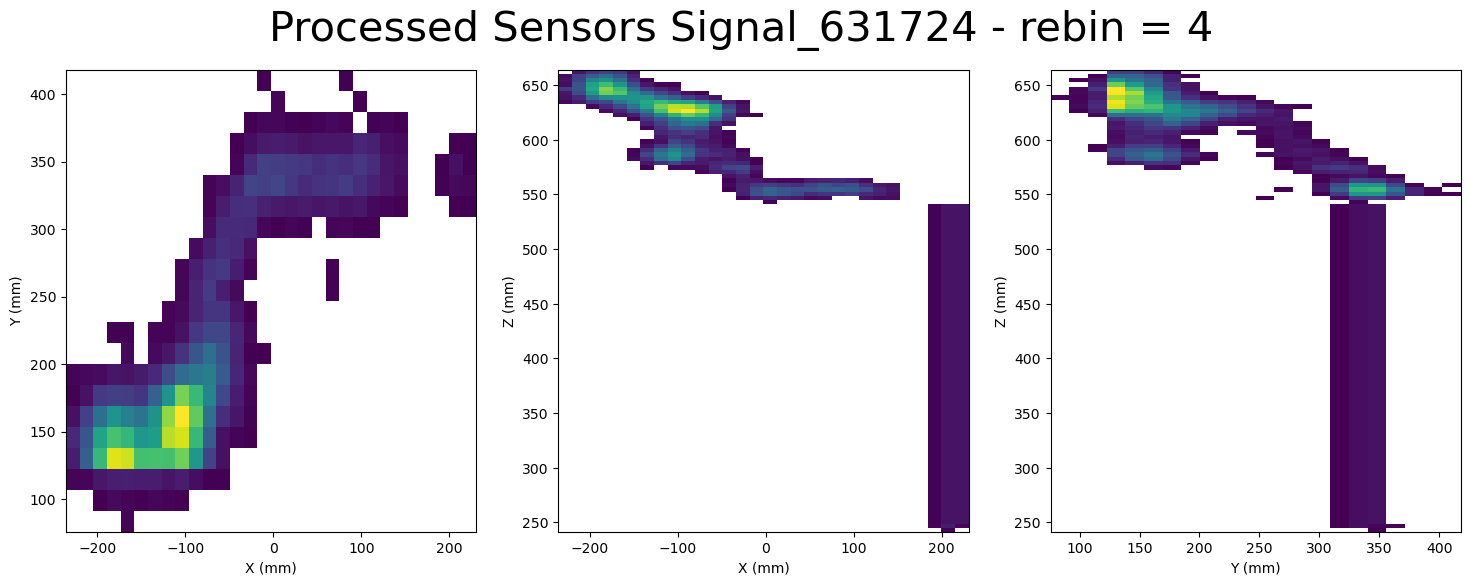

In [64]:
CE_low_z_evts = low_z_events.event.unique()

stopper = 20
for i, ev in enumerate(CE_low_z_evts):
    plotter(low_z_events, ev)
    if i > stopper:
        break

# DEP events

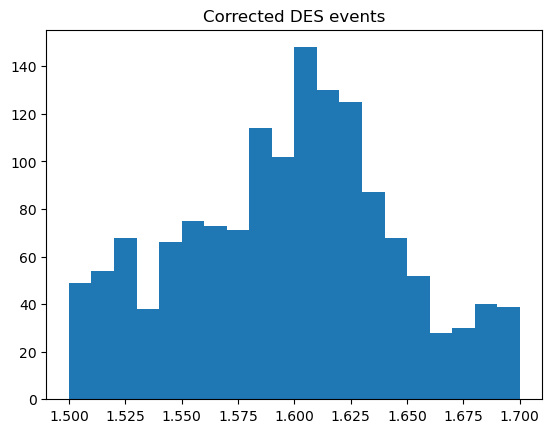

In [67]:
folder_path = 'files/15107_energy_split/'
corr_DES = pd.read_hdf(folder_path + 'corr_DES.h5', 'RECO/Events')

plt.hist(corr_DES.groupby('event').Ec.sum(), bins = 20, range = [1.5, 1.7])
plt.title('Corrected DES events')
plt.show()

EVENT 1127289
Total energy 1.79 MeV

Time spent in cut_over_Q: 0.027668476104736328 s
Time spent in drop_isolated: 0.059827327728271484 s


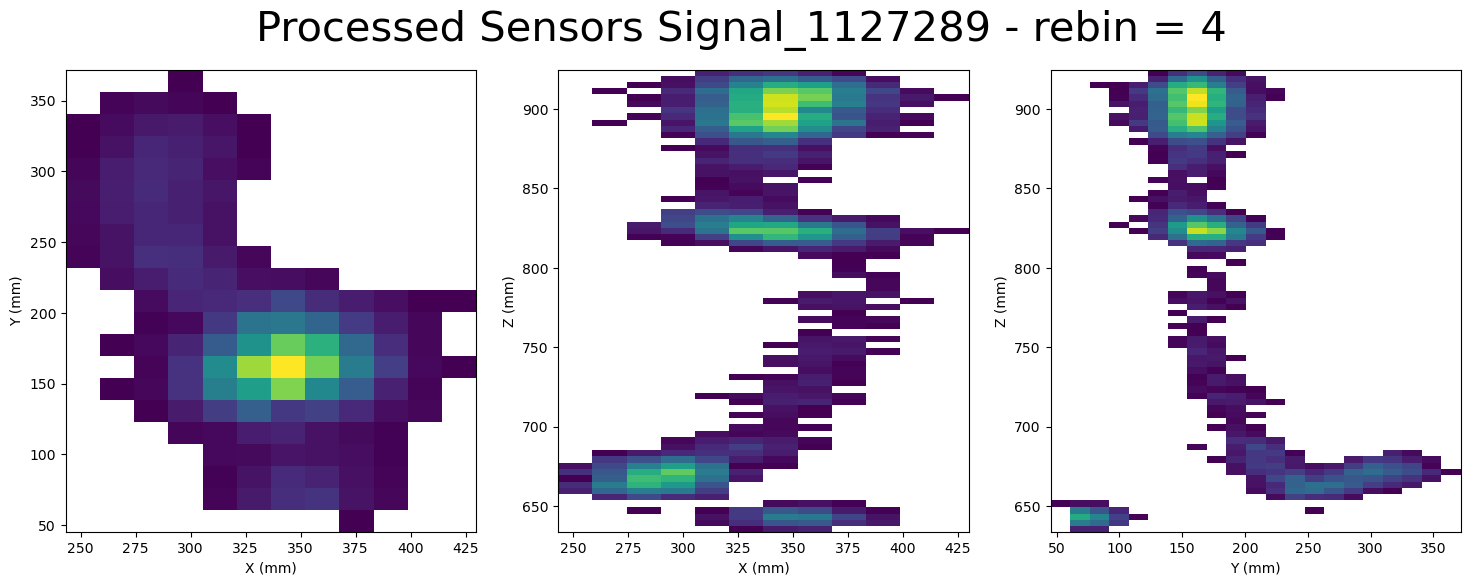

EVENT 716942
Total energy 1.56 MeV

Time spent in cut_over_Q: 0.01850605010986328 s
Time spent in drop_isolated: 0.02563762664794922 s


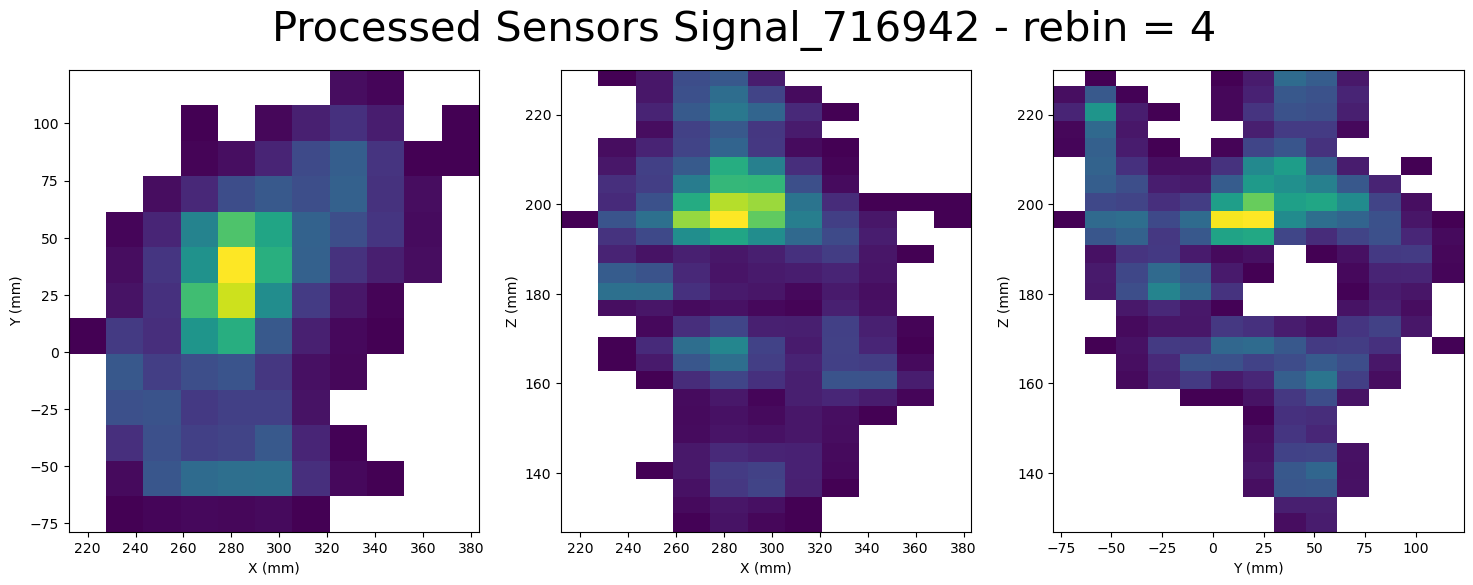

EVENT 904297
Total energy 1.71 MeV

Time spent in cut_over_Q: 0.013595342636108398 s
Time spent in drop_isolated: 0.02544879913330078 s


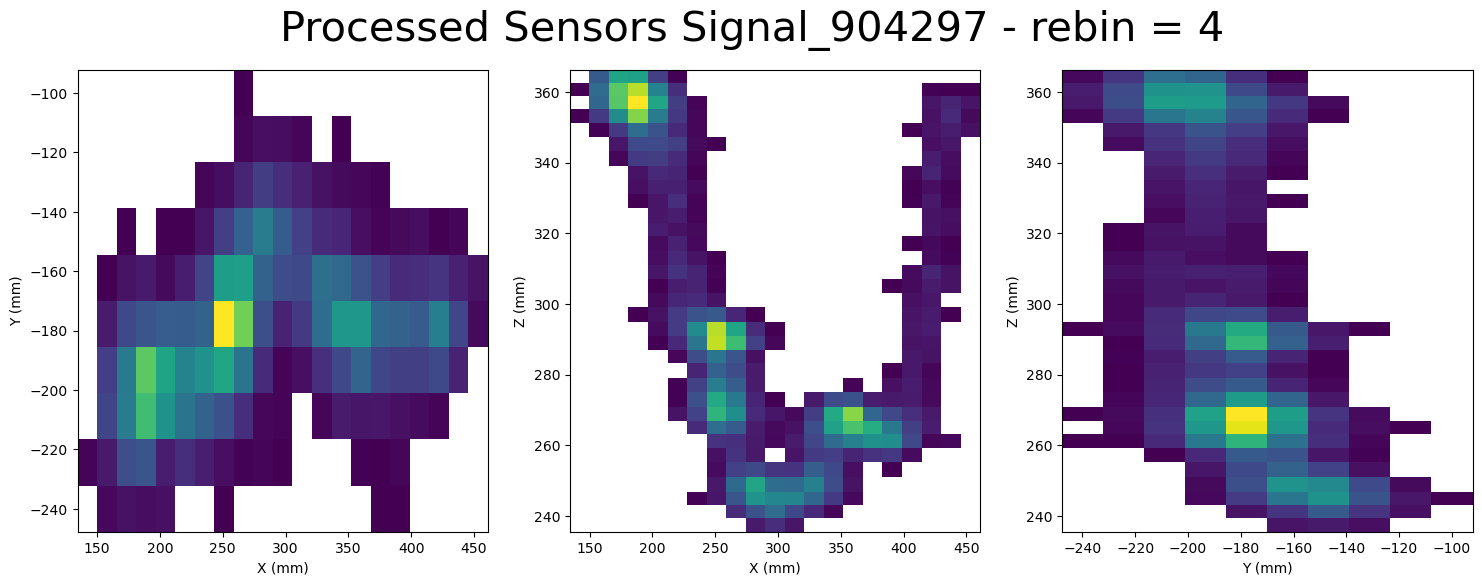

EVENT 584894
Total energy 1.49 MeV

Time spent in cut_over_Q: 0.021881580352783203 s
Time spent in drop_isolated: 0.0355985164642334 s


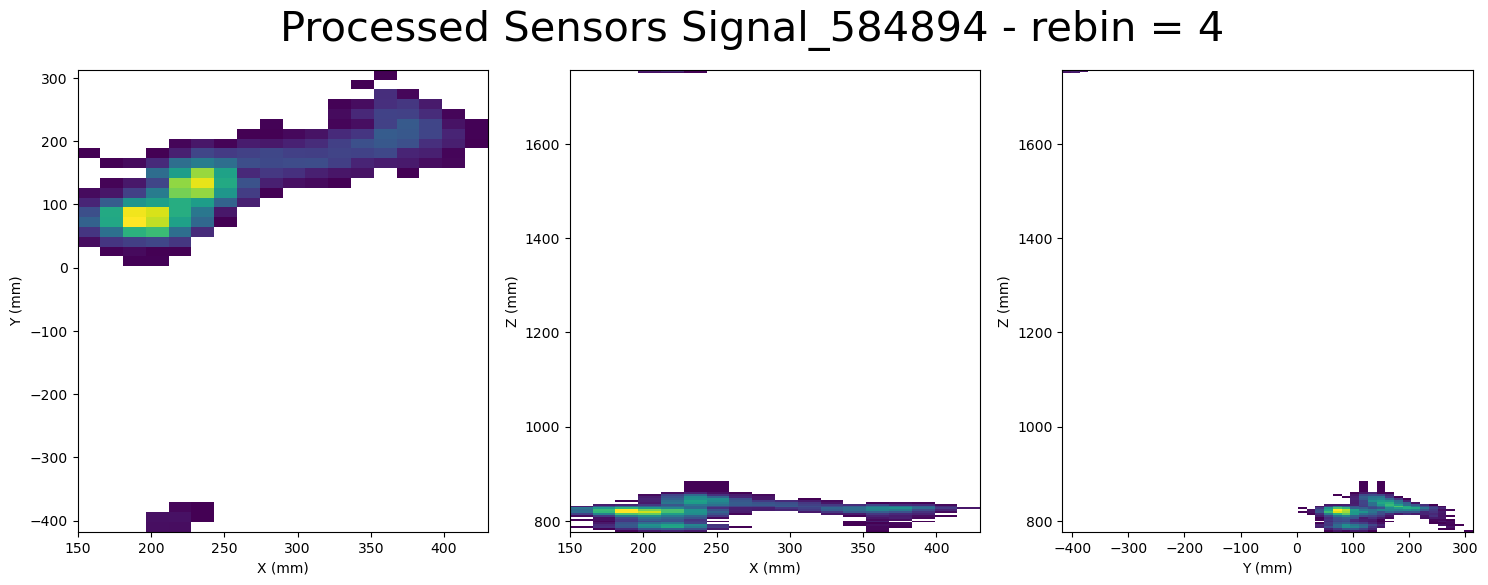

EVENT 458516
Total energy 1.42 MeV

Time spent in cut_over_Q: 0.011603355407714844 s
Time spent in drop_isolated: 0.01845097541809082 s


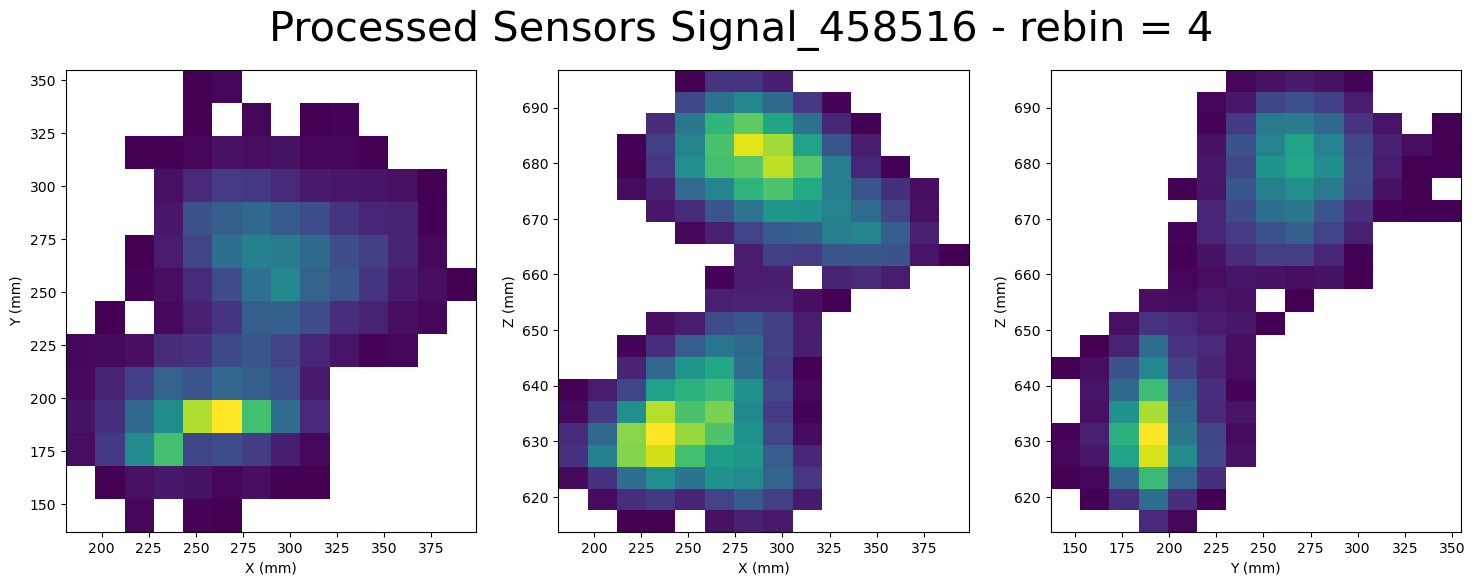

EVENT 819429
Total energy 1.70 MeV

Time spent in cut_over_Q: 0.01106119155883789 s
Time spent in drop_isolated: 0.02956676483154297 s


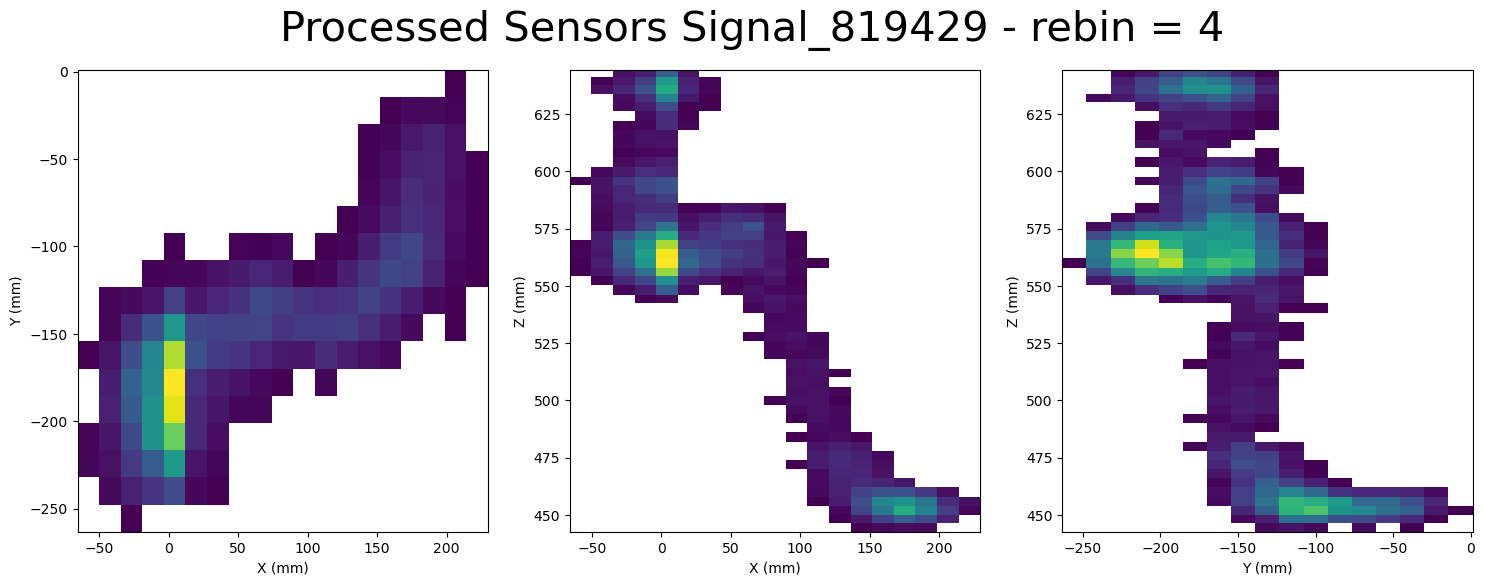

EVENT 468302
Total energy 1.61 MeV

Time spent in cut_over_Q: 0.020026206970214844 s
Time spent in drop_isolated: 0.02881145477294922 s


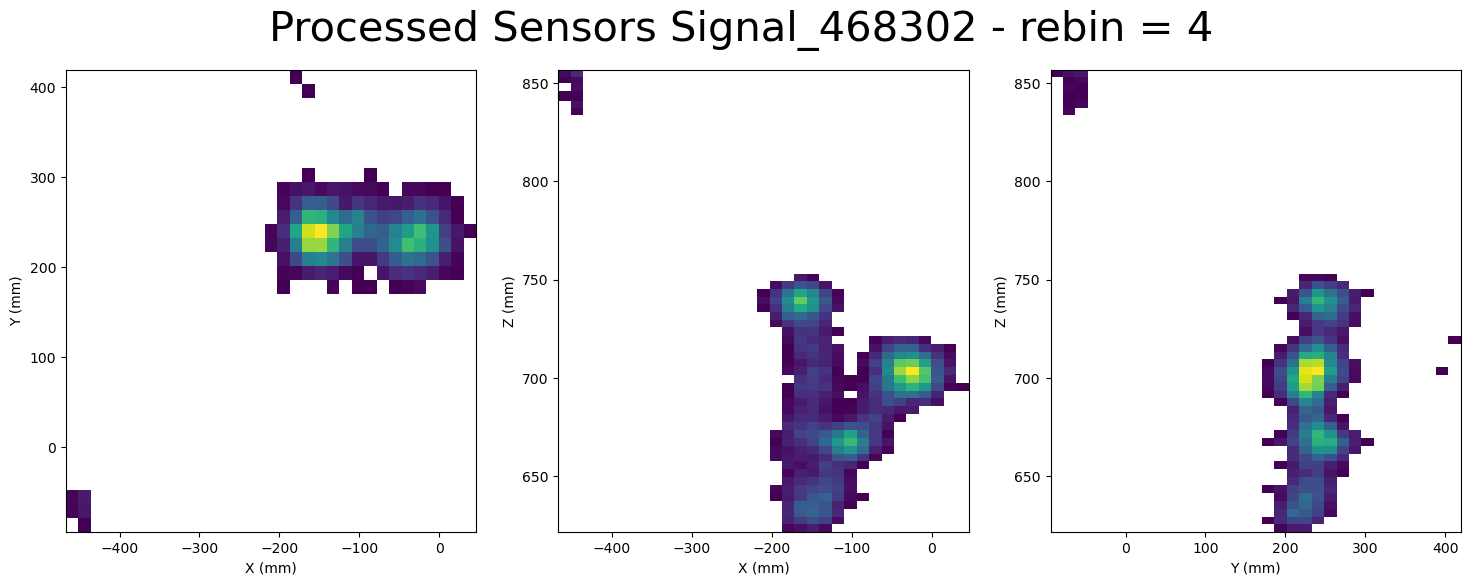

EVENT 1305824
Total energy 1.58 MeV

Time spent in cut_over_Q: 0.01767110824584961 s
Time spent in drop_isolated: 0.018552780151367188 s


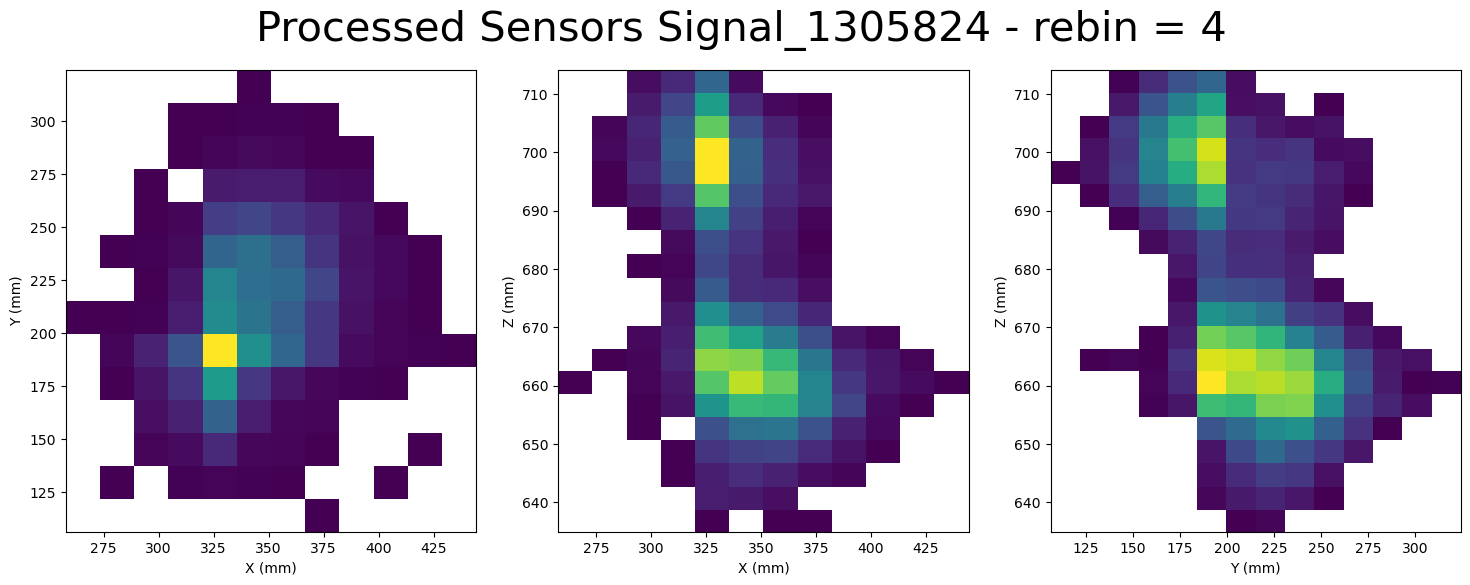

EVENT 1305922
Total energy 1.40 MeV

Time spent in cut_over_Q: 0.018486976623535156 s
Time spent in drop_isolated: 0.026616334915161133 s


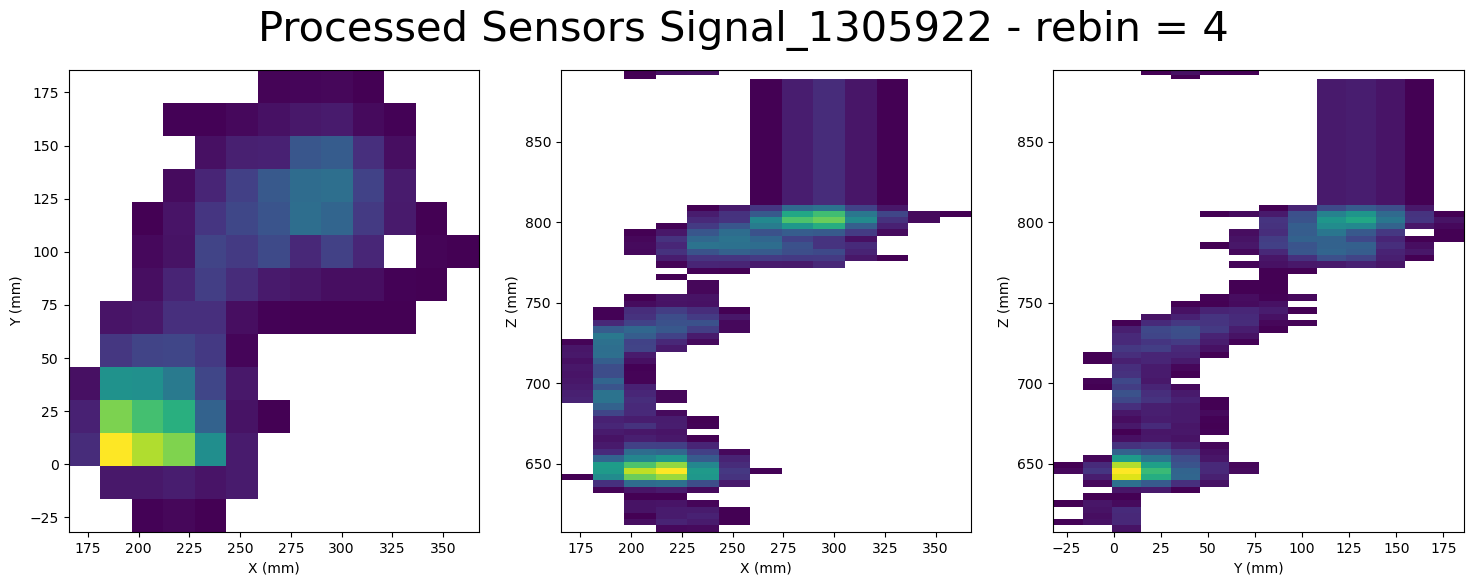

EVENT 1306097
Total energy 1.54 MeV

Time spent in cut_over_Q: 0.011163473129272461 s
Time spent in drop_isolated: 0.02149367332458496 s


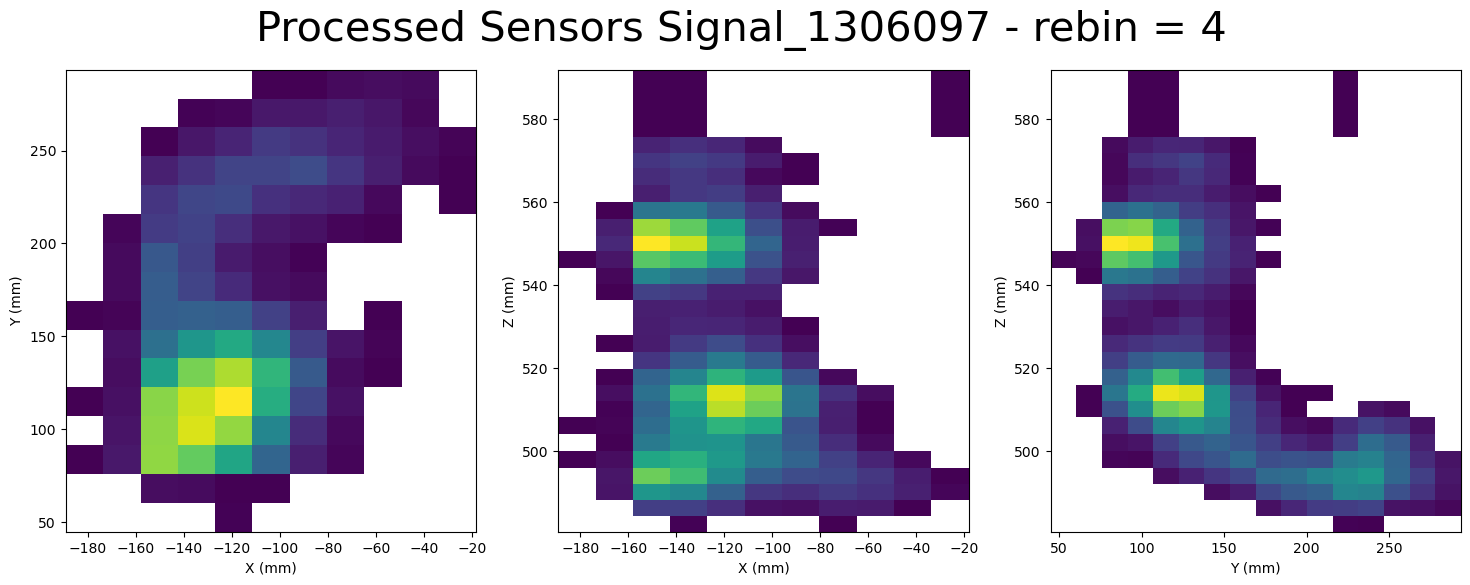

EVENT 152483
Total energy 1.62 MeV

Time spent in cut_over_Q: 0.010867834091186523 s
Time spent in drop_isolated: 0.017171859741210938 s


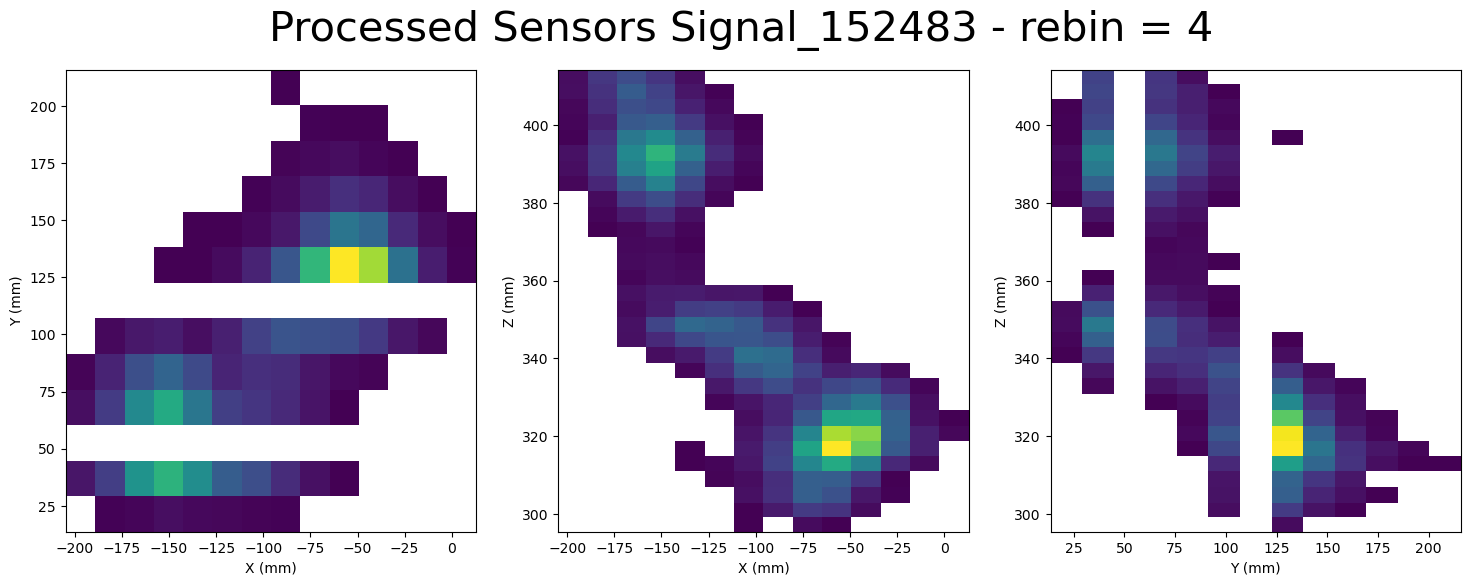

EVENT 659836
Total energy 1.63 MeV

Time spent in cut_over_Q: 0.013163328170776367 s
Time spent in drop_isolated: 0.01651930809020996 s


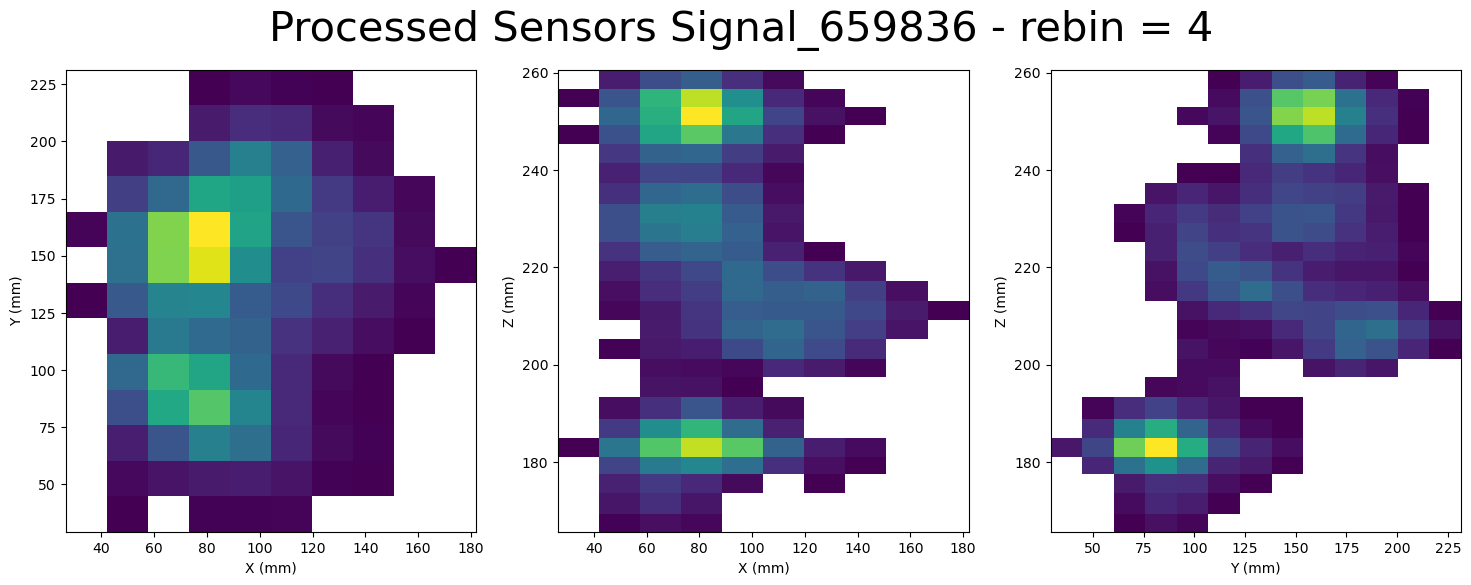

EVENT 427905
Total energy 1.71 MeV

Time spent in cut_over_Q: 0.04169273376464844 s
Time spent in drop_isolated: 0.016605138778686523 s


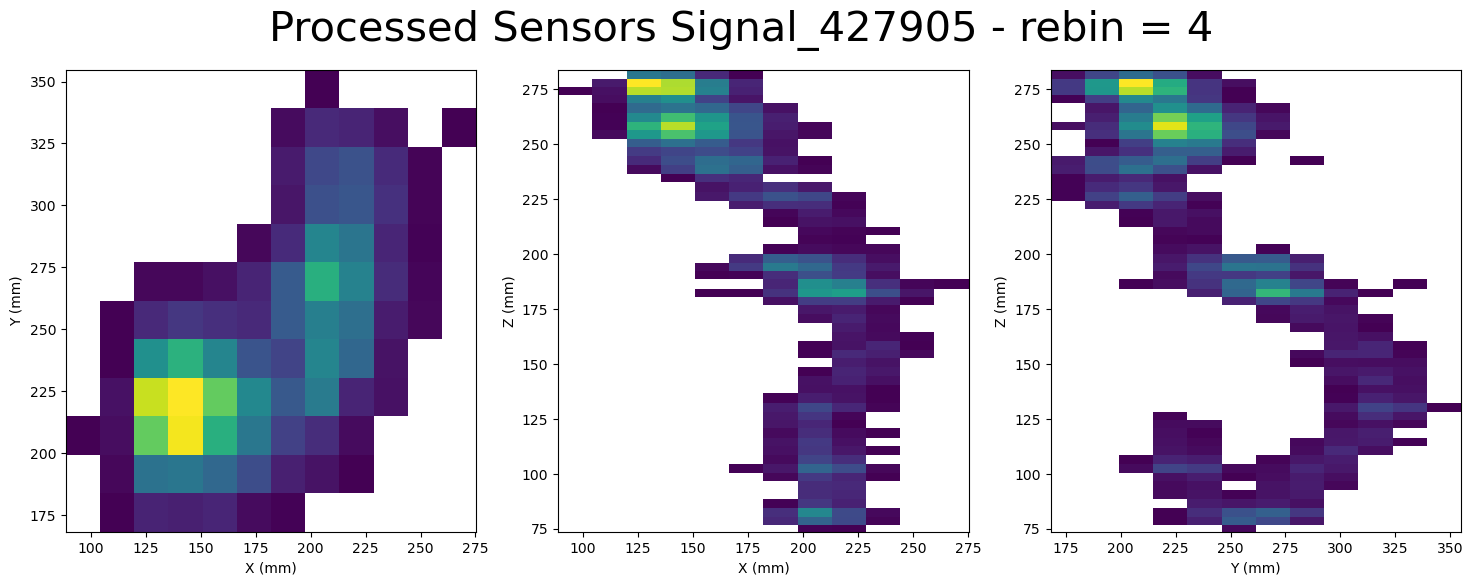

EVENT 1372856
Total energy 1.78 MeV

Time spent in cut_over_Q: 0.01232457160949707 s
Time spent in drop_isolated: 0.03313708305358887 s


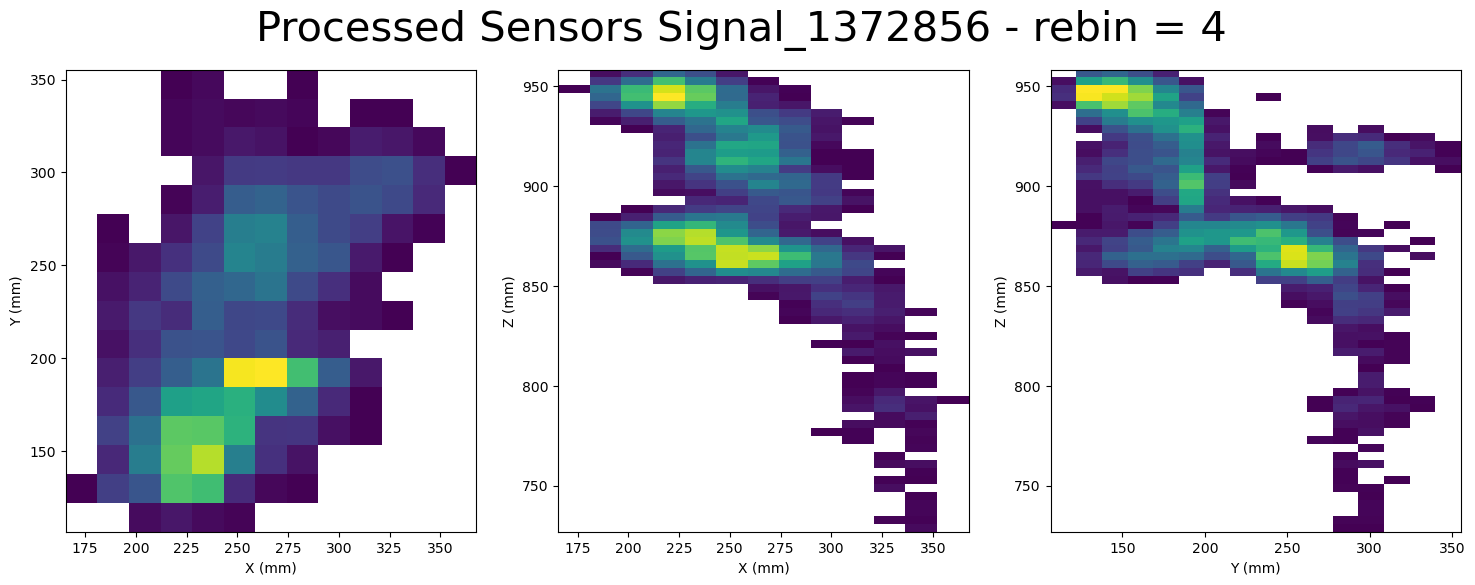

EVENT 6869
Total energy 1.47 MeV

Time spent in cut_over_Q: 0.010832786560058594 s
Time spent in drop_isolated: 0.01600480079650879 s


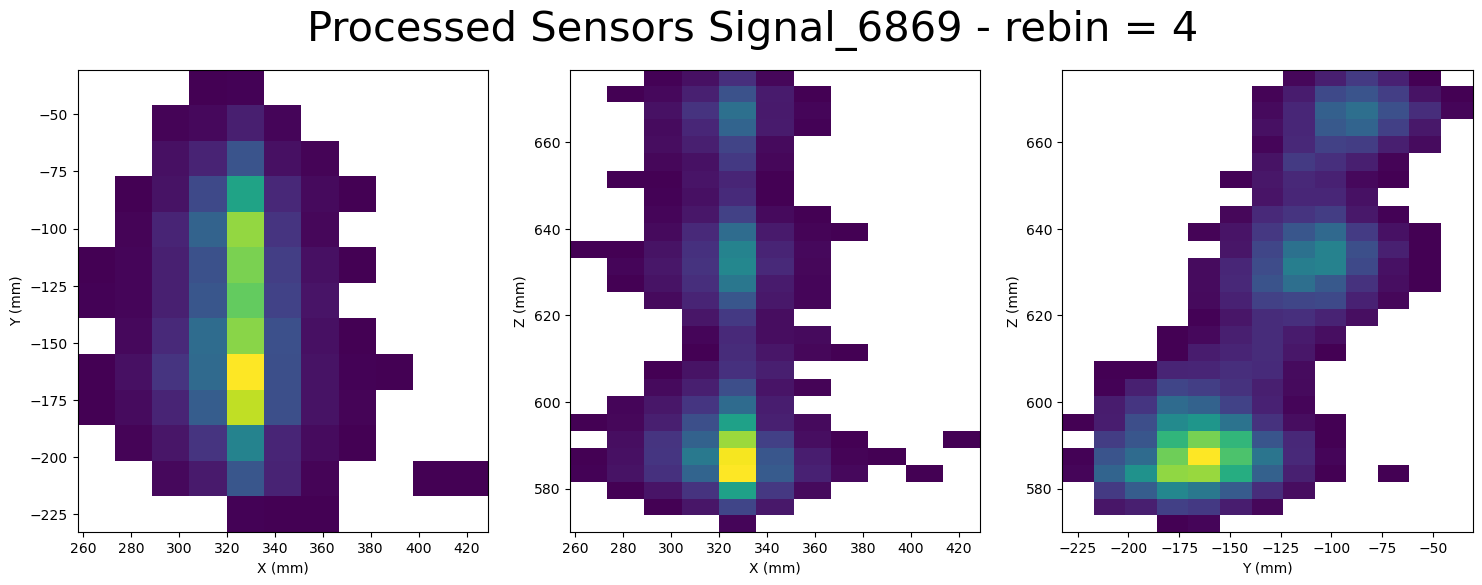

EVENT 784401
Total energy 1.58 MeV

Time spent in cut_over_Q: 0.011523723602294922 s
Time spent in drop_isolated: 0.026587486267089844 s


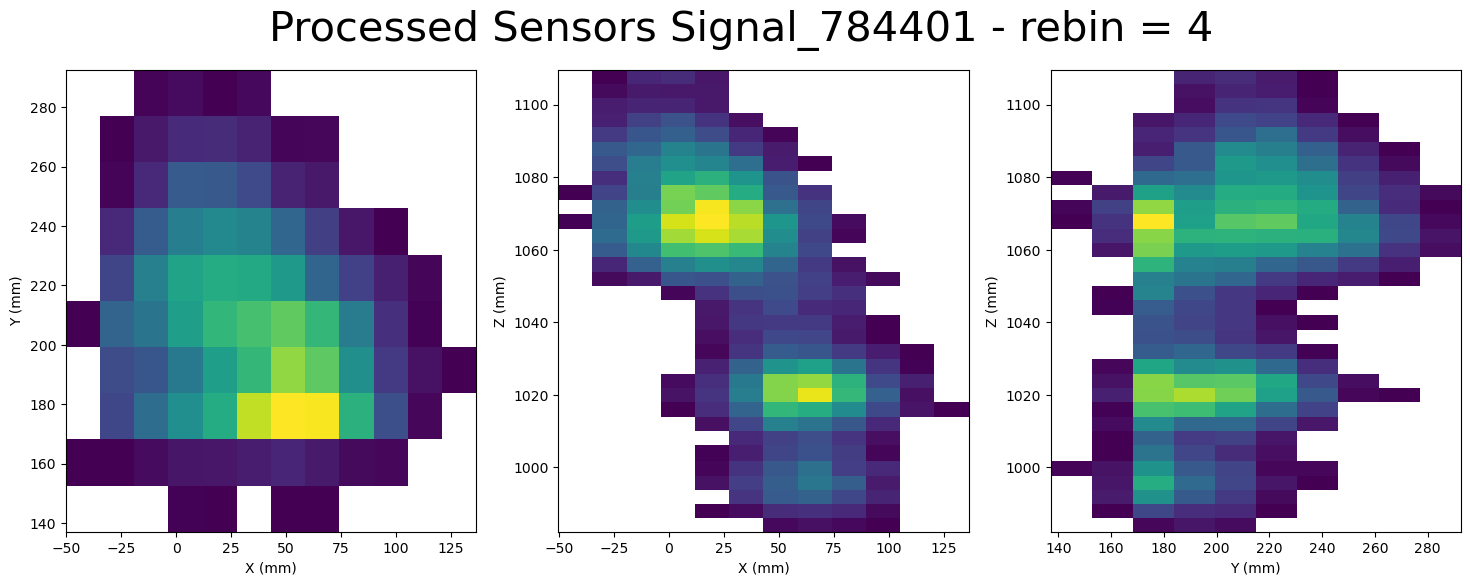

EVENT 498577
Total energy 1.66 MeV

Time spent in cut_over_Q: 0.011192798614501953 s
Time spent in drop_isolated: 0.023958921432495117 s


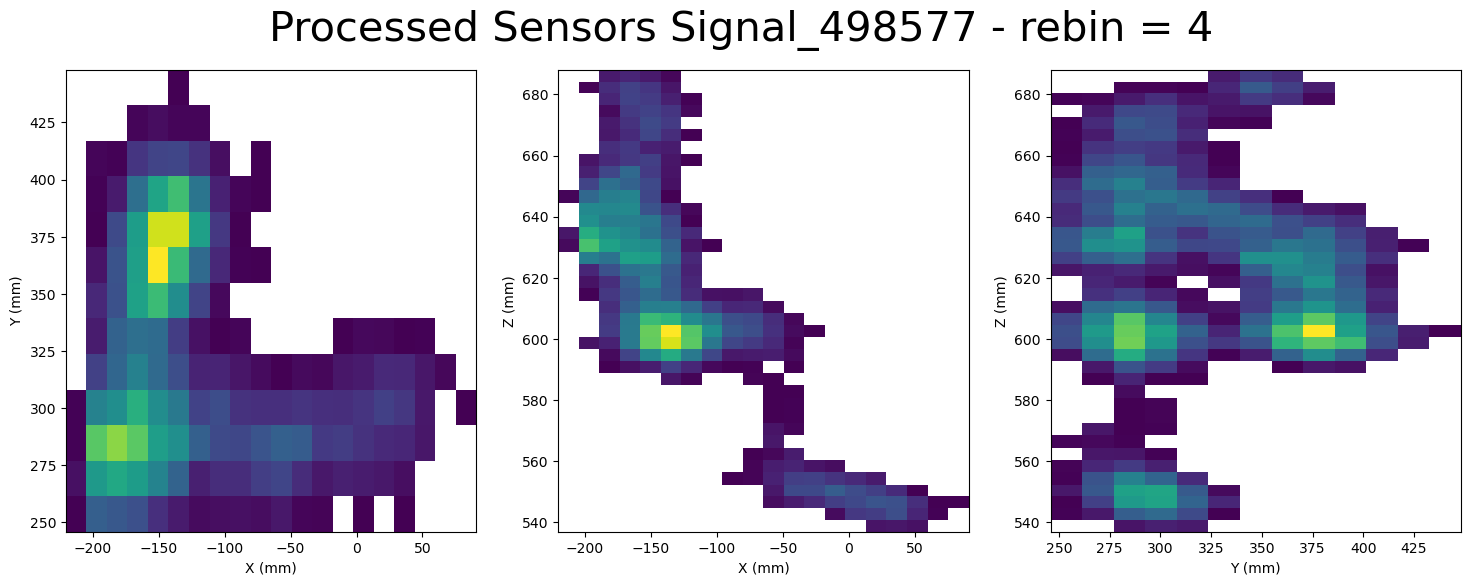

EVENT 257889
Total energy 1.73 MeV

Time spent in cut_over_Q: 0.012095928192138672 s
Time spent in drop_isolated: 0.02489471435546875 s


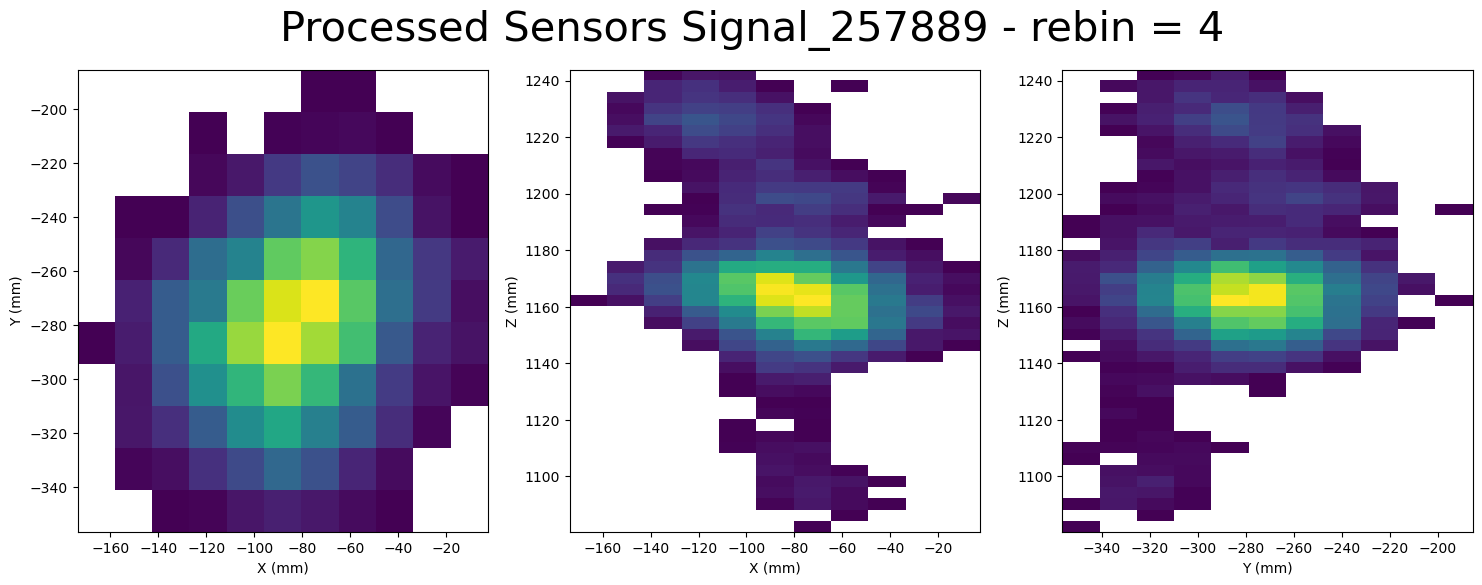

EVENT 56485
Total energy 1.42 MeV

Time spent in cut_over_Q: 0.01129293441772461 s
Time spent in drop_isolated: 0.019949913024902344 s


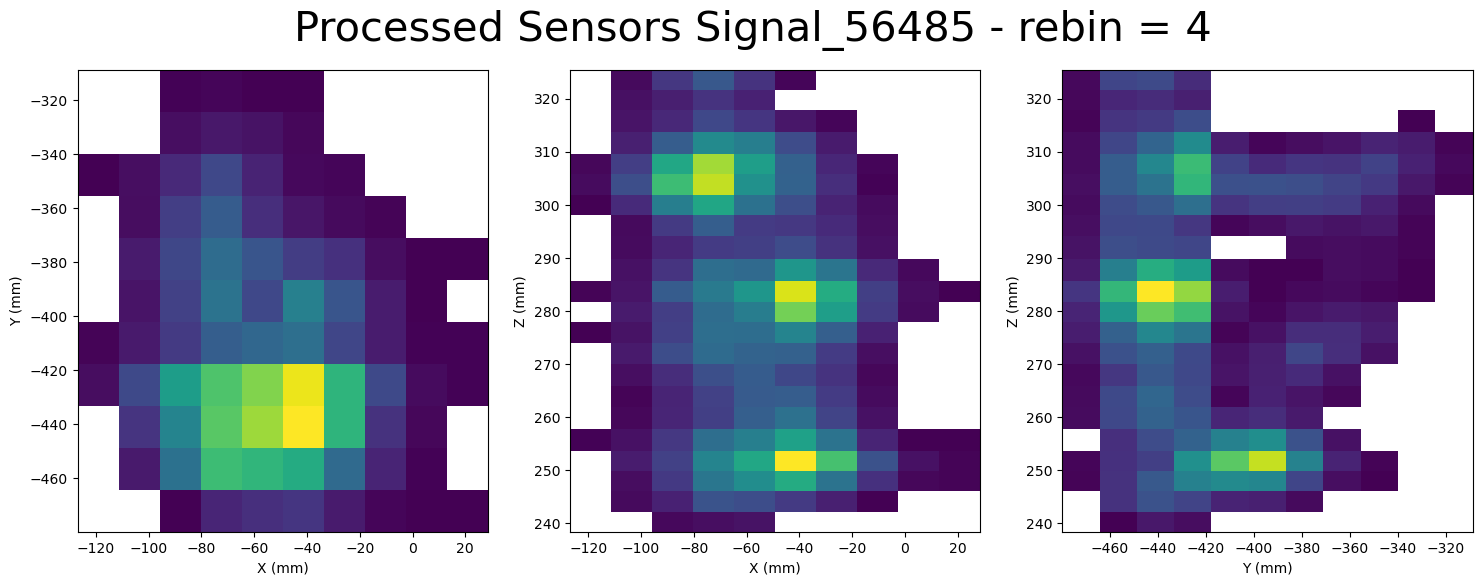

EVENT 1332942
Total energy 1.53 MeV

Time spent in cut_over_Q: 0.011471033096313477 s
Time spent in drop_isolated: 0.02146458625793457 s


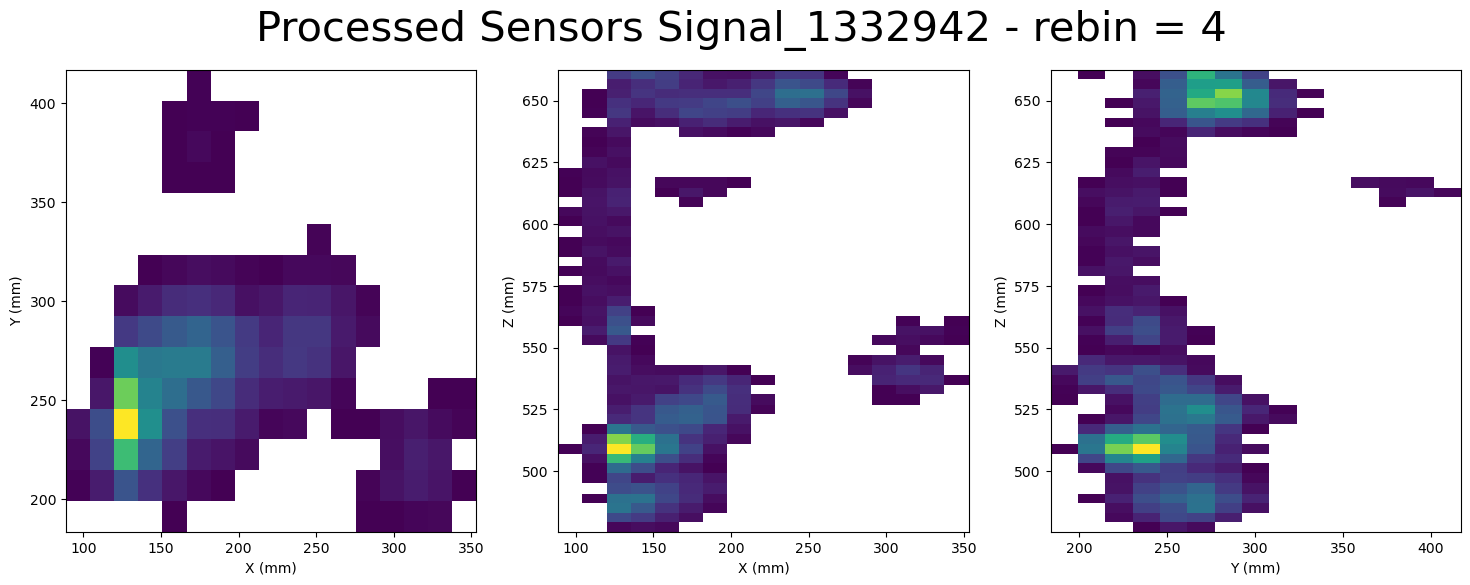

EVENT 1451606
Total energy 1.44 MeV

Time spent in cut_over_Q: 0.011562824249267578 s
Time spent in drop_isolated: 0.019721508026123047 s


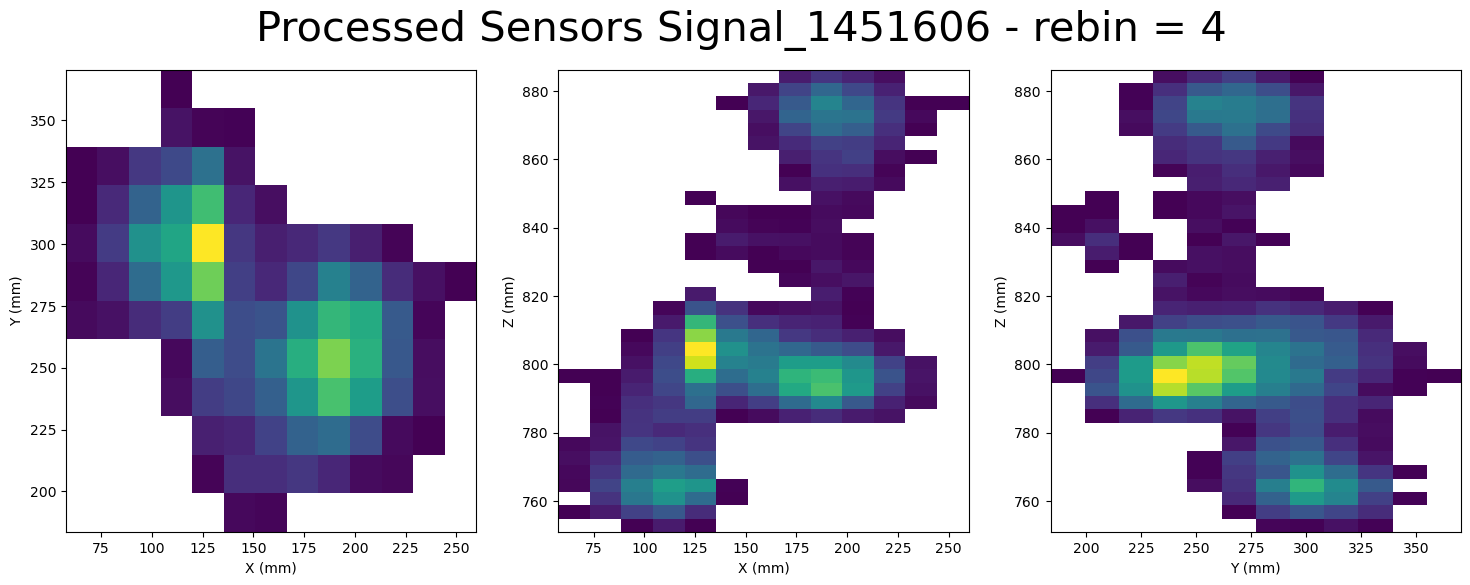

EVENT 1099492
Total energy 1.74 MeV

Time spent in cut_over_Q: 0.014756202697753906 s
Time spent in drop_isolated: 0.030765295028686523 s


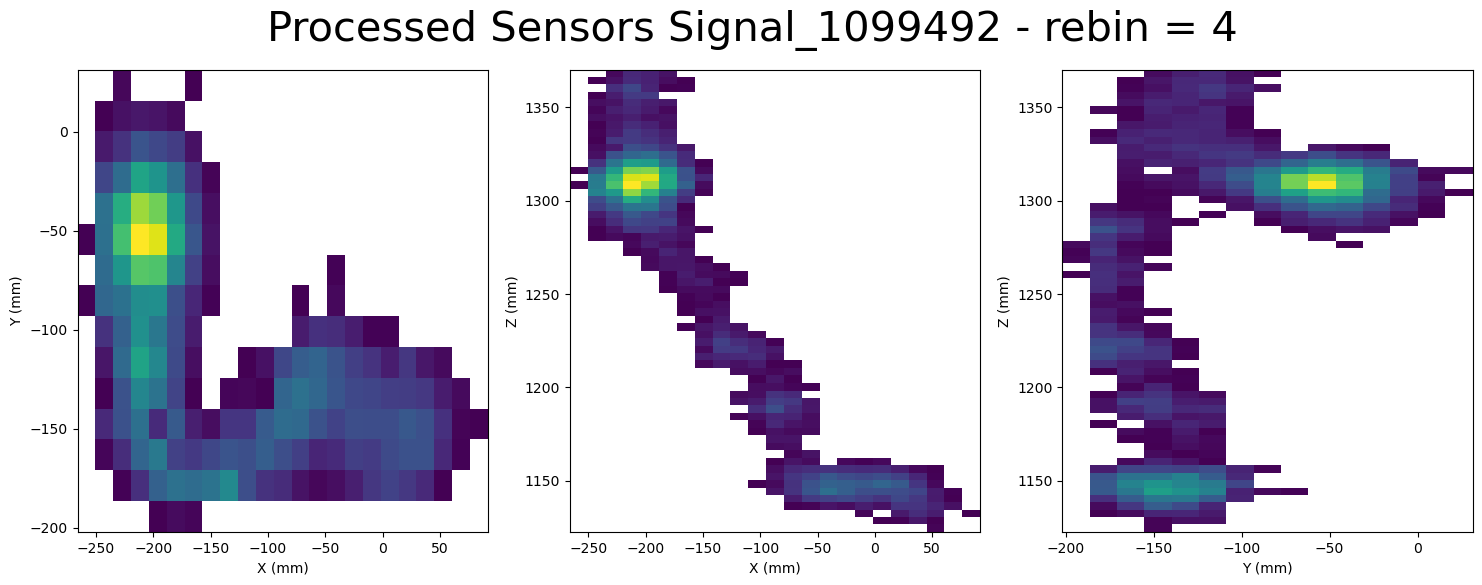

In [68]:
DES_evts = corr_DES.event.unique()

stopper = 20
for i, ev in enumerate(DES_evts):
    plotter(corr_DES, ev)
    if i > stopper:
        break

Z        Ec
event                        
590      302.408640  1.619259
2350     902.950452  1.408999
2413     166.027431  1.655015
2756     778.333384  1.696077
2937     230.337450  1.647015
...             ...       ...
1540550  474.831607  1.770482
1540930  277.028615  1.496675
1540942  757.011288  1.605091
1541237  495.941925  1.766870
1543639  535.642075  1.487541

[2355 rows x 2 columns]

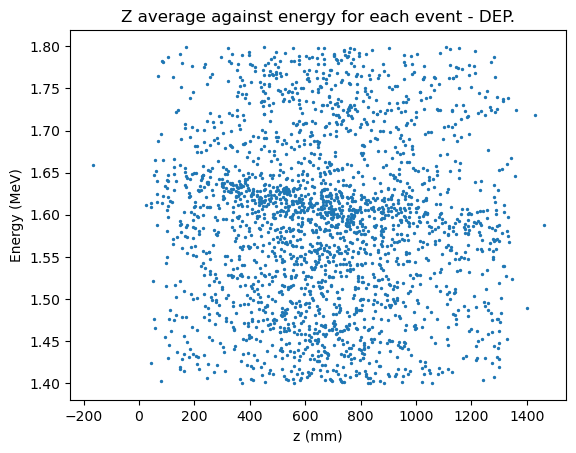

In [98]:
z_av_e_sum = corr_DES.groupby('event').agg({'Z':'mean', 'Ec': 'sum'})
display(z_av_e_sum)
plt.scatter(z_av_e_sum.Z.values, z_av_e_sum.Ec.values, s = 2)
plt.title('Z average against energy for each event - DEP.')
plt.xlabel('z (mm)')
plt.ylabel('Energy (MeV)')
plt.show()

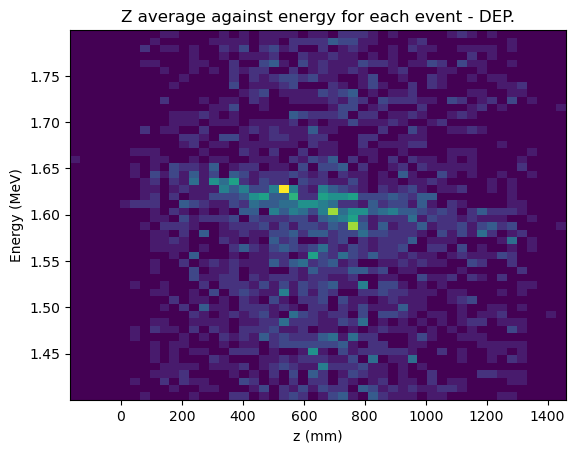

In [97]:
plt.hist2d(z_av_e_sum.Z.values, z_av_e_sum.Ec.values, bins = [50, 50])
plt.title('Z average against energy for each event - DEP.')
plt.xlabel('z (mm)')
plt.ylabel('Energy (MeV)')
plt.show()

# Low E events

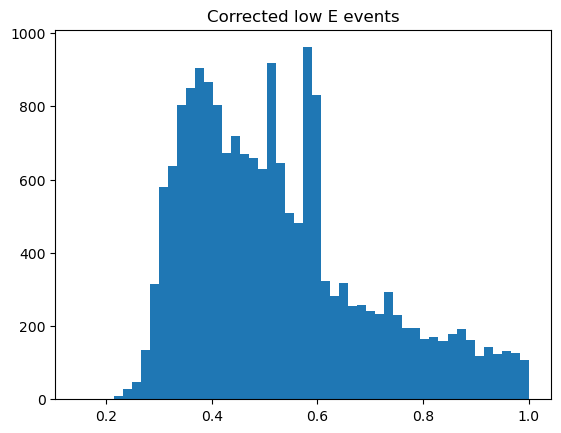

In [70]:
folder_path = 'files/15107_energy_split/'
corr_lowE = pd.read_hdf(folder_path + 'corr_low_E.h5', 'RECO/Events')

plt.hist(corr_lowE.groupby('event').Ec.sum(), bins = 50)
plt.title('Corrected low E events')
plt.show()

EVENT 1198290
Total energy 0.86 MeV

Time spent in cut_over_Q: 0.023202180862426758 s
Time spent in drop_isolated: 0.026789188385009766 s


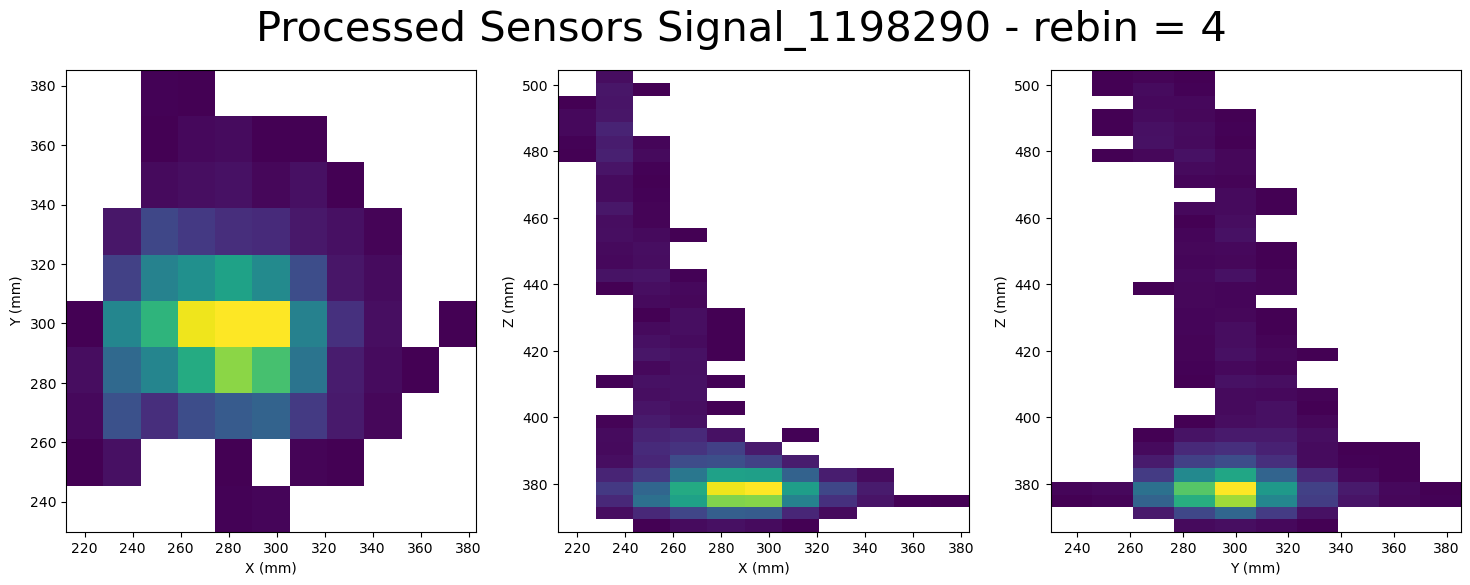

EVENT 213222
Total energy 0.37 MeV

Time spent in cut_over_Q: 0.20453095436096191 s
Time spent in drop_isolated: 0.022217512130737305 s


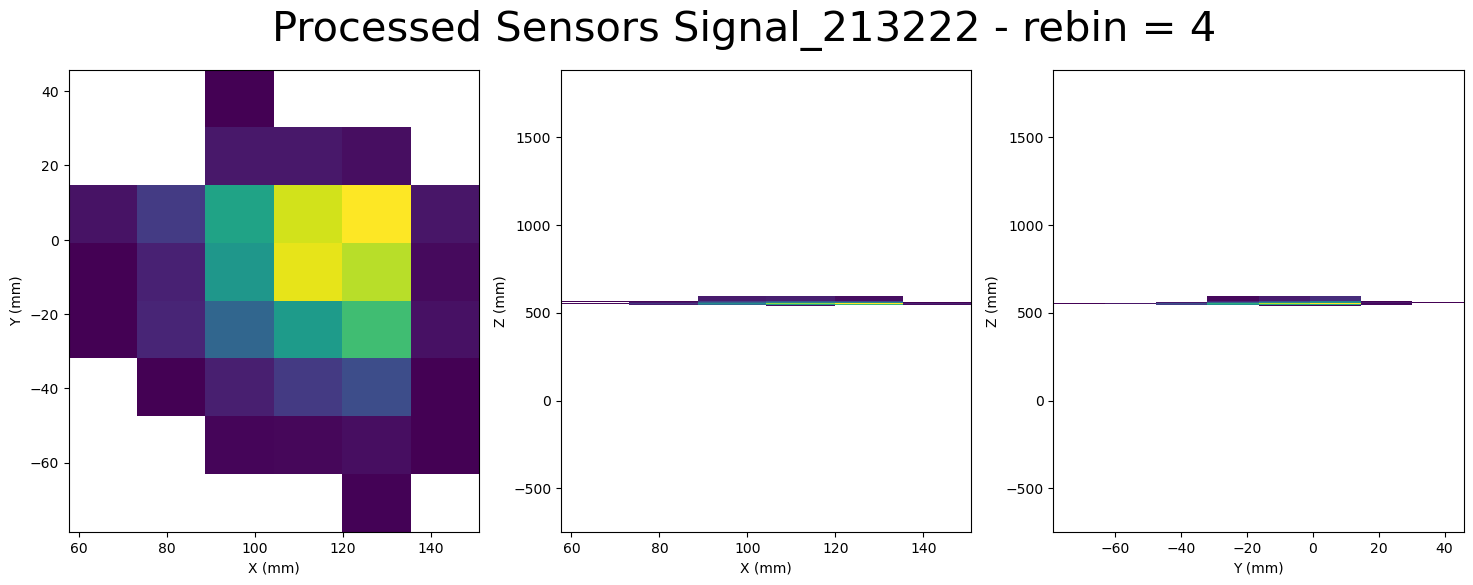

EVENT 213712
Total energy 0.32 MeV

Time spent in cut_over_Q: 0.17111968994140625 s
Time spent in drop_isolated: 0.015262365341186523 s


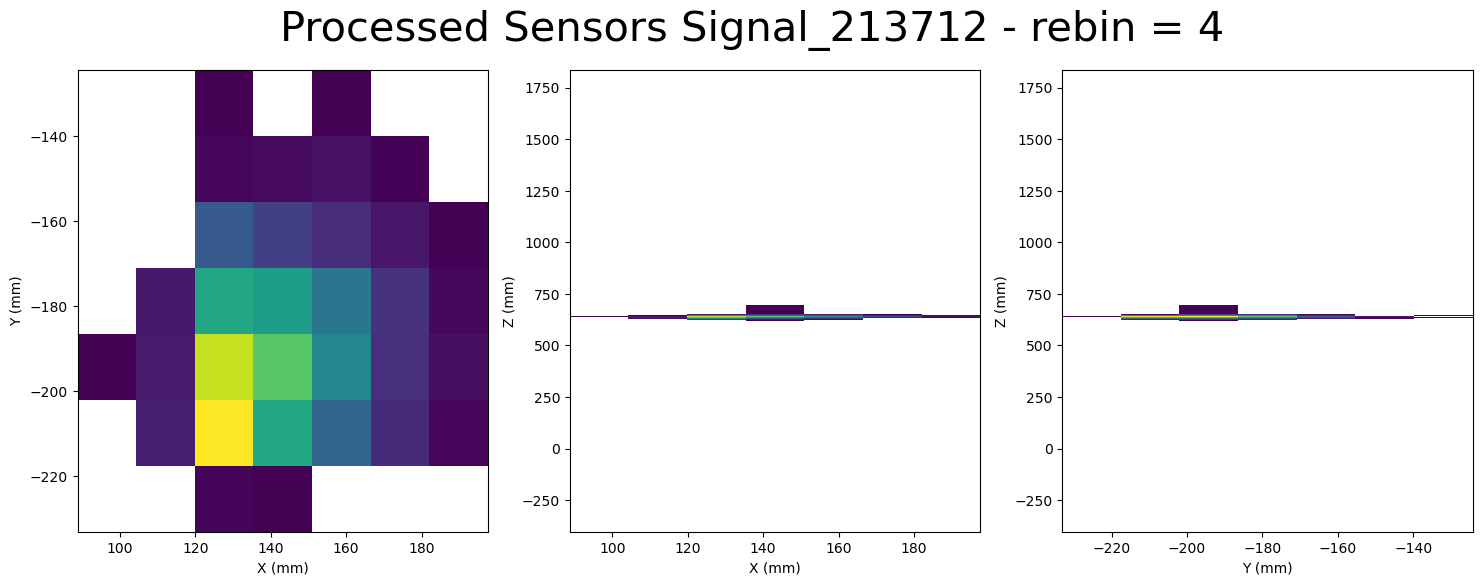

EVENT 1127415
Total energy 0.75 MeV

Time spent in cut_over_Q: 0.09431695938110352 s
Time spent in drop_isolated: 0.019183635711669922 s


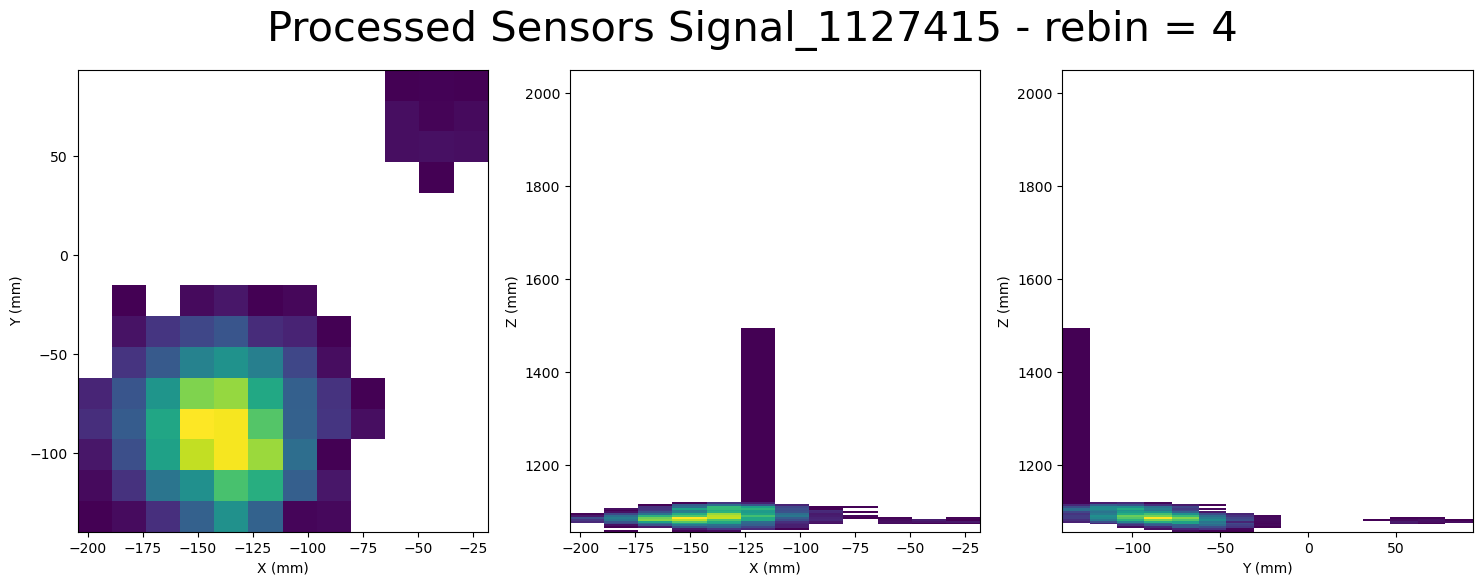

EVENT 5490
Total energy 0.47 MeV

Time spent in cut_over_Q: 0.11196589469909668 s
Time spent in drop_isolated: 0.01654815673828125 s


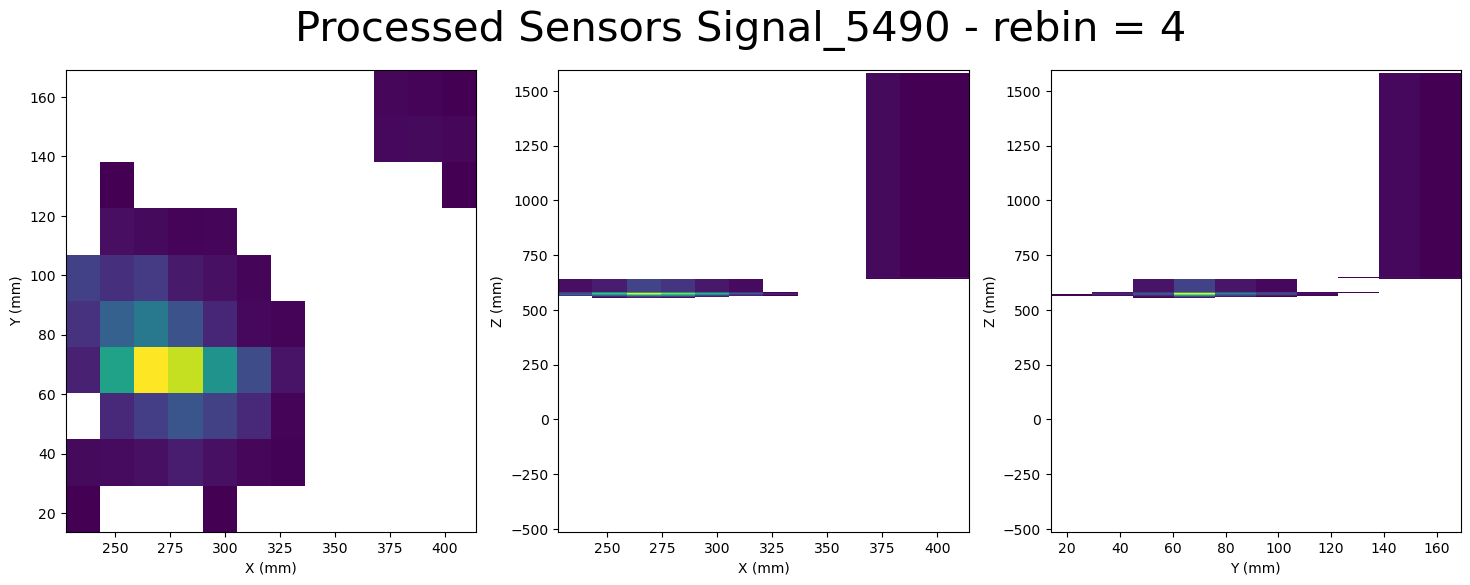

EVENT 5539
Total energy 0.51 MeV

Time spent in cut_over_Q: 0.10061097145080566 s
Time spent in drop_isolated: 0.015817880630493164 s


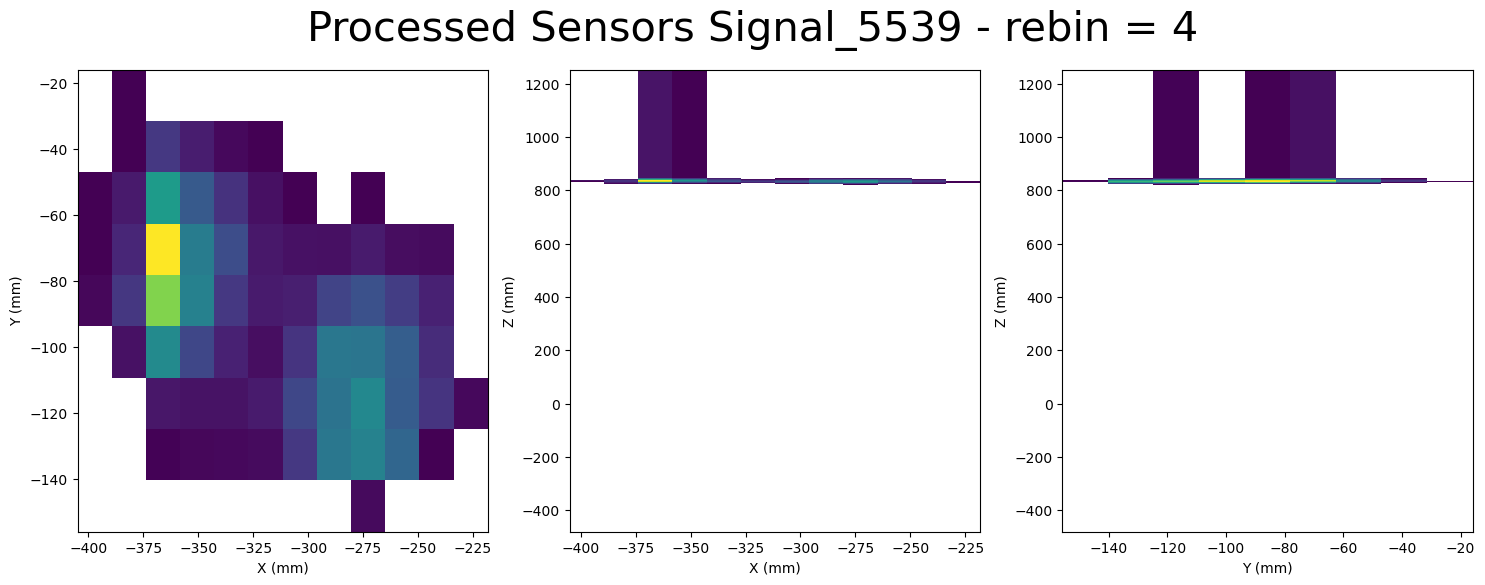

EVENT 480867
Total energy 0.61 MeV

Time spent in cut_over_Q: 0.09328007698059082 s
Time spent in drop_isolated: 0.013253927230834961 s


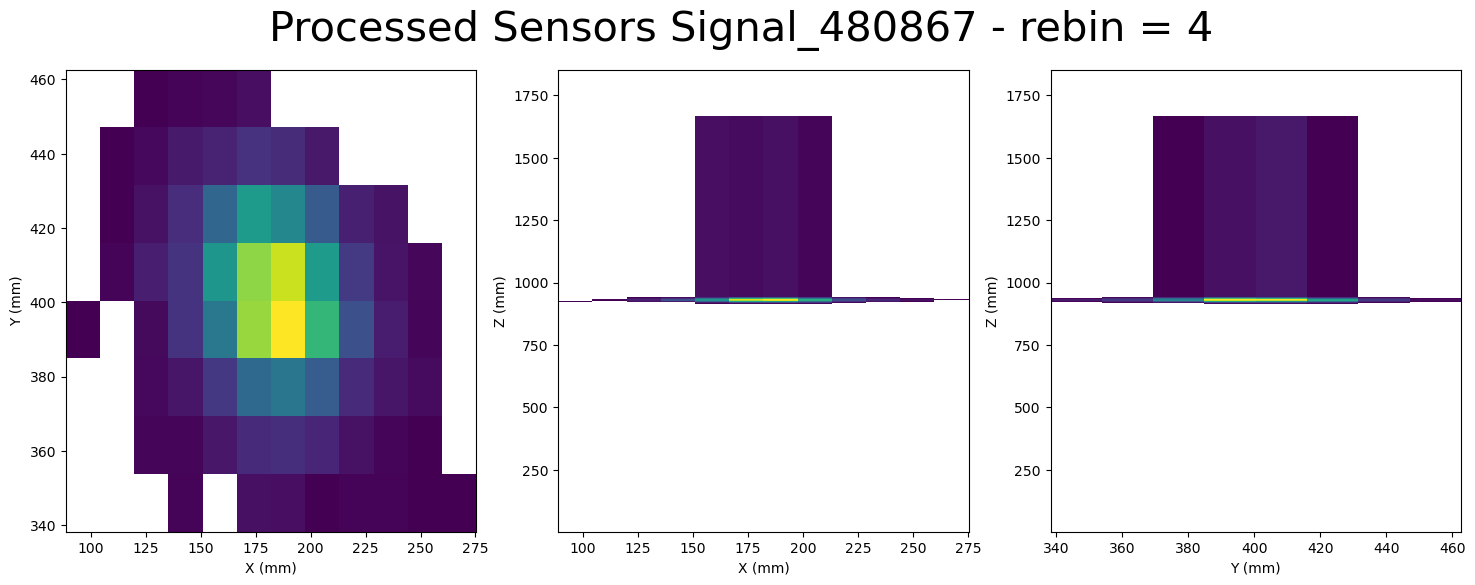

EVENT 480909
Total energy 0.35 MeV

Time spent in cut_over_Q: 0.1994009017944336 s
Time spent in drop_isolated: 0.02396249771118164 s


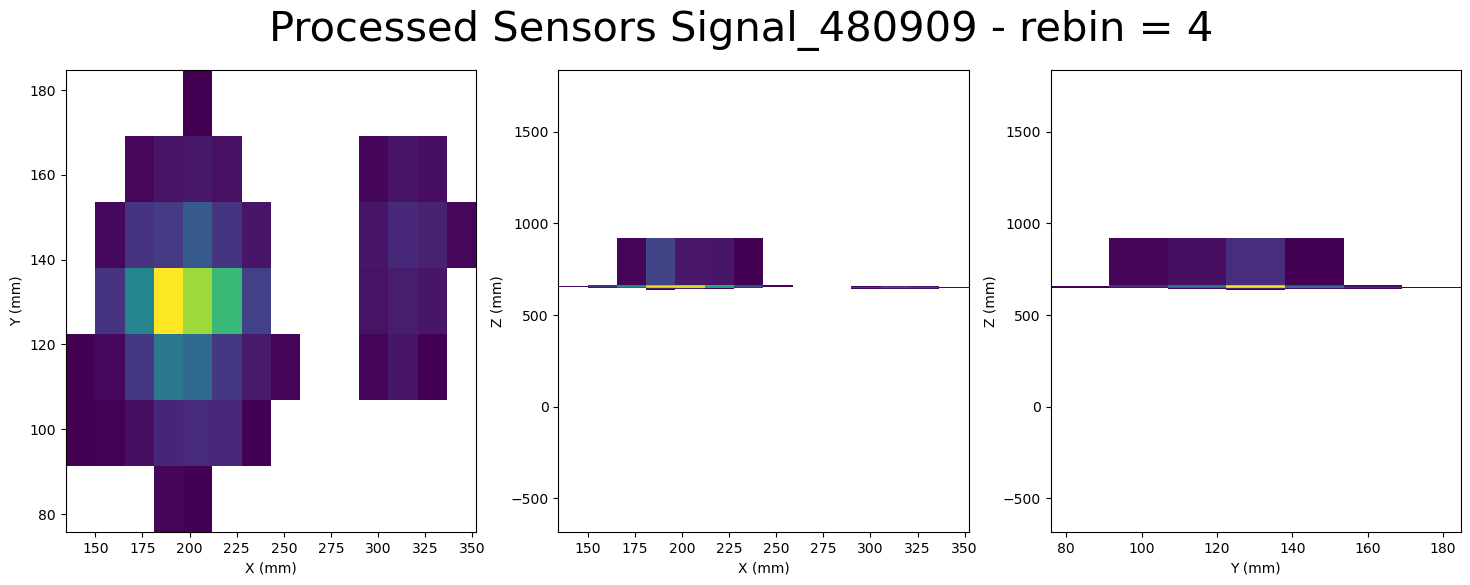

EVENT 480944
Total energy 0.55 MeV

Time spent in cut_over_Q: 0.14162659645080566 s
Time spent in drop_isolated: 0.01915574073791504 s


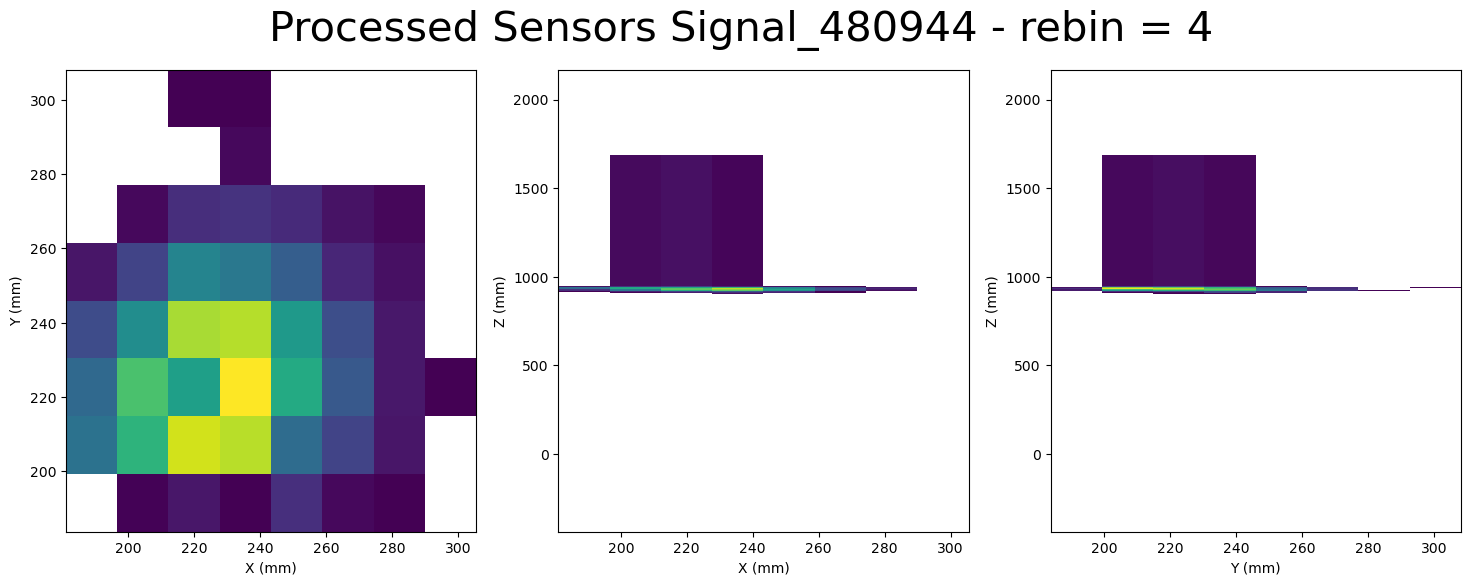

EVENT 481105
Total energy 0.40 MeV

Time spent in cut_over_Q: 0.15316081047058105 s
Time spent in drop_isolated: 0.022768259048461914 s


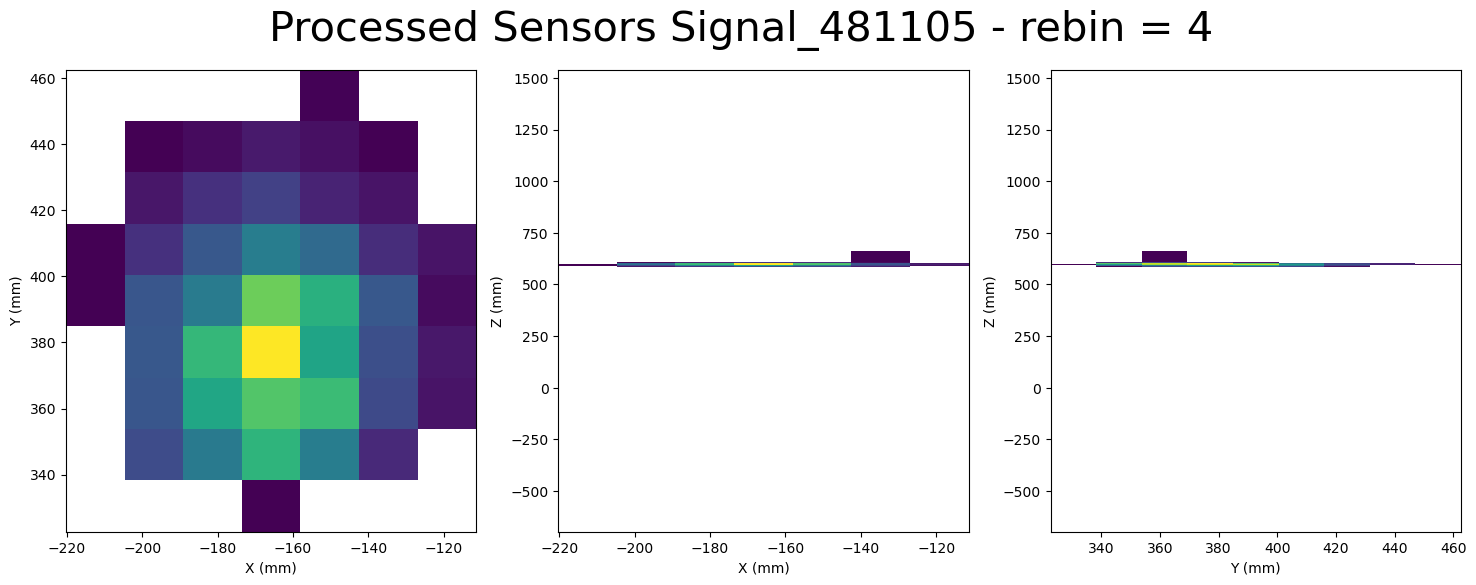

EVENT 481469
Total energy 0.51 MeV

Time spent in cut_over_Q: 0.1010432243347168 s
Time spent in drop_isolated: 0.012613534927368164 s


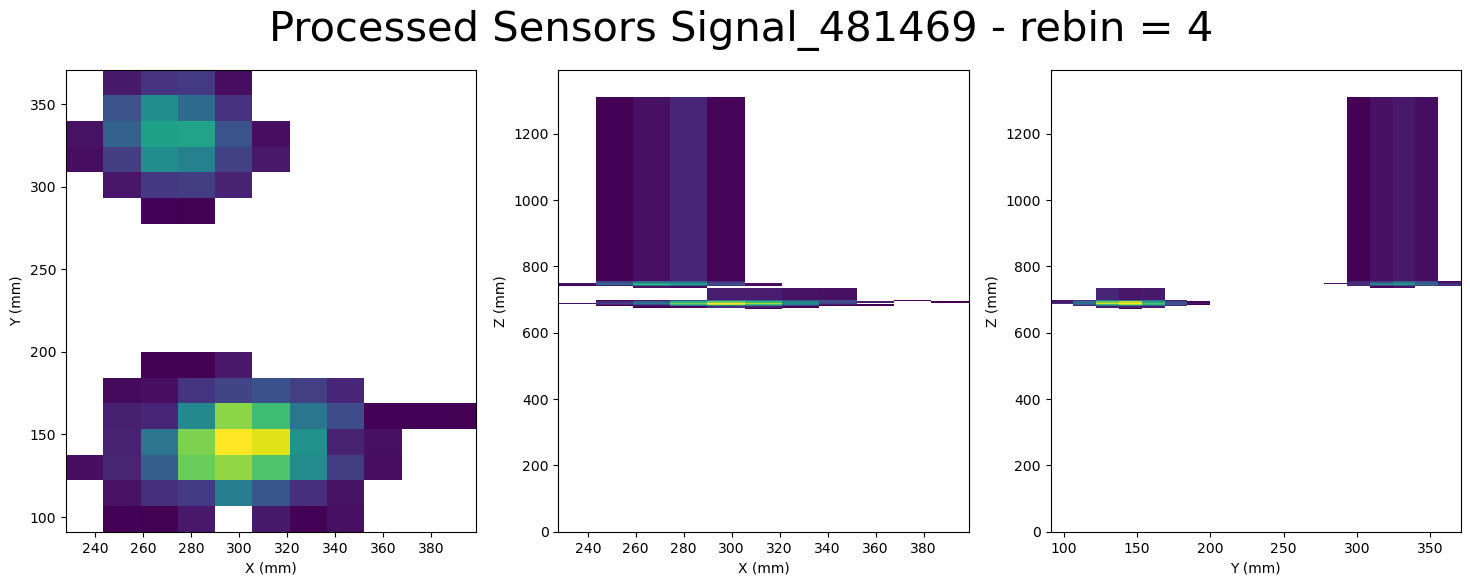

EVENT 1022191
Total energy 0.59 MeV

Time spent in cut_over_Q: 0.1120004653930664 s
Time spent in drop_isolated: 0.022089481353759766 s


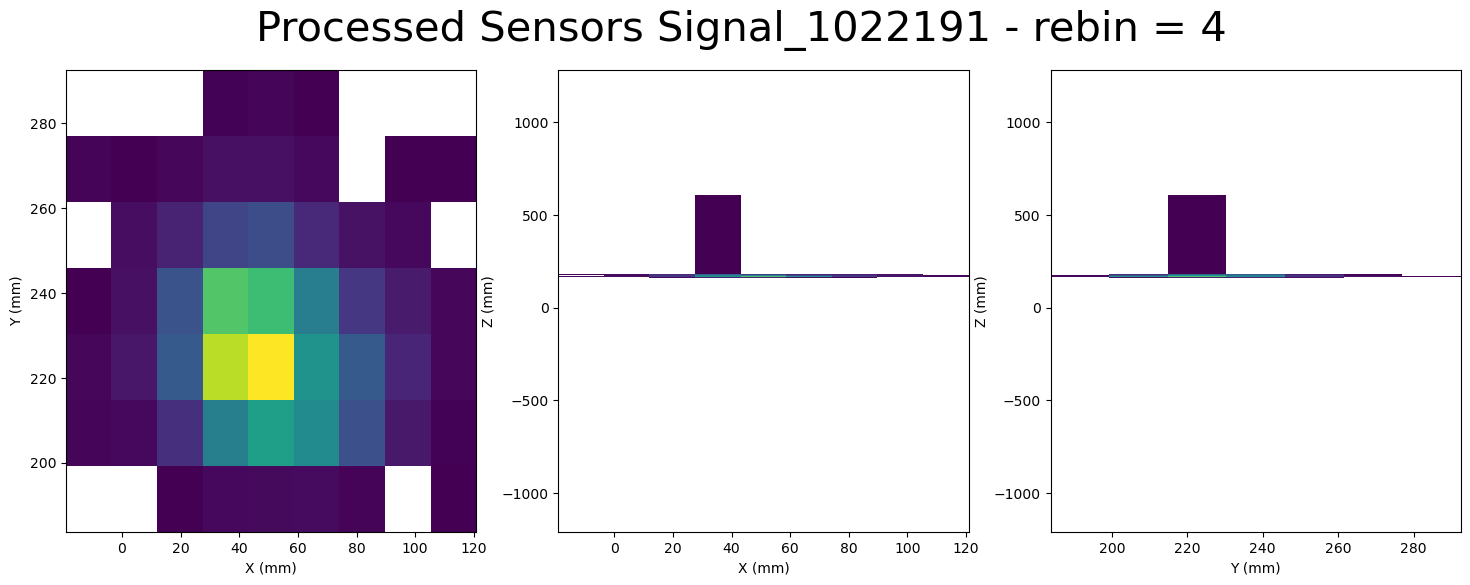

EVENT 1317325
Total energy 0.39 MeV

Time spent in cut_over_Q: 0.14162445068359375 s
Time spent in drop_isolated: 0.02250957489013672 s


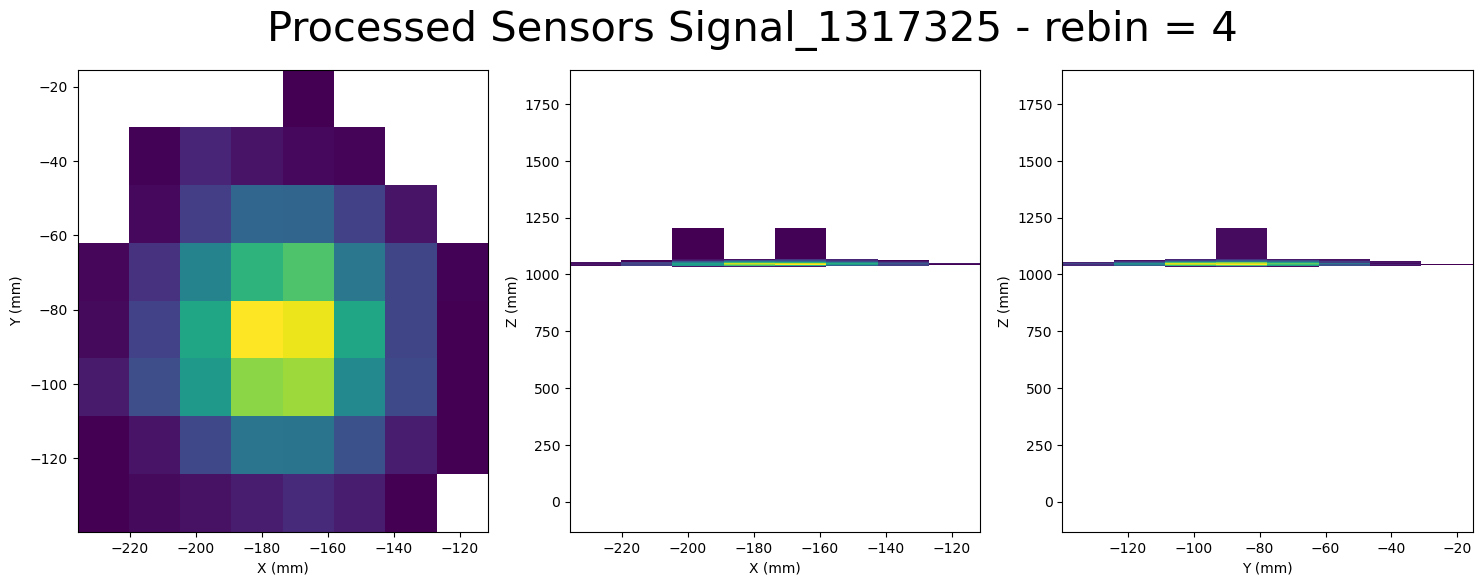

EVENT 828613
Total energy 0.53 MeV

Time spent in cut_over_Q: 0.16098237037658691 s
Time spent in drop_isolated: 0.01853656768798828 s


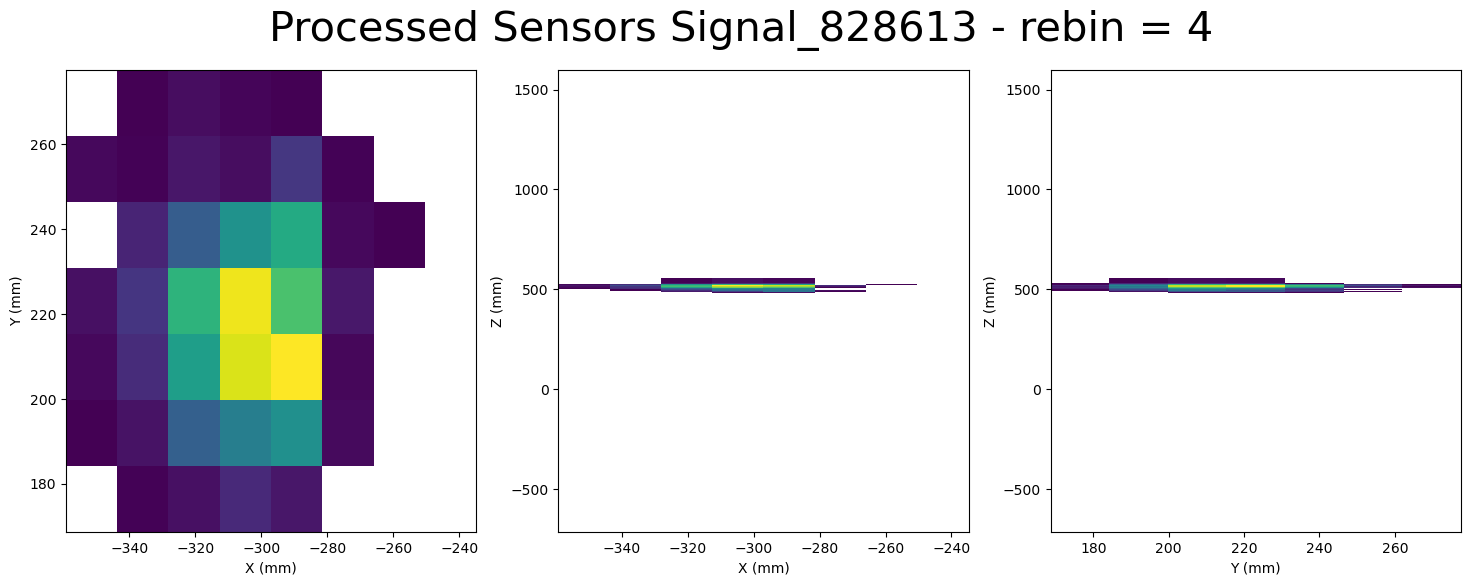

EVENT 904325
Total energy 0.32 MeV

Time spent in cut_over_Q: 0.18990874290466309 s
Time spent in drop_isolated: 0.02094721794128418 s


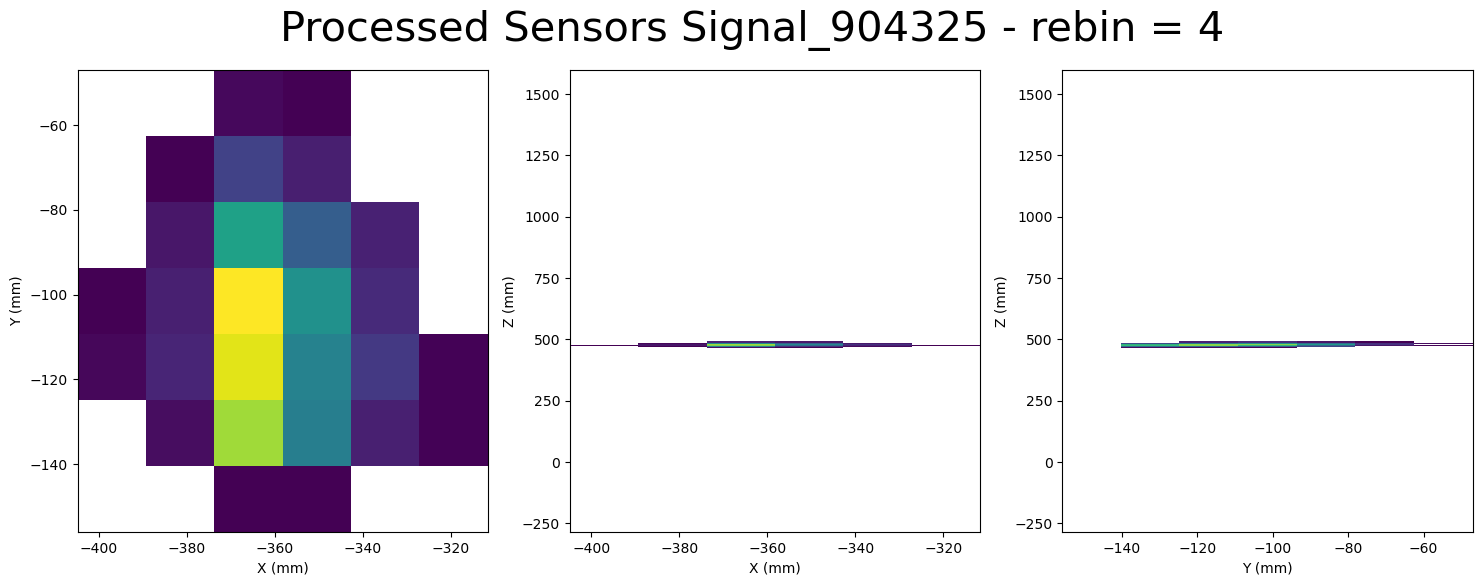

EVENT 1017081
Total energy 0.98 MeV

Time spent in cut_over_Q: 0.06882905960083008 s
Time spent in drop_isolated: 0.01975083351135254 s


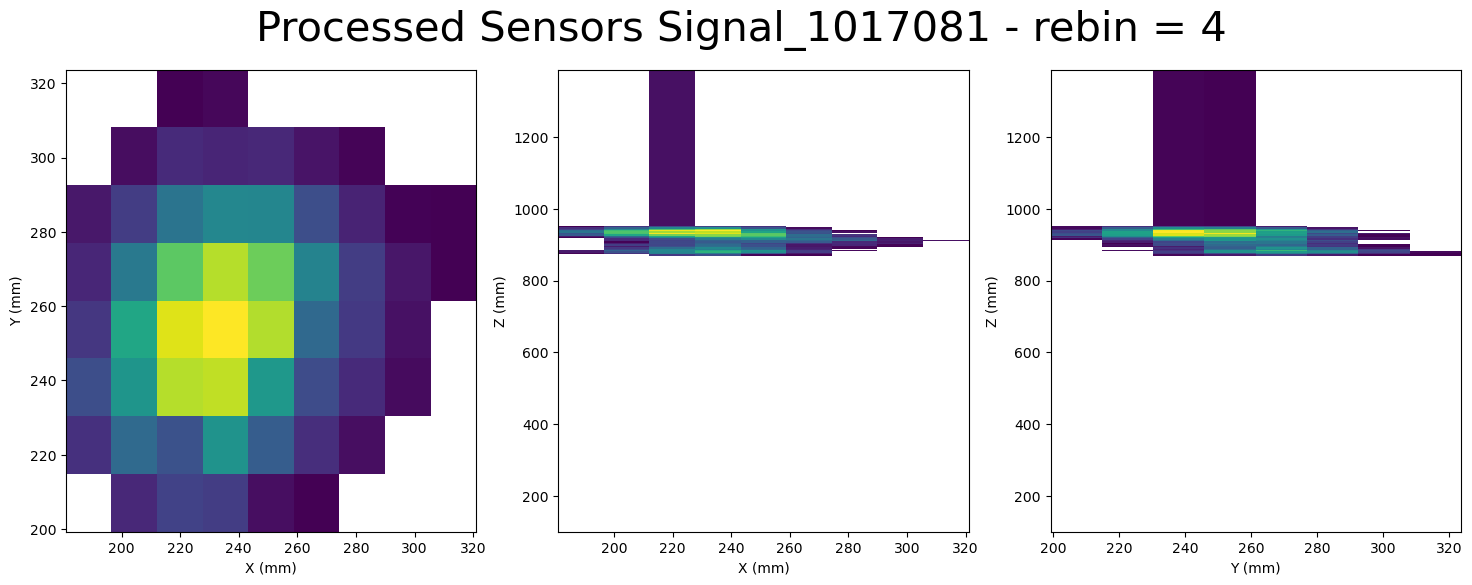

EVENT 520165
Total energy 0.44 MeV

Time spent in cut_over_Q: 0.1738567352294922 s
Time spent in drop_isolated: 0.015062332153320312 s


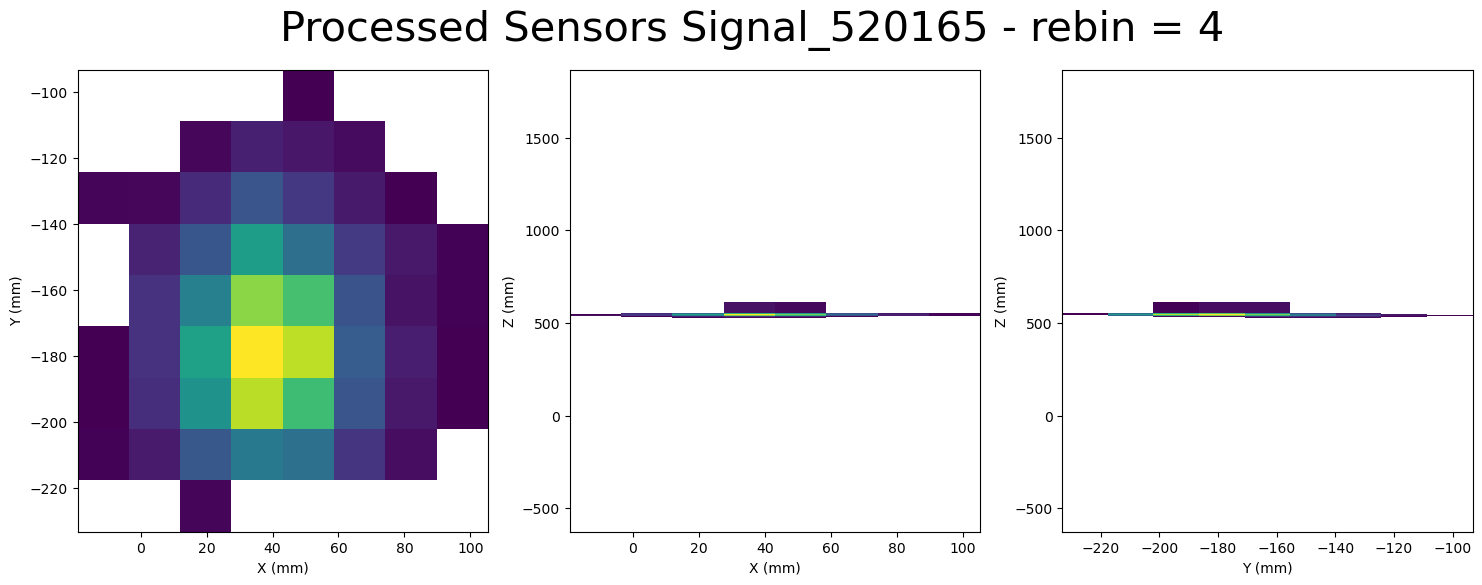

EVENT 520508
Total energy 0.74 MeV

Time spent in cut_over_Q: 0.3095278739929199 s
Time spent in drop_isolated: 0.016843795776367188 s


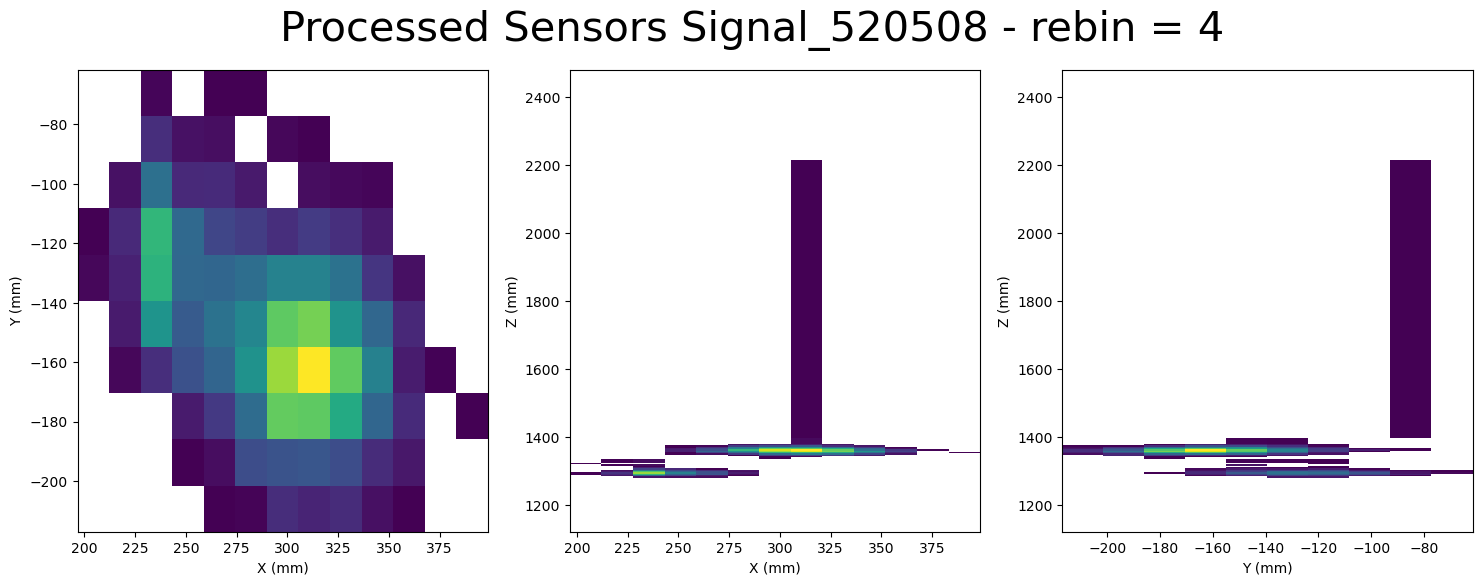

EVENT 514201
Total energy 0.71 MeV

Time spent in cut_over_Q: 0.08438777923583984 s
Time spent in drop_isolated: 0.0149993896484375 s


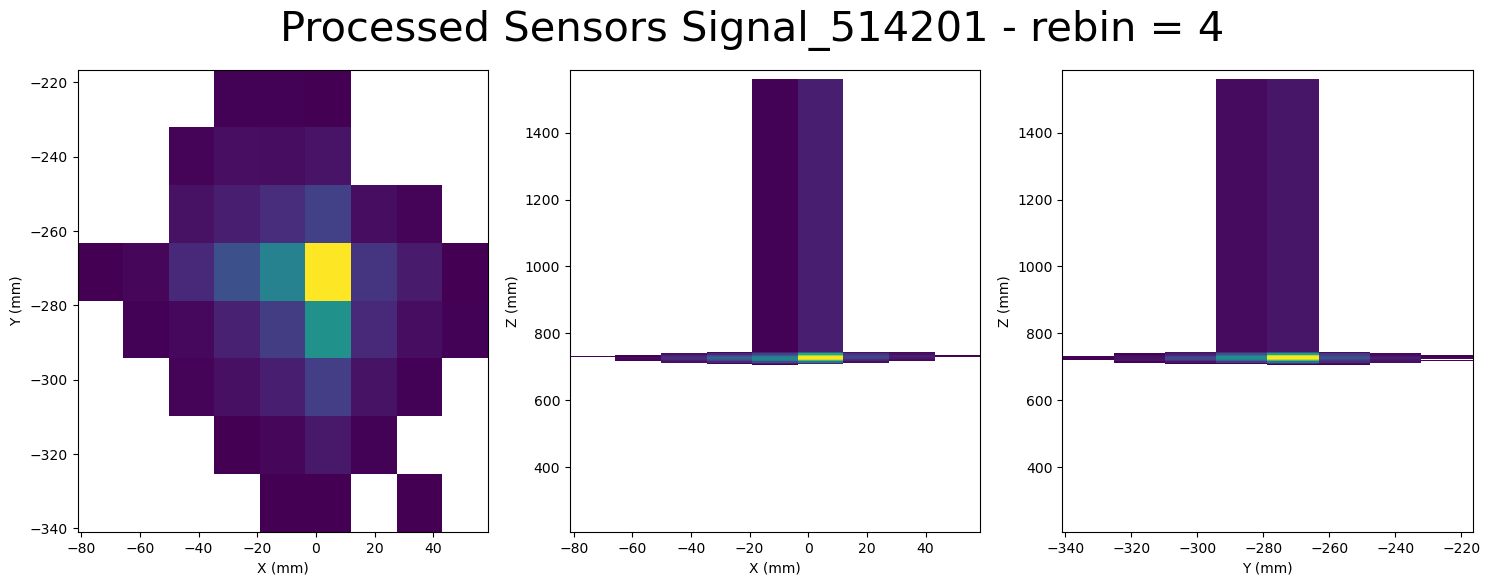

EVENT 514376
Total energy 0.99 MeV

Time spent in cut_over_Q: 0.07622647285461426 s
Time spent in drop_isolated: 0.02094411849975586 s


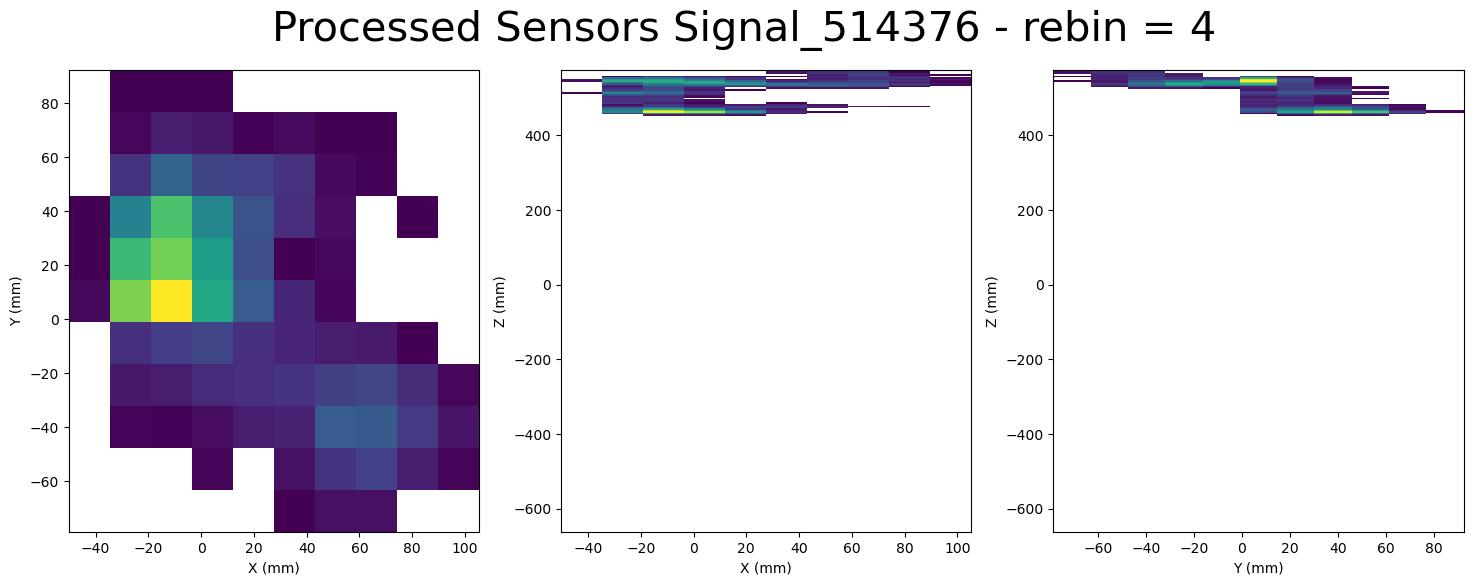

EVENT 79984
Total energy 0.62 MeV

Time spent in cut_over_Q: 0.06601738929748535 s
Time spent in drop_isolated: 0.012981653213500977 s


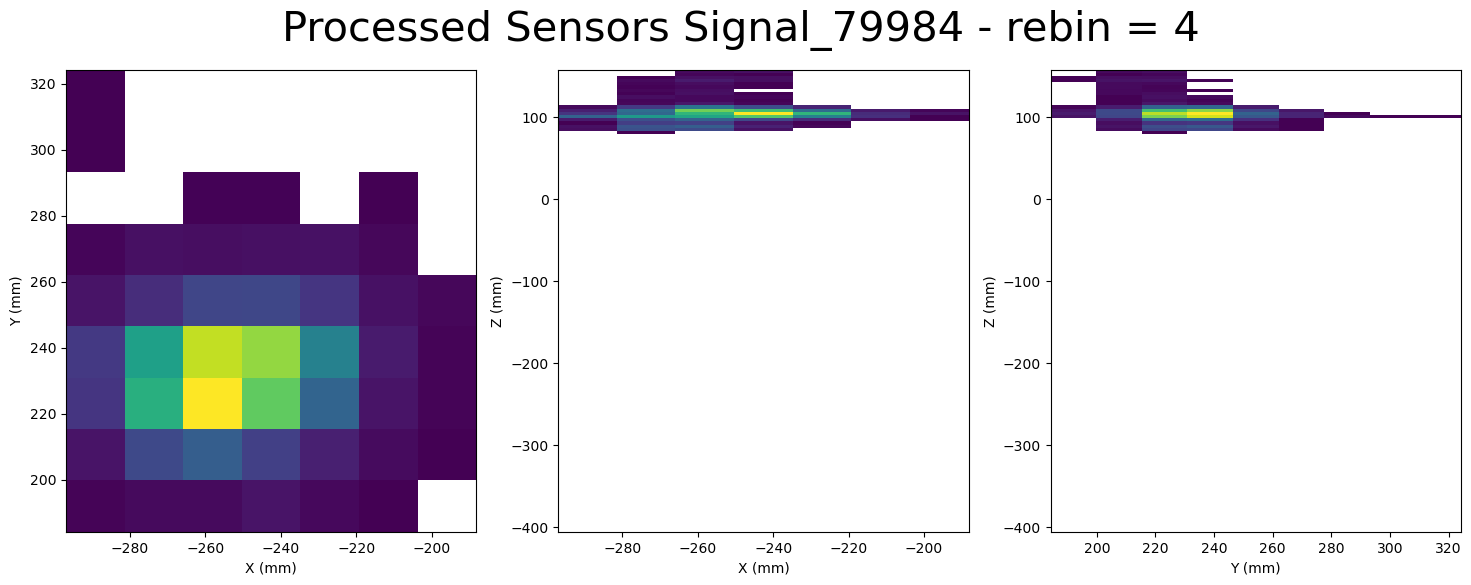

EVENT 80285
Total energy 0.60 MeV

Time spent in cut_over_Q: 0.08590817451477051 s
Time spent in drop_isolated: 0.014172792434692383 s


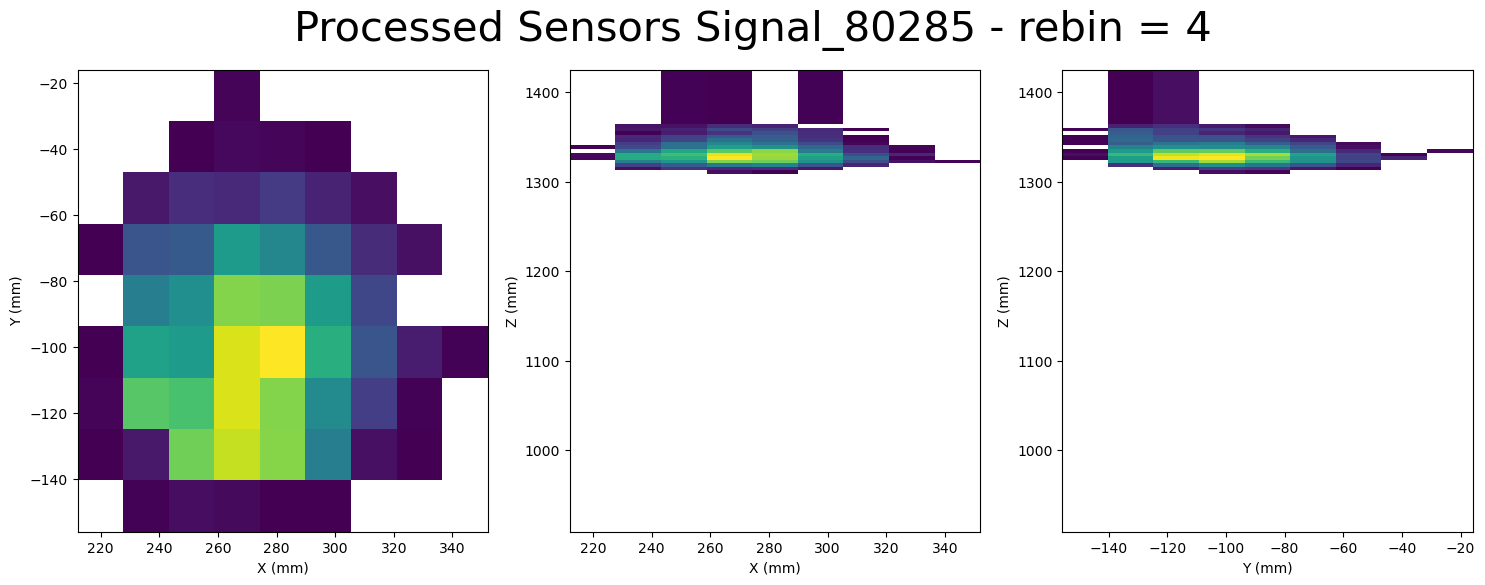

In [89]:
low_e_evts = corr_lowE.event.unique()

stopper = 20
for i, ev in enumerate(low_e_evts):
    plotter(corr_lowE, ev)
    if i > stopper:
        break

Z        Ec
event                        
33       306.681625  0.590084
178      361.450485  0.599653
229      168.583517  0.357090
275      214.866783  0.740807
384      722.303399  0.713335
...             ...       ...
1542818  465.691978  0.406478
1543049  605.460910  0.371303
1543072  447.361135  0.270703
1543120  -55.939550  0.431179
1543210  462.569445  0.509320

[18271 rows x 2 columns]

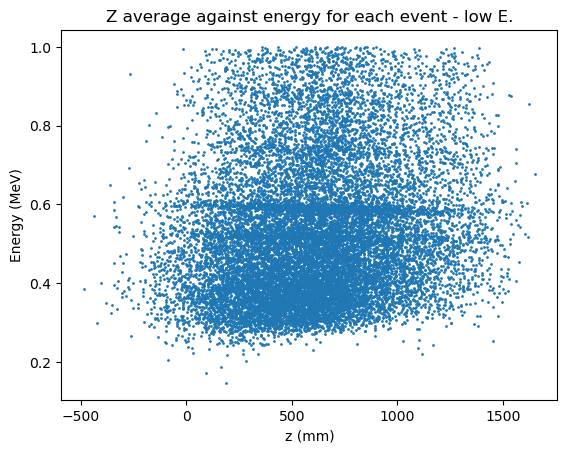

In [93]:
z_av_e_sum = corr_lowE.groupby('event').agg({'Z':'mean', 'Ec': 'sum'})
display(z_av_e_sum)
plt.scatter(z_av_e_sum.Z.values, z_av_e_sum.Ec.values, s = 1)
plt.title('Z average against energy for each event - low E.')
plt.xlabel('z (mm)')
plt.ylabel('Energy (MeV)')
plt.show()

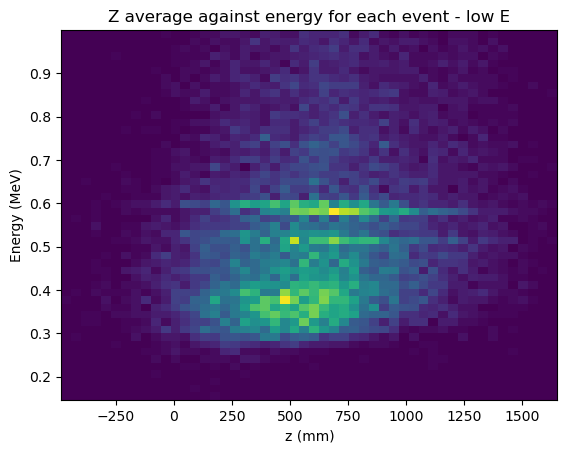

In [94]:
plt.hist2d(z_av_e_sum.Z.values, z_av_e_sum.Ec.values, bins = [50, 50])
plt.title('Z average against energy for each event - low E')
plt.xlabel('z (mm)')
plt.ylabel('Energy (MeV)')
plt.show()